In [2]:
import os
import struct
import numpy as np


class Dataset(object):

    def __init__(self, data_root, mode='train', num_classes=10):
        assert mode in ['train', 'val', 'test']

        # load images and labels
        kind = {'train': 'train', 'val': 'train', 'test': 't10k'}[mode]
        labels_path = os.path.join(data_root, '{}-labels.idx1-ubyte'.format(kind))
        images_path = os.path.join(data_root, '{}-images.idx3-ubyte'.format(kind))



        with open(labels_path, 'rb') as lbpath:
            magic, n = struct.unpack('>II', lbpath.read(8))
            labels = np.fromfile(lbpath, dtype=np.uint8)

        with open(images_path, 'rb') as imgpath:
            magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
            images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

        if mode == 'train':
            # training images and labels
            self.images = images[:55000]  # shape: (55000, 784)
            self.labels = labels[:55000]  # shape: (55000,)

        elif mode == 'val':
            # validation images and labels
            self.images = images[55000:]  # shape: (5000, 784)
            self.labels = labels[55000:]  # shape: (5000, )

        else:
            # test data
            self.images = images  # shape: (10000, 784)
            self.labels = labels  # shape: (10000, )

        self.num_classes = 10

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Normalize from [0, 255.] to [0., 1.0], and then subtract by the mean value
        image = image / 255.0
        image = image - np.mean(image)

        return image, label


class IterationBatchSampler(object):

    def __init__(self, dataset, max_epoch, batch_size=2, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

    def prepare_epoch_indices(self):
        indices = np.arange(len(self.dataset))

        if self.shuffle:
            np.random.shuffle(indices)

        num_iteration = len(indices) // self.batch_size + int(len(indices) % self.batch_size)
        self.batch_indices = np.split(indices, num_iteration)

    def __iter__(self):
        return iter(self.batch_indices)

    def __len__(self):
        return len(self.batch_indices)


class Dataloader(object):

    def __init__(self, dataset, sampler):
        self.dataset = dataset
        self.sampler = sampler

    def __iter__(self):
        self.sampler.prepare_epoch_indices()

        for batch_indices in self.sampler:
            batch_images = []
            batch_labels = []
            for idx in batch_indices:
                img, label = self.dataset[idx]
                batch_images.append(img)
                batch_labels.append(label)

            batch_images = np.stack(batch_images)
            batch_labels = np.stack(batch_labels)

            yield batch_images, batch_labels

    def __len__(self):
        return len(self.sampler)


def build_dataloader(data_root, max_epoch, batch_size, shuffle=False, mode='train'):
    dataset = Dataset(data_root, mode)
    sampler = IterationBatchSampler(dataset, max_epoch, batch_size, shuffle)
    data_lodaer = Dataloader(dataset, sampler)
    return data_lodaer

import numpy as np

class SGD(object):
    def __init__(self, model, learning_rate, momentum=0.0):
        self.model = model
        self.learning_rate = learning_rate
        self.momentum = momentum
        # Initialize velocities for weights and biases to zeros
        self.v_W = np.zeros_like(model.W)
        self.v_b = np.zeros_like(model.b)
    def step(self):
        """One updating step, update weights"""

        layer = self.model
        if layer.trainable:

            ############################################################################
            # TODO: Put your code here
            # Calculate diff_W and diff_b using layer.grad_W and layer.grad_b.
            # You need to add momentum to this.

            # 速度更新(Velocity update)
            # V(t+1) = μ*vt - η* ▽L

            # 权重更新(Weight update)
            # W(t+1) = Wt + v(t+1)
            
            self.v_W = self.momentum * self.v_W - self.learning_rate * layer.grad_W
            layer.W += self.v_W
            
            self.v_b = self.momentum * self.v_b - self.learning_rate * layer.grad_b
            layer.b += self.v_b

            ############################################################################


class Solver(object):
    def __init__(self, cfg):
        self.cfg = cfg

        # build dataloader
        train_loader, val_loader, test_loader = self.build_loader(cfg)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader


        # build evaluation model
        self.model = SoftmaxCrossEntropyLoss(784, 10)

        # build optimizer
        self.optimizer = self.build_optimizer(self.model, cfg)

    @staticmethod
    def build_loader(cfg):
        train_loader = build_dataloader(
            cfg['data_root'], cfg['max_epoch'], cfg['batch_size'], shuffle=True, mode='train')

        val_loader = build_dataloader(
            cfg['data_root'], 1, cfg['batch_size'], shuffle=False, mode='val')

        test_loader = build_dataloader(
            cfg['data_root'], 1, cfg['batch_size'], shuffle=False, mode='test')

        return train_loader, val_loader, test_loader

    @staticmethod
    def build_optimizer(model, cfg):
        return SGD(model, cfg['learning_rate'], cfg['momentum'])

    def train(self):
        max_epoch = self.cfg['max_epoch']

        epoch_train_loss, epoch_train_acc = [], []
        for epoch in range(max_epoch):

            iteration_train_loss, iteration_train_acc = [], []
            for iteration, (images, labels) in enumerate(self.train_loader):
                # forward pass
                loss, acc = self.model.forward(images, labels)

                self.model.gradient_computing()

                # updata the model weights
                self.optimizer.step()

                # restore loss and accuracy
                iteration_train_loss.append(loss)
                iteration_train_acc.append(acc)

                # display iteration training info
                if iteration % self.cfg['display_freq'] == 0:
                    print("Epoch [{}][{}]\t Batch [{}][{}]\t Training Loss {:.4f}\t Accuracy {:.4f}".format(
                        epoch, max_epoch, iteration, len(self.train_loader), loss, acc))

            avg_train_loss, avg_train_acc = np.mean(iteration_train_loss), np.mean(iteration_train_acc)
            epoch_train_loss.append(avg_train_loss)
            epoch_train_acc.append(avg_train_acc)

            # validate
            avg_val_loss, avg_val_acc = self.validate()

            # display epoch training info
            print('\nEpoch [{}]\t Average training loss {:.4f}\t Average training accuracy {:.4f}'.format(
                epoch, avg_train_loss, avg_train_acc))

            # display epoch valiation info
            print('Epoch [{}]\t Average validation loss {:.4f}\t Average validation accuracy {:.4f}\n'.format(
                epoch, avg_val_loss, avg_val_acc))

        return epoch_train_loss, epoch_train_acc

    def validate(self):
        loss_set, acc_set = [], []
        for images, labels in self.val_loader:
            loss, acc = self.model.forward(images, labels)
            loss_set.append(loss)
            acc_set.append(acc)

        loss = np.mean(loss_set)
        acc = np.mean(acc_set)
        return loss, acc

    def test(self):
        loss_set, acc_set = [], []
        for images, labels in self.test_loader:
            loss, acc = self.model.forward(images, labels)
            loss_set.append(loss)
            acc_set.append(acc)

        loss = np.mean(loss_set)
        acc = np.mean(acc_set)
        return loss, acc

import matplotlib.pyplot as plt
import numpy as np

def plot_loss_and_acc(loss_and_acc_dict):
    # visualize loss curve
    plt.figure()

    min_loss, max_loss = 100.0, 0.0
    for key, (loss_list, acc_list) in loss_and_acc_dict.items():
        min_loss = min(loss_list) if min(loss_list) < min_loss else min_loss
        max_loss = max(loss_list) if max(loss_list) > max_loss else max_loss

        num_epoch = len(loss_list)
        plt.plot(range(1, 1 + num_epoch), loss_list, '-s', label=key)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(range(0, num_epoch + 1, 2))
    plt.axis([0, num_epoch + 1, min_loss - 0.1, max_loss + 0.1])
    plt.show()

    # visualize acc curve
    plt.figure()

    min_acc, max_acc = 1.0, 0.0
    for key, (loss_list, acc_list) in loss_and_acc_dict.items():
        min_acc = min(acc_list) if min(acc_list) < min_acc else min_acc
        max_acc = max(acc_list) if max(acc_list) > max_acc else max_acc

        num_epoch = len(acc_list)
        plt.plot(range(1, 1 + num_epoch), acc_list, '-s', label=key)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range(0, num_epoch + 1, 2))
    plt.axis([0, num_epoch + 1, min_acc, 1.0])
    plt.show()

import numpy as np

# a small number to prevent dividing by zero, maybe useful for you
EPS = 1e-11

class SoftmaxCrossEntropyLoss(object):

    def __init__(self, num_input, num_output, trainable=True):
        """
        Apply a linear transformation to the incoming data: y = Wx + b
        Args:
            num_input: size of each input sample
            num_output: size of each output sample
            trainable: whether if this layer is trainable
        """

        self.num_input = num_input
        self.num_output = num_output
        self.trainable = trainable
        self.XavierInit()

    def forward(self, Input, labels):
        """
          Inputs: (minibatch)
          - Input: (batch_size, 784)
          - labels: the ground truth label, shape (batch_size, )
        """

        ############################################################################
        # 线性变换
        scores = np.dot(Input, self.W) + self.b
        
        # Softmax函数
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probs = exp_scores / (np.sum(exp_scores, axis=1, keepdims=True) + EPS)
        
        # 交叉熵损失
        N = Input.shape[0]
        correct_logprobs = -np.log(probs[np.arange(N), labels] + EPS)
        loss = np.sum(correct_logprobs) / N
        
        # 准确率
        acc = np.mean(np.argmax(probs, axis=1) == labels)
        
        # 存储中间变量供后续梯度计算使用
        self.cache = (Input, probs, labels)

        ############################################################################

        return loss, acc

    def gradient_computing(self):

        ############################################################################
        Input, probs, labels = self.cache
        N = Input.shape[0]

        # Softmax损失对scores的梯度
        dscores = probs
        dscores[np.arange(N), labels] -= 1
        dscores /= N
        
        # 对W和b的梯度
        self.grad_W = np.dot(Input.T, dscores)
        self.grad_b = np.sum(dscores, axis=0, keepdims=True)
        ############################################################################


    def XavierInit(self):
        """
        Initialize the weigths
        """
        raw_std = (2 / (self.num_input + self.num_output))**0.5
        init_std = raw_std * (2**0.5)
        self.W = np.random.normal(0, init_std, (self.num_input, self.num_output))
        self.b = np.random.normal(0, init_std, (1, self.num_output))


In [22]:
import time 

start_time = time.time()
cfg = {
    'data_root': r'C:/Users/31393/Desktop/09d4e2b1-cb77-43d1-a527-b3a5b5f664f9/hw1/data' ,
    'max_epoch': 10,
    'batch_size': 100,
    'learning_rate': 0.01,
    'momentum': 0,
    'display_freq': 50,
}

runner = Solver(cfg)
loss1, acc1 = runner.train()

end_time = time.time()

# 计算代码运行时间
run_time_no_momentum = end_time - start_time

print(f"没有momentum代码运行时间: {run_time_no_momentum}秒")

Epoch [0][10]	 Batch [0][550]	 Training Loss 2.5075	 Accuracy 0.1100
Epoch [0][10]	 Batch [50][550]	 Training Loss 1.9697	 Accuracy 0.4000
Epoch [0][10]	 Batch [100][550]	 Training Loss 1.6429	 Accuracy 0.5600
Epoch [0][10]	 Batch [150][550]	 Training Loss 1.4432	 Accuracy 0.6800
Epoch [0][10]	 Batch [200][550]	 Training Loss 1.2380	 Accuracy 0.6900
Epoch [0][10]	 Batch [250][550]	 Training Loss 1.1447	 Accuracy 0.6900
Epoch [0][10]	 Batch [300][550]	 Training Loss 1.1677	 Accuracy 0.7300
Epoch [0][10]	 Batch [350][550]	 Training Loss 0.9748	 Accuracy 0.8100
Epoch [0][10]	 Batch [400][550]	 Training Loss 0.9371	 Accuracy 0.7600
Epoch [0][10]	 Batch [450][550]	 Training Loss 0.9119	 Accuracy 0.7800
Epoch [0][10]	 Batch [500][550]	 Training Loss 0.8216	 Accuracy 0.8000

Epoch [0]	 Average training loss 1.2715	 Average training accuracy 0.6575
Epoch [0]	 Average validation loss 0.7300	 Average validation accuracy 0.8536

Epoch [1][10]	 Batch [0][550]	 Training Loss 0.8438	 Accuracy 0.8000


Epoch [8]	 Average training loss 0.4141	 Average training accuracy 0.8872
Epoch [8]	 Average validation loss 0.3251	 Average validation accuracy 0.9156

Epoch [9][10]	 Batch [0][550]	 Training Loss 0.3809	 Accuracy 0.9000
Epoch [9][10]	 Batch [50][550]	 Training Loss 0.3883	 Accuracy 0.9100
Epoch [9][10]	 Batch [100][550]	 Training Loss 0.4689	 Accuracy 0.9100
Epoch [9][10]	 Batch [150][550]	 Training Loss 0.4378	 Accuracy 0.8900
Epoch [9][10]	 Batch [200][550]	 Training Loss 0.4000	 Accuracy 0.9000
Epoch [9][10]	 Batch [250][550]	 Training Loss 0.3995	 Accuracy 0.8800
Epoch [9][10]	 Batch [300][550]	 Training Loss 0.3692	 Accuracy 0.8900
Epoch [9][10]	 Batch [350][550]	 Training Loss 0.4895	 Accuracy 0.8700
Epoch [9][10]	 Batch [400][550]	 Training Loss 0.5932	 Accuracy 0.8300
Epoch [9][10]	 Batch [450][550]	 Training Loss 0.3300	 Accuracy 0.9000
Epoch [9][10]	 Batch [500][550]	 Training Loss 0.4440	 Accuracy 0.8500

Epoch [9]	 Average training loss 0.4045	 Average training accuracy 

### 没有momentum的实验绘制损失和准确率曲线

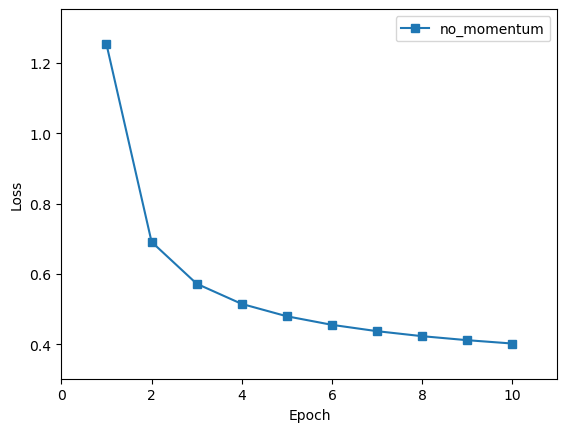

In [16]:
experiments_dict = {}
experiments_dict['no_momentum'] = (loss1, acc1)
plot_loss_and_acc(experiments_dict)

### 使用和不使用momentum的结果比较

In [23]:
import time 

start_time1 = time.time()

cfg_momentum = {
    'data_root': r'C:/Users/31393/Desktop/09d4e2b1-cb77-43d1-a527-b3a5b5f664f9/hw1/data',
    'max_epoch': 10,
    'batch_size': 100,
    'learning_rate': 0.01,
    'momentum': 0.9,  
    'display_freq': 50,
}

runner_momentum = Solver(cfg_momentum)
loss2, acc2 = runner_momentum.train()

end_time1 = time.time()

# 计算代码运行时间
run_time_momentum = end_time1 - start_time1

print(f"有momentum代码运行时间: {run_time_momentum}秒")

Epoch [0][10]	 Batch [0][550]	 Training Loss 2.4919	 Accuracy 0.0600
Epoch [0][10]	 Batch [50][550]	 Training Loss 0.9707	 Accuracy 0.7200
Epoch [0][10]	 Batch [100][550]	 Training Loss 0.6454	 Accuracy 0.8600
Epoch [0][10]	 Batch [150][550]	 Training Loss 0.5067	 Accuracy 0.8700
Epoch [0][10]	 Batch [200][550]	 Training Loss 0.5237	 Accuracy 0.8600
Epoch [0][10]	 Batch [250][550]	 Training Loss 0.3827	 Accuracy 0.8800
Epoch [0][10]	 Batch [300][550]	 Training Loss 0.4239	 Accuracy 0.8600
Epoch [0][10]	 Batch [350][550]	 Training Loss 0.4864	 Accuracy 0.8300
Epoch [0][10]	 Batch [400][550]	 Training Loss 0.4257	 Accuracy 0.8900
Epoch [0][10]	 Batch [450][550]	 Training Loss 0.4615	 Accuracy 0.9000
Epoch [0][10]	 Batch [500][550]	 Training Loss 0.3367	 Accuracy 0.9200

Epoch [0]	 Average training loss 0.5803	 Average training accuracy 0.8421
Epoch [0]	 Average validation loss 0.3134	 Average validation accuracy 0.9196

Epoch [1][10]	 Batch [0][550]	 Training Loss 0.4014	 Accuracy 0.9000


Epoch [8]	 Average training loss 0.2957	 Average training accuracy 0.9169
Epoch [8]	 Average validation loss 0.2367	 Average validation accuracy 0.9352

Epoch [9][10]	 Batch [0][550]	 Training Loss 0.2698	 Accuracy 0.9200
Epoch [9][10]	 Batch [50][550]	 Training Loss 0.2447	 Accuracy 0.9400
Epoch [9][10]	 Batch [100][550]	 Training Loss 0.2662	 Accuracy 0.9300
Epoch [9][10]	 Batch [150][550]	 Training Loss 0.2922	 Accuracy 0.9100
Epoch [9][10]	 Batch [200][550]	 Training Loss 0.2882	 Accuracy 0.9200
Epoch [9][10]	 Batch [250][550]	 Training Loss 0.4406	 Accuracy 0.9300
Epoch [9][10]	 Batch [300][550]	 Training Loss 0.4331	 Accuracy 0.8900
Epoch [9][10]	 Batch [350][550]	 Training Loss 0.1772	 Accuracy 0.9500
Epoch [9][10]	 Batch [400][550]	 Training Loss 0.2928	 Accuracy 0.8700
Epoch [9][10]	 Batch [450][550]	 Training Loss 0.2791	 Accuracy 0.9300
Epoch [9][10]	 Batch [500][550]	 Training Loss 0.1217	 Accuracy 0.9700

Epoch [9]	 Average training loss 0.2924	 Average training accuracy 

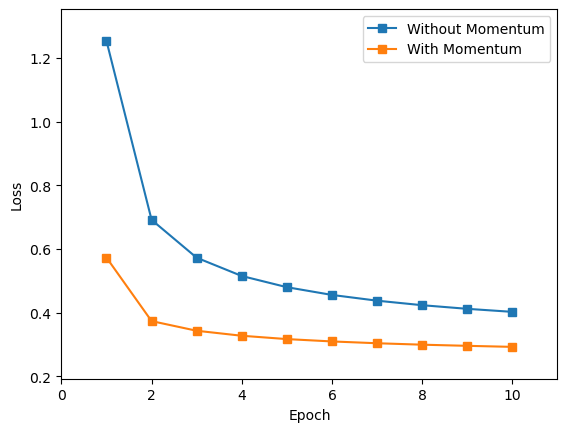

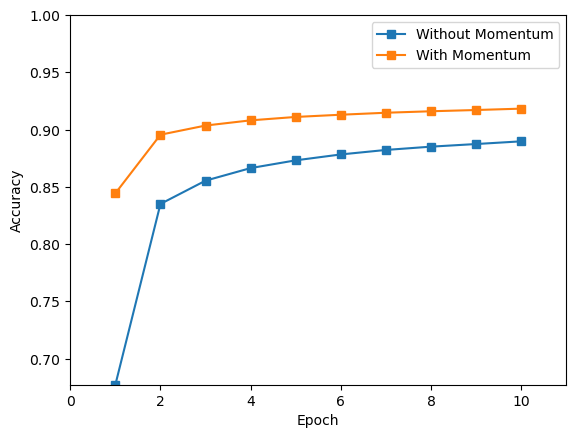

In [18]:
loss_and_acc_dict = {
    "Without Momentum": (loss1, acc1),
    "With Momentum": (loss2, acc2)
}
plot_loss_and_acc(loss_and_acc_dict)

### 调整超参数(momentum, 学习率, batchsize等), 观察如何影响分类性能


Training with learning rate: 0.1, batch size: 10, momentum: 0.5
Epoch [0][10]	 Batch [0][5500]	 Training Loss 2.7819	 Accuracy 0.1000
Epoch [0][10]	 Batch [50][5500]	 Training Loss 0.4895	 Accuracy 0.7000
Epoch [0][10]	 Batch [100][5500]	 Training Loss 0.6311	 Accuracy 0.8000
Epoch [0][10]	 Batch [150][5500]	 Training Loss 0.5987	 Accuracy 0.9000
Epoch [0][10]	 Batch [200][5500]	 Training Loss 0.3779	 Accuracy 0.9000
Epoch [0][10]	 Batch [250][5500]	 Training Loss 0.1460	 Accuracy 1.0000
Epoch [0][10]	 Batch [300][5500]	 Training Loss 0.2264	 Accuracy 0.9000
Epoch [0][10]	 Batch [350][5500]	 Training Loss 0.4309	 Accuracy 0.8000
Epoch [0][10]	 Batch [400][5500]	 Training Loss 0.1156	 Accuracy 1.0000
Epoch [0][10]	 Batch [450][5500]	 Training Loss 0.1899	 Accuracy 0.9000
Epoch [0][10]	 Batch [500][5500]	 Training Loss 0.2208	 Accuracy 0.9000
Epoch [0][10]	 Batch [550][5500]	 Training Loss 0.6438	 Accuracy 0.8000
Epoch [0][10]	 Batch [600][5500]	 Training Loss 0.2920	 Accuracy 0.9000
Ep

Epoch [1][10]	 Batch [150][5500]	 Training Loss 0.0458	 Accuracy 1.0000
Epoch [1][10]	 Batch [200][5500]	 Training Loss 0.0793	 Accuracy 1.0000
Epoch [1][10]	 Batch [250][5500]	 Training Loss 0.2064	 Accuracy 0.9000
Epoch [1][10]	 Batch [300][5500]	 Training Loss 0.7999	 Accuracy 0.7000
Epoch [1][10]	 Batch [350][5500]	 Training Loss 0.8763	 Accuracy 0.9000
Epoch [1][10]	 Batch [400][5500]	 Training Loss 0.1220	 Accuracy 0.9000
Epoch [1][10]	 Batch [450][5500]	 Training Loss 0.3513	 Accuracy 0.9000
Epoch [1][10]	 Batch [500][5500]	 Training Loss 0.7290	 Accuracy 0.9000
Epoch [1][10]	 Batch [550][5500]	 Training Loss 0.0400	 Accuracy 1.0000
Epoch [1][10]	 Batch [600][5500]	 Training Loss 0.5337	 Accuracy 0.8000
Epoch [1][10]	 Batch [650][5500]	 Training Loss 0.0450	 Accuracy 1.0000
Epoch [1][10]	 Batch [700][5500]	 Training Loss 0.2007	 Accuracy 0.9000
Epoch [1][10]	 Batch [750][5500]	 Training Loss 0.2275	 Accuracy 0.8000
Epoch [1][10]	 Batch [800][5500]	 Training Loss 0.4061	 Accuracy

Epoch [2][10]	 Batch [700][5500]	 Training Loss 0.4156	 Accuracy 0.9000
Epoch [2][10]	 Batch [750][5500]	 Training Loss 0.4440	 Accuracy 0.9000
Epoch [2][10]	 Batch [800][5500]	 Training Loss 0.5019	 Accuracy 0.9000
Epoch [2][10]	 Batch [850][5500]	 Training Loss 0.2684	 Accuracy 0.9000
Epoch [2][10]	 Batch [900][5500]	 Training Loss 0.0549	 Accuracy 1.0000
Epoch [2][10]	 Batch [950][5500]	 Training Loss 0.1765	 Accuracy 0.9000
Epoch [2][10]	 Batch [1000][5500]	 Training Loss 0.0878	 Accuracy 1.0000
Epoch [2][10]	 Batch [1050][5500]	 Training Loss 0.3025	 Accuracy 0.8000
Epoch [2][10]	 Batch [1100][5500]	 Training Loss 0.4090	 Accuracy 0.7000
Epoch [2][10]	 Batch [1150][5500]	 Training Loss 0.0326	 Accuracy 1.0000
Epoch [2][10]	 Batch [1200][5500]	 Training Loss 0.6124	 Accuracy 0.8000
Epoch [2][10]	 Batch [1250][5500]	 Training Loss 0.1995	 Accuracy 0.9000
Epoch [2][10]	 Batch [1300][5500]	 Training Loss 0.0730	 Accuracy 1.0000
Epoch [2][10]	 Batch [1350][5500]	 Training Loss 0.0506	 

Epoch [3][10]	 Batch [1350][5500]	 Training Loss 0.1763	 Accuracy 0.9000
Epoch [3][10]	 Batch [1400][5500]	 Training Loss 0.1435	 Accuracy 0.9000
Epoch [3][10]	 Batch [1450][5500]	 Training Loss 0.0944	 Accuracy 1.0000
Epoch [3][10]	 Batch [1500][5500]	 Training Loss 0.2081	 Accuracy 0.9000
Epoch [3][10]	 Batch [1550][5500]	 Training Loss 0.0180	 Accuracy 1.0000
Epoch [3][10]	 Batch [1600][5500]	 Training Loss 0.6273	 Accuracy 0.9000
Epoch [3][10]	 Batch [1650][5500]	 Training Loss 0.0160	 Accuracy 1.0000
Epoch [3][10]	 Batch [1700][5500]	 Training Loss 0.6336	 Accuracy 0.8000
Epoch [3][10]	 Batch [1750][5500]	 Training Loss 0.6951	 Accuracy 0.8000
Epoch [3][10]	 Batch [1800][5500]	 Training Loss 0.0217	 Accuracy 1.0000
Epoch [3][10]	 Batch [1850][5500]	 Training Loss 0.4091	 Accuracy 0.8000
Epoch [3][10]	 Batch [1900][5500]	 Training Loss 0.0407	 Accuracy 1.0000
Epoch [3][10]	 Batch [1950][5500]	 Training Loss 0.0663	 Accuracy 1.0000
Epoch [3][10]	 Batch [2000][5500]	 Training Loss 0.

Epoch [4][10]	 Batch [2100][5500]	 Training Loss 0.2639	 Accuracy 0.9000
Epoch [4][10]	 Batch [2150][5500]	 Training Loss 0.4786	 Accuracy 0.8000
Epoch [4][10]	 Batch [2200][5500]	 Training Loss 0.1742	 Accuracy 0.9000
Epoch [4][10]	 Batch [2250][5500]	 Training Loss 0.5791	 Accuracy 0.8000
Epoch [4][10]	 Batch [2300][5500]	 Training Loss 0.1445	 Accuracy 0.9000
Epoch [4][10]	 Batch [2350][5500]	 Training Loss 0.6511	 Accuracy 0.8000
Epoch [4][10]	 Batch [2400][5500]	 Training Loss 0.4634	 Accuracy 0.9000
Epoch [4][10]	 Batch [2450][5500]	 Training Loss 0.1455	 Accuracy 1.0000
Epoch [4][10]	 Batch [2500][5500]	 Training Loss 0.0550	 Accuracy 1.0000
Epoch [4][10]	 Batch [2550][5500]	 Training Loss 0.0508	 Accuracy 1.0000
Epoch [4][10]	 Batch [2600][5500]	 Training Loss 0.4097	 Accuracy 0.8000
Epoch [4][10]	 Batch [2650][5500]	 Training Loss 0.9964	 Accuracy 0.7000
Epoch [4][10]	 Batch [2700][5500]	 Training Loss 1.3155	 Accuracy 0.7000
Epoch [4][10]	 Batch [2750][5500]	 Training Loss 0.

Epoch [5][10]	 Batch [2700][5500]	 Training Loss 0.1178	 Accuracy 0.9000
Epoch [5][10]	 Batch [2750][5500]	 Training Loss 1.0548	 Accuracy 0.8000
Epoch [5][10]	 Batch [2800][5500]	 Training Loss 0.3185	 Accuracy 0.8000
Epoch [5][10]	 Batch [2850][5500]	 Training Loss 0.1370	 Accuracy 0.9000
Epoch [5][10]	 Batch [2900][5500]	 Training Loss 0.8555	 Accuracy 0.8000
Epoch [5][10]	 Batch [2950][5500]	 Training Loss 0.0504	 Accuracy 1.0000
Epoch [5][10]	 Batch [3000][5500]	 Training Loss 0.2242	 Accuracy 0.9000
Epoch [5][10]	 Batch [3050][5500]	 Training Loss 0.5267	 Accuracy 0.9000
Epoch [5][10]	 Batch [3100][5500]	 Training Loss 0.0563	 Accuracy 1.0000
Epoch [5][10]	 Batch [3150][5500]	 Training Loss 0.2399	 Accuracy 0.9000
Epoch [5][10]	 Batch [3200][5500]	 Training Loss 0.7521	 Accuracy 0.8000
Epoch [5][10]	 Batch [3250][5500]	 Training Loss 0.2038	 Accuracy 0.8000
Epoch [5][10]	 Batch [3300][5500]	 Training Loss 0.0181	 Accuracy 1.0000
Epoch [5][10]	 Batch [3350][5500]	 Training Loss 0.

Epoch [6][10]	 Batch [3200][5500]	 Training Loss 0.8975	 Accuracy 0.8000
Epoch [6][10]	 Batch [3250][5500]	 Training Loss 0.1665	 Accuracy 1.0000
Epoch [6][10]	 Batch [3300][5500]	 Training Loss 0.2190	 Accuracy 0.9000
Epoch [6][10]	 Batch [3350][5500]	 Training Loss 0.0303	 Accuracy 1.0000
Epoch [6][10]	 Batch [3400][5500]	 Training Loss 0.2045	 Accuracy 0.9000
Epoch [6][10]	 Batch [3450][5500]	 Training Loss 0.3458	 Accuracy 0.8000
Epoch [6][10]	 Batch [3500][5500]	 Training Loss 0.5328	 Accuracy 0.8000
Epoch [6][10]	 Batch [3550][5500]	 Training Loss 0.0474	 Accuracy 1.0000
Epoch [6][10]	 Batch [3600][5500]	 Training Loss 0.4382	 Accuracy 0.9000
Epoch [6][10]	 Batch [3650][5500]	 Training Loss 0.0026	 Accuracy 1.0000
Epoch [6][10]	 Batch [3700][5500]	 Training Loss 1.2194	 Accuracy 0.7000
Epoch [6][10]	 Batch [3750][5500]	 Training Loss 0.0572	 Accuracy 1.0000
Epoch [6][10]	 Batch [3800][5500]	 Training Loss 0.1229	 Accuracy 1.0000
Epoch [6][10]	 Batch [3850][5500]	 Training Loss 0.

Epoch [7][10]	 Batch [3250][5500]	 Training Loss 0.2166	 Accuracy 0.9000
Epoch [7][10]	 Batch [3300][5500]	 Training Loss 0.4550	 Accuracy 0.9000
Epoch [7][10]	 Batch [3350][5500]	 Training Loss 0.2037	 Accuracy 0.9000
Epoch [7][10]	 Batch [3400][5500]	 Training Loss 0.1028	 Accuracy 0.9000
Epoch [7][10]	 Batch [3450][5500]	 Training Loss 0.4126	 Accuracy 0.9000
Epoch [7][10]	 Batch [3500][5500]	 Training Loss 0.9750	 Accuracy 0.7000
Epoch [7][10]	 Batch [3550][5500]	 Training Loss 0.1716	 Accuracy 0.9000
Epoch [7][10]	 Batch [3600][5500]	 Training Loss 0.3033	 Accuracy 0.8000
Epoch [7][10]	 Batch [3650][5500]	 Training Loss 0.1286	 Accuracy 0.9000
Epoch [7][10]	 Batch [3700][5500]	 Training Loss 1.3715	 Accuracy 0.6000
Epoch [7][10]	 Batch [3750][5500]	 Training Loss 0.1845	 Accuracy 0.9000
Epoch [7][10]	 Batch [3800][5500]	 Training Loss 0.3121	 Accuracy 0.9000
Epoch [7][10]	 Batch [3850][5500]	 Training Loss 0.0158	 Accuracy 1.0000
Epoch [7][10]	 Batch [3900][5500]	 Training Loss 0.

Epoch [8][10]	 Batch [3500][5500]	 Training Loss 0.0445	 Accuracy 1.0000
Epoch [8][10]	 Batch [3550][5500]	 Training Loss 0.0134	 Accuracy 1.0000
Epoch [8][10]	 Batch [3600][5500]	 Training Loss 0.2009	 Accuracy 0.9000
Epoch [8][10]	 Batch [3650][5500]	 Training Loss 0.1859	 Accuracy 0.9000
Epoch [8][10]	 Batch [3700][5500]	 Training Loss 0.1151	 Accuracy 1.0000
Epoch [8][10]	 Batch [3750][5500]	 Training Loss 0.1735	 Accuracy 0.9000
Epoch [8][10]	 Batch [3800][5500]	 Training Loss 0.9220	 Accuracy 0.8000
Epoch [8][10]	 Batch [3850][5500]	 Training Loss 0.7836	 Accuracy 0.9000
Epoch [8][10]	 Batch [3900][5500]	 Training Loss 0.0191	 Accuracy 1.0000
Epoch [8][10]	 Batch [3950][5500]	 Training Loss 0.0148	 Accuracy 1.0000
Epoch [8][10]	 Batch [4000][5500]	 Training Loss 0.2512	 Accuracy 0.9000
Epoch [8][10]	 Batch [4050][5500]	 Training Loss 0.1716	 Accuracy 1.0000
Epoch [8][10]	 Batch [4100][5500]	 Training Loss 0.2464	 Accuracy 0.9000
Epoch [8][10]	 Batch [4150][5500]	 Training Loss 0.

Epoch [9][10]	 Batch [3950][5500]	 Training Loss 1.1242	 Accuracy 0.9000
Epoch [9][10]	 Batch [4000][5500]	 Training Loss 0.0976	 Accuracy 0.9000
Epoch [9][10]	 Batch [4050][5500]	 Training Loss 0.2732	 Accuracy 0.8000
Epoch [9][10]	 Batch [4100][5500]	 Training Loss 0.0507	 Accuracy 1.0000
Epoch [9][10]	 Batch [4150][5500]	 Training Loss 0.3302	 Accuracy 0.9000
Epoch [9][10]	 Batch [4200][5500]	 Training Loss 0.1110	 Accuracy 0.9000
Epoch [9][10]	 Batch [4250][5500]	 Training Loss 0.1471	 Accuracy 1.0000
Epoch [9][10]	 Batch [4300][5500]	 Training Loss 0.3315	 Accuracy 0.9000
Epoch [9][10]	 Batch [4350][5500]	 Training Loss 0.0451	 Accuracy 1.0000
Epoch [9][10]	 Batch [4400][5500]	 Training Loss 0.0463	 Accuracy 1.0000
Epoch [9][10]	 Batch [4450][5500]	 Training Loss 0.4378	 Accuracy 0.8000
Epoch [9][10]	 Batch [4500][5500]	 Training Loss 0.1913	 Accuracy 0.9000
Epoch [9][10]	 Batch [4550][5500]	 Training Loss 0.0490	 Accuracy 1.0000
Epoch [9][10]	 Batch [4600][5500]	 Training Loss 0.

Epoch [0][10]	 Batch [4150][5500]	 Training Loss 1.1228	 Accuracy 0.9000
Epoch [0][10]	 Batch [4200][5500]	 Training Loss 0.3803	 Accuracy 0.9000
Epoch [0][10]	 Batch [4250][5500]	 Training Loss 0.0428	 Accuracy 1.0000
Epoch [0][10]	 Batch [4300][5500]	 Training Loss 0.4276	 Accuracy 0.8000
Epoch [0][10]	 Batch [4350][5500]	 Training Loss 0.0034	 Accuracy 1.0000
Epoch [0][10]	 Batch [4400][5500]	 Training Loss 0.6179	 Accuracy 0.9000
Epoch [0][10]	 Batch [4450][5500]	 Training Loss 1.6009	 Accuracy 0.8000
Epoch [0][10]	 Batch [4500][5500]	 Training Loss 0.0010	 Accuracy 1.0000
Epoch [0][10]	 Batch [4550][5500]	 Training Loss 0.0761	 Accuracy 1.0000
Epoch [0][10]	 Batch [4600][5500]	 Training Loss 0.5604	 Accuracy 0.9000
Epoch [0][10]	 Batch [4650][5500]	 Training Loss 2.2411	 Accuracy 0.9000
Epoch [0][10]	 Batch [4700][5500]	 Training Loss 0.8244	 Accuracy 0.9000
Epoch [0][10]	 Batch [4750][5500]	 Training Loss 0.1194	 Accuracy 0.9000
Epoch [0][10]	 Batch [4800][5500]	 Training Loss 2.

Epoch [1][10]	 Batch [4200][5500]	 Training Loss 0.0034	 Accuracy 1.0000
Epoch [1][10]	 Batch [4250][5500]	 Training Loss 0.0095	 Accuracy 1.0000
Epoch [1][10]	 Batch [4300][5500]	 Training Loss 0.0051	 Accuracy 1.0000
Epoch [1][10]	 Batch [4350][5500]	 Training Loss 0.1350	 Accuracy 0.9000
Epoch [1][10]	 Batch [4400][5500]	 Training Loss 1.2262	 Accuracy 0.8000
Epoch [1][10]	 Batch [4450][5500]	 Training Loss 1.1689	 Accuracy 0.8000
Epoch [1][10]	 Batch [4500][5500]	 Training Loss 0.1770	 Accuracy 1.0000
Epoch [1][10]	 Batch [4550][5500]	 Training Loss 0.0009	 Accuracy 1.0000
Epoch [1][10]	 Batch [4600][5500]	 Training Loss 0.0002	 Accuracy 1.0000
Epoch [1][10]	 Batch [4650][5500]	 Training Loss 1.3435	 Accuracy 0.7000
Epoch [1][10]	 Batch [4700][5500]	 Training Loss 1.3680	 Accuracy 0.9000
Epoch [1][10]	 Batch [4750][5500]	 Training Loss 0.0576	 Accuracy 1.0000
Epoch [1][10]	 Batch [4800][5500]	 Training Loss 0.0255	 Accuracy 1.0000
Epoch [1][10]	 Batch [4850][5500]	 Training Loss 1.

Epoch [2][10]	 Batch [4850][5500]	 Training Loss 0.0980	 Accuracy 0.9000
Epoch [2][10]	 Batch [4900][5500]	 Training Loss 0.1147	 Accuracy 0.9000
Epoch [2][10]	 Batch [4950][5500]	 Training Loss 0.0032	 Accuracy 1.0000
Epoch [2][10]	 Batch [5000][5500]	 Training Loss 0.9122	 Accuracy 0.9000
Epoch [2][10]	 Batch [5050][5500]	 Training Loss 0.2971	 Accuracy 0.9000
Epoch [2][10]	 Batch [5100][5500]	 Training Loss 0.6467	 Accuracy 0.8000
Epoch [2][10]	 Batch [5150][5500]	 Training Loss 4.7158	 Accuracy 0.5000
Epoch [2][10]	 Batch [5200][5500]	 Training Loss 0.7665	 Accuracy 0.8000
Epoch [2][10]	 Batch [5250][5500]	 Training Loss 1.2463	 Accuracy 0.9000
Epoch [2][10]	 Batch [5300][5500]	 Training Loss 0.2092	 Accuracy 0.9000
Epoch [2][10]	 Batch [5350][5500]	 Training Loss 0.7887	 Accuracy 0.8000
Epoch [2][10]	 Batch [5400][5500]	 Training Loss 0.4159	 Accuracy 0.9000
Epoch [2][10]	 Batch [5450][5500]	 Training Loss 1.1487	 Accuracy 0.9000

Epoch [2]	 Average training loss 0.7210	 Average t

Epoch [3][10]	 Batch [5350][5500]	 Training Loss 0.0193	 Accuracy 1.0000
Epoch [3][10]	 Batch [5400][5500]	 Training Loss 0.1305	 Accuracy 0.9000
Epoch [3][10]	 Batch [5450][5500]	 Training Loss 0.8441	 Accuracy 0.9000

Epoch [3]	 Average training loss 0.7212	 Average training accuracy 0.8840
Epoch [3]	 Average validation loss 0.5613	 Average validation accuracy 0.9094

Epoch [4][10]	 Batch [0][5500]	 Training Loss 0.0031	 Accuracy 1.0000
Epoch [4][10]	 Batch [50][5500]	 Training Loss 0.2540	 Accuracy 0.9000
Epoch [4][10]	 Batch [100][5500]	 Training Loss 0.5541	 Accuracy 0.9000
Epoch [4][10]	 Batch [150][5500]	 Training Loss 0.0537	 Accuracy 1.0000
Epoch [4][10]	 Batch [200][5500]	 Training Loss 1.6983	 Accuracy 0.8000
Epoch [4][10]	 Batch [250][5500]	 Training Loss 0.4728	 Accuracy 0.9000
Epoch [4][10]	 Batch [300][5500]	 Training Loss 0.1489	 Accuracy 0.9000
Epoch [4][10]	 Batch [350][5500]	 Training Loss 2.4269	 Accuracy 0.7000
Epoch [4][10]	 Batch [400][5500]	 Training Loss 0.0763

Epoch [5][10]	 Batch [0][5500]	 Training Loss 0.6731	 Accuracy 0.7000
Epoch [5][10]	 Batch [50][5500]	 Training Loss 0.9288	 Accuracy 0.9000
Epoch [5][10]	 Batch [100][5500]	 Training Loss 0.3763	 Accuracy 0.9000
Epoch [5][10]	 Batch [150][5500]	 Training Loss 1.9533	 Accuracy 0.7000
Epoch [5][10]	 Batch [200][5500]	 Training Loss 0.0071	 Accuracy 1.0000
Epoch [5][10]	 Batch [250][5500]	 Training Loss 0.0900	 Accuracy 0.9000
Epoch [5][10]	 Batch [300][5500]	 Training Loss 1.5267	 Accuracy 0.8000
Epoch [5][10]	 Batch [350][5500]	 Training Loss 0.0710	 Accuracy 1.0000
Epoch [5][10]	 Batch [400][5500]	 Training Loss 1.1187	 Accuracy 0.8000
Epoch [5][10]	 Batch [450][5500]	 Training Loss 1.5927	 Accuracy 0.9000
Epoch [5][10]	 Batch [500][5500]	 Training Loss 0.0081	 Accuracy 1.0000
Epoch [5][10]	 Batch [550][5500]	 Training Loss 0.0045	 Accuracy 1.0000
Epoch [5][10]	 Batch [600][5500]	 Training Loss 0.0639	 Accuracy 1.0000
Epoch [5][10]	 Batch [650][5500]	 Training Loss 1.5283	 Accuracy 0.

Epoch [6][10]	 Batch [750][5500]	 Training Loss 0.0006	 Accuracy 1.0000
Epoch [6][10]	 Batch [800][5500]	 Training Loss 0.6480	 Accuracy 0.8000
Epoch [6][10]	 Batch [850][5500]	 Training Loss 1.4176	 Accuracy 0.8000
Epoch [6][10]	 Batch [900][5500]	 Training Loss 0.4395	 Accuracy 0.9000
Epoch [6][10]	 Batch [950][5500]	 Training Loss 0.8828	 Accuracy 0.8000
Epoch [6][10]	 Batch [1000][5500]	 Training Loss 0.0008	 Accuracy 1.0000
Epoch [6][10]	 Batch [1050][5500]	 Training Loss 1.4230	 Accuracy 0.8000
Epoch [6][10]	 Batch [1100][5500]	 Training Loss 0.6312	 Accuracy 0.8000
Epoch [6][10]	 Batch [1150][5500]	 Training Loss 0.0127	 Accuracy 1.0000
Epoch [6][10]	 Batch [1200][5500]	 Training Loss 0.4385	 Accuracy 0.9000
Epoch [6][10]	 Batch [1250][5500]	 Training Loss 0.1619	 Accuracy 0.8000
Epoch [6][10]	 Batch [1300][5500]	 Training Loss 1.7958	 Accuracy 0.7000
Epoch [6][10]	 Batch [1350][5500]	 Training Loss 1.2498	 Accuracy 0.9000
Epoch [6][10]	 Batch [1400][5500]	 Training Loss 0.7285	

Epoch [7][10]	 Batch [1400][5500]	 Training Loss 0.2292	 Accuracy 0.8000
Epoch [7][10]	 Batch [1450][5500]	 Training Loss 1.6099	 Accuracy 0.7000
Epoch [7][10]	 Batch [1500][5500]	 Training Loss 0.2632	 Accuracy 0.9000
Epoch [7][10]	 Batch [1550][5500]	 Training Loss 1.2336	 Accuracy 0.9000
Epoch [7][10]	 Batch [1600][5500]	 Training Loss 1.3078	 Accuracy 0.9000
Epoch [7][10]	 Batch [1650][5500]	 Training Loss 0.0028	 Accuracy 1.0000
Epoch [7][10]	 Batch [1700][5500]	 Training Loss 0.0467	 Accuracy 1.0000
Epoch [7][10]	 Batch [1750][5500]	 Training Loss 0.1953	 Accuracy 0.9000
Epoch [7][10]	 Batch [1800][5500]	 Training Loss 1.8654	 Accuracy 0.8000
Epoch [7][10]	 Batch [1850][5500]	 Training Loss 0.0422	 Accuracy 1.0000
Epoch [7][10]	 Batch [1900][5500]	 Training Loss 1.1621	 Accuracy 0.8000
Epoch [7][10]	 Batch [1950][5500]	 Training Loss 1.4248	 Accuracy 0.8000
Epoch [7][10]	 Batch [2000][5500]	 Training Loss 0.1682	 Accuracy 0.9000
Epoch [7][10]	 Batch [2050][5500]	 Training Loss 1.

Epoch [8][10]	 Batch [2000][5500]	 Training Loss 1.0637	 Accuracy 0.9000
Epoch [8][10]	 Batch [2050][5500]	 Training Loss 0.8982	 Accuracy 0.8000
Epoch [8][10]	 Batch [2100][5500]	 Training Loss 0.9510	 Accuracy 0.7000
Epoch [8][10]	 Batch [2150][5500]	 Training Loss 0.0495	 Accuracy 1.0000
Epoch [8][10]	 Batch [2200][5500]	 Training Loss 0.0241	 Accuracy 1.0000
Epoch [8][10]	 Batch [2250][5500]	 Training Loss 1.4555	 Accuracy 0.7000
Epoch [8][10]	 Batch [2300][5500]	 Training Loss 0.3233	 Accuracy 0.9000
Epoch [8][10]	 Batch [2350][5500]	 Training Loss 1.5725	 Accuracy 0.7000
Epoch [8][10]	 Batch [2400][5500]	 Training Loss 0.0006	 Accuracy 1.0000
Epoch [8][10]	 Batch [2450][5500]	 Training Loss 0.3824	 Accuracy 0.8000
Epoch [8][10]	 Batch [2500][5500]	 Training Loss 0.0001	 Accuracy 1.0000
Epoch [8][10]	 Batch [2550][5500]	 Training Loss 0.3056	 Accuracy 0.9000
Epoch [8][10]	 Batch [2600][5500]	 Training Loss 0.0238	 Accuracy 1.0000
Epoch [8][10]	 Batch [2650][5500]	 Training Loss 0.

Epoch [9][10]	 Batch [2350][5500]	 Training Loss 0.1802	 Accuracy 0.8000
Epoch [9][10]	 Batch [2400][5500]	 Training Loss 2.2457	 Accuracy 0.8000
Epoch [9][10]	 Batch [2450][5500]	 Training Loss 2.0118	 Accuracy 0.8000
Epoch [9][10]	 Batch [2500][5500]	 Training Loss 0.1098	 Accuracy 0.9000
Epoch [9][10]	 Batch [2550][5500]	 Training Loss 0.4499	 Accuracy 0.9000
Epoch [9][10]	 Batch [2600][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [9][10]	 Batch [2650][5500]	 Training Loss 0.0859	 Accuracy 1.0000
Epoch [9][10]	 Batch [2700][5500]	 Training Loss 1.8578	 Accuracy 0.8000
Epoch [9][10]	 Batch [2750][5500]	 Training Loss 1.2897	 Accuracy 0.8000
Epoch [9][10]	 Batch [2800][5500]	 Training Loss 1.0107	 Accuracy 0.9000
Epoch [9][10]	 Batch [2850][5500]	 Training Loss 0.0234	 Accuracy 1.0000
Epoch [9][10]	 Batch [2900][5500]	 Training Loss 0.9536	 Accuracy 0.9000
Epoch [9][10]	 Batch [2950][5500]	 Training Loss 0.5505	 Accuracy 0.9000
Epoch [9][10]	 Batch [3000][5500]	 Training Loss 0.

Epoch [0][10]	 Batch [2650][5500]	 Training Loss 0.5560	 Accuracy 0.9000
Epoch [0][10]	 Batch [2700][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [0][10]	 Batch [2750][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [0][10]	 Batch [2800][5500]	 Training Loss 10.1314	 Accuracy 0.6000
Epoch [0][10]	 Batch [2850][5500]	 Training Loss 7.5985	 Accuracy 0.7000
Epoch [0][10]	 Batch [2900][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [0][10]	 Batch [2950][5500]	 Training Loss 4.2991	 Accuracy 0.8000
Epoch [0][10]	 Batch [3000][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [0][10]	 Batch [3050][5500]	 Training Loss 3.8589	 Accuracy 0.8000
Epoch [0][10]	 Batch [3100][5500]	 Training Loss 8.3297	 Accuracy 0.6000
Epoch [0][10]	 Batch [3150][5500]	 Training Loss 5.0657	 Accuracy 0.8000
Epoch [0][10]	 Batch [3200][5500]	 Training Loss 5.0657	 Accuracy 0.8000
Epoch [0][10]	 Batch [3250][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [0][10]	 Batch [3300][5500]	 Training Loss 2

Epoch [1][10]	 Batch [2900][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [1][10]	 Batch [2950][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [1][10]	 Batch [3000][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [1][10]	 Batch [3050][5500]	 Training Loss 0.4774	 Accuracy 0.9000
Epoch [1][10]	 Batch [3100][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [1][10]	 Batch [3150][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [1][10]	 Batch [3200][5500]	 Training Loss 0.0072	 Accuracy 1.0000
Epoch [1][10]	 Batch [3250][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [1][10]	 Batch [3300][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [1][10]	 Batch [3350][5500]	 Training Loss 1.3445	 Accuracy 0.9000
Epoch [1][10]	 Batch [3400][5500]	 Training Loss 0.0001	 Accuracy 1.0000
Epoch [1][10]	 Batch [3450][5500]	 Training Loss 5.0657	 Accuracy 0.8000
Epoch [1][10]	 Batch [3500][5500]	 Training Loss 1.8046	 Accuracy 0.9000
Epoch [1][10]	 Batch [3550][5500]	 Training Loss 0.

Epoch [2][10]	 Batch [3300][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [2][10]	 Batch [3350][5500]	 Training Loss 5.0657	 Accuracy 0.8000
Epoch [2][10]	 Batch [3400][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [2][10]	 Batch [3450][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [2][10]	 Batch [3500][5500]	 Training Loss 7.5985	 Accuracy 0.7000
Epoch [2][10]	 Batch [3550][5500]	 Training Loss 2.9399	 Accuracy 0.8000
Epoch [2][10]	 Batch [3600][5500]	 Training Loss 0.9733	 Accuracy 0.9000
Epoch [2][10]	 Batch [3650][5500]	 Training Loss 5.0657	 Accuracy 0.8000
Epoch [2][10]	 Batch [3700][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [2][10]	 Batch [3750][5500]	 Training Loss 4.4248	 Accuracy 0.7000
Epoch [2][10]	 Batch [3800][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [2][10]	 Batch [3850][5500]	 Training Loss 2.5540	 Accuracy 0.9000
Epoch [2][10]	 Batch [3900][5500]	 Training Loss 0.9447	 Accuracy 0.8000
Epoch [2][10]	 Batch [3950][5500]	 Training Loss 0.

Epoch [3][10]	 Batch [4050][5500]	 Training Loss 7.5985	 Accuracy 0.7000
Epoch [3][10]	 Batch [4100][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [3][10]	 Batch [4150][5500]	 Training Loss 2.5330	 Accuracy 0.9000
Epoch [3][10]	 Batch [4200][5500]	 Training Loss 1.8576	 Accuracy 0.9000
Epoch [3][10]	 Batch [4250][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [3][10]	 Batch [4300][5500]	 Training Loss 2.4983	 Accuracy 0.9000
Epoch [3][10]	 Batch [4350][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [3][10]	 Batch [4400][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [3][10]	 Batch [4450][5500]	 Training Loss 4.4405	 Accuracy 0.8000
Epoch [3][10]	 Batch [4500][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [3][10]	 Batch [4550][5500]	 Training Loss 1.8161	 Accuracy 0.9000
Epoch [3][10]	 Batch [4600][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [3][10]	 Batch [4650][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [3][10]	 Batch [4700][5500]	 Training Loss 0.

Epoch [4][10]	 Batch [4600][5500]	 Training Loss 2.9254	 Accuracy 0.7000
Epoch [4][10]	 Batch [4650][5500]	 Training Loss 9.8402	 Accuracy 0.6000
Epoch [4][10]	 Batch [4700][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [4][10]	 Batch [4750][5500]	 Training Loss 2.5336	 Accuracy 0.9000
Epoch [4][10]	 Batch [4800][5500]	 Training Loss 2.6564	 Accuracy 0.8000
Epoch [4][10]	 Batch [4850][5500]	 Training Loss 3.5391	 Accuracy 0.8000
Epoch [4][10]	 Batch [4900][5500]	 Training Loss 0.0001	 Accuracy 1.0000
Epoch [4][10]	 Batch [4950][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [4][10]	 Batch [5000][5500]	 Training Loss 4.7269	 Accuracy 0.8000
Epoch [4][10]	 Batch [5050][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [4][10]	 Batch [5100][5500]	 Training Loss 5.0657	 Accuracy 0.8000
Epoch [4][10]	 Batch [5150][5500]	 Training Loss 2.5922	 Accuracy 0.9000
Epoch [4][10]	 Batch [5200][5500]	 Training Loss 2.5230	 Accuracy 0.9000
Epoch [4][10]	 Batch [5250][5500]	 Training Loss 1.

Epoch [5][10]	 Batch [4800][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [5][10]	 Batch [4850][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [5][10]	 Batch [4900][5500]	 Training Loss 7.7974	 Accuracy 0.6000
Epoch [5][10]	 Batch [4950][5500]	 Training Loss 2.5921	 Accuracy 0.8000
Epoch [5][10]	 Batch [5000][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [5][10]	 Batch [5050][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [5][10]	 Batch [5100][5500]	 Training Loss 7.5985	 Accuracy 0.7000
Epoch [5][10]	 Batch [5150][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [5][10]	 Batch [5200][5500]	 Training Loss 3.6325	 Accuracy 0.8000
Epoch [5][10]	 Batch [5250][5500]	 Training Loss 3.2781	 Accuracy 0.8000
Epoch [5][10]	 Batch [5300][5500]	 Training Loss 1.2331	 Accuracy 0.9000
Epoch [5][10]	 Batch [5350][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [5][10]	 Batch [5400][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [5][10]	 Batch [5450][5500]	 Training Loss 0.

Epoch [6][10]	 Batch [4900][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [6][10]	 Batch [4950][5500]	 Training Loss 3.6098	 Accuracy 0.8000
Epoch [6][10]	 Batch [5000][5500]	 Training Loss 0.4068	 Accuracy 0.9000
Epoch [6][10]	 Batch [5050][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [6][10]	 Batch [5100][5500]	 Training Loss 10.1314	 Accuracy 0.6000
Epoch [6][10]	 Batch [5150][5500]	 Training Loss 2.3668	 Accuracy 0.9000
Epoch [6][10]	 Batch [5200][5500]	 Training Loss 5.0631	 Accuracy 0.8000
Epoch [6][10]	 Batch [5250][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [6][10]	 Batch [5300][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [6][10]	 Batch [5350][5500]	 Training Loss 2.1405	 Accuracy 0.9000
Epoch [6][10]	 Batch [5400][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [6][10]	 Batch [5450][5500]	 Training Loss 2.5328	 Accuracy 0.9000

Epoch [6]	 Average training loss 2.4653	 Average training accuracy 0.8813
Epoch [6]	 Average validation loss 2.2788	 Avera


Epoch [7]	 Average training loss 2.4869	 Average training accuracy 0.8820
Epoch [7]	 Average validation loss 1.7419	 Average validation accuracy 0.9130

Epoch [8][10]	 Batch [0][5500]	 Training Loss 5.3908	 Accuracy 0.7000
Epoch [8][10]	 Batch [50][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [8][10]	 Batch [100][5500]	 Training Loss 7.5985	 Accuracy 0.7000
Epoch [8][10]	 Batch [150][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [8][10]	 Batch [200][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [8][10]	 Batch [250][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [8][10]	 Batch [300][5500]	 Training Loss 5.0699	 Accuracy 0.8000
Epoch [8][10]	 Batch [350][5500]	 Training Loss 4.8507	 Accuracy 0.7000
Epoch [8][10]	 Batch [400][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [8][10]	 Batch [450][5500]	 Training Loss 3.1549	 Accuracy 0.8000
Epoch [8][10]	 Batch [500][5500]	 Training Loss 4.6470	 Accuracy 0.8000
Epoch [8][10]	 Batch [550][5500]	 Training Loss 0.0000	 A

Epoch [9][10]	 Batch [600][5500]	 Training Loss 6.4351	 Accuracy 0.7000
Epoch [9][10]	 Batch [650][5500]	 Training Loss 2.5623	 Accuracy 0.9000
Epoch [9][10]	 Batch [700][5500]	 Training Loss 5.0653	 Accuracy 0.8000
Epoch [9][10]	 Batch [750][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [9][10]	 Batch [800][5500]	 Training Loss 1.1324	 Accuracy 0.9000
Epoch [9][10]	 Batch [850][5500]	 Training Loss 4.0598	 Accuracy 0.8000
Epoch [9][10]	 Batch [900][5500]	 Training Loss 1.7829	 Accuracy 0.8000
Epoch [9][10]	 Batch [950][5500]	 Training Loss 5.0657	 Accuracy 0.8000
Epoch [9][10]	 Batch [1000][5500]	 Training Loss 0.0016	 Accuracy 1.0000
Epoch [9][10]	 Batch [1050][5500]	 Training Loss 4.3902	 Accuracy 0.8000
Epoch [9][10]	 Batch [1100][5500]	 Training Loss 2.5328	 Accuracy 0.9000
Epoch [9][10]	 Batch [1150][5500]	 Training Loss 5.0657	 Accuracy 0.8000
Epoch [9][10]	 Batch [1200][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [9][10]	 Batch [1250][5500]	 Training Loss 2.5328	 Ac

Epoch [0][10]	 Batch [750][1100]	 Training Loss 0.2535	 Accuracy 0.9400
Epoch [0][10]	 Batch [800][1100]	 Training Loss 0.4383	 Accuracy 0.9400
Epoch [0][10]	 Batch [850][1100]	 Training Loss 0.4497	 Accuracy 0.8400
Epoch [0][10]	 Batch [900][1100]	 Training Loss 0.3203	 Accuracy 0.8800
Epoch [0][10]	 Batch [950][1100]	 Training Loss 0.4182	 Accuracy 0.8600
Epoch [0][10]	 Batch [1000][1100]	 Training Loss 0.2881	 Accuracy 0.9000
Epoch [0][10]	 Batch [1050][1100]	 Training Loss 0.2885	 Accuracy 0.9200

Epoch [0]	 Average training loss 0.4152	 Average training accuracy 0.8842
Epoch [0]	 Average validation loss 0.2602	 Average validation accuracy 0.9302

Epoch [1][10]	 Batch [0][1100]	 Training Loss 0.2352	 Accuracy 0.9200
Epoch [1][10]	 Batch [50][1100]	 Training Loss 0.1587	 Accuracy 0.9400
Epoch [1][10]	 Batch [100][1100]	 Training Loss 0.4127	 Accuracy 0.9200
Epoch [1][10]	 Batch [150][1100]	 Training Loss 0.1727	 Accuracy 0.9800
Epoch [1][10]	 Batch [200][1100]	 Training Loss 0.1666	

Epoch [5][10]	 Batch [600][1100]	 Training Loss 0.1638	 Accuracy 0.9600
Epoch [5][10]	 Batch [650][1100]	 Training Loss 0.2729	 Accuracy 0.8800
Epoch [5][10]	 Batch [700][1100]	 Training Loss 0.2674	 Accuracy 0.9600
Epoch [5][10]	 Batch [750][1100]	 Training Loss 0.3661	 Accuracy 0.9200
Epoch [5][10]	 Batch [800][1100]	 Training Loss 0.1478	 Accuracy 0.9600
Epoch [5][10]	 Batch [850][1100]	 Training Loss 0.1429	 Accuracy 0.9600
Epoch [5][10]	 Batch [900][1100]	 Training Loss 0.3503	 Accuracy 0.9400
Epoch [5][10]	 Batch [950][1100]	 Training Loss 0.3208	 Accuracy 0.9400
Epoch [5][10]	 Batch [1000][1100]	 Training Loss 0.6024	 Accuracy 0.8800
Epoch [5][10]	 Batch [1050][1100]	 Training Loss 0.1673	 Accuracy 0.9400

Epoch [5]	 Average training loss 0.2809	 Average training accuracy 0.9211
Epoch [5]	 Average validation loss 0.2270	 Average validation accuracy 0.9386

Epoch [6][10]	 Batch [0][1100]	 Training Loss 0.1230	 Accuracy 0.9800
Epoch [6][10]	 Batch [50][1100]	 Training Loss 0.1698	

Epoch [0][10]	 Batch [300][1100]	 Training Loss 0.2064	 Accuracy 0.9200
Epoch [0][10]	 Batch [350][1100]	 Training Loss 0.1300	 Accuracy 0.9800
Epoch [0][10]	 Batch [400][1100]	 Training Loss 0.5879	 Accuracy 0.8200
Epoch [0][10]	 Batch [450][1100]	 Training Loss 0.3061	 Accuracy 0.9200
Epoch [0][10]	 Batch [500][1100]	 Training Loss 0.5459	 Accuracy 0.8600
Epoch [0][10]	 Batch [550][1100]	 Training Loss 0.3462	 Accuracy 0.8800
Epoch [0][10]	 Batch [600][1100]	 Training Loss 0.5482	 Accuracy 0.8800
Epoch [0][10]	 Batch [650][1100]	 Training Loss 0.2433	 Accuracy 0.9400
Epoch [0][10]	 Batch [700][1100]	 Training Loss 0.1624	 Accuracy 0.9200
Epoch [0][10]	 Batch [750][1100]	 Training Loss 0.1408	 Accuracy 0.9200
Epoch [0][10]	 Batch [800][1100]	 Training Loss 0.1681	 Accuracy 0.9400
Epoch [0][10]	 Batch [850][1100]	 Training Loss 0.3371	 Accuracy 0.9200
Epoch [0][10]	 Batch [900][1100]	 Training Loss 0.3080	 Accuracy 0.9000
Epoch [0][10]	 Batch [950][1100]	 Training Loss 0.2603	 Accuracy

Epoch [5][10]	 Batch [50][1100]	 Training Loss 0.1567	 Accuracy 0.9400
Epoch [5][10]	 Batch [100][1100]	 Training Loss 0.1560	 Accuracy 0.9600
Epoch [5][10]	 Batch [150][1100]	 Training Loss 0.2448	 Accuracy 0.9200
Epoch [5][10]	 Batch [200][1100]	 Training Loss 0.2559	 Accuracy 0.9400
Epoch [5][10]	 Batch [250][1100]	 Training Loss 0.2874	 Accuracy 0.9000
Epoch [5][10]	 Batch [300][1100]	 Training Loss 0.1340	 Accuracy 0.9800
Epoch [5][10]	 Batch [350][1100]	 Training Loss 0.4522	 Accuracy 0.8200
Epoch [5][10]	 Batch [400][1100]	 Training Loss 0.3765	 Accuracy 0.9200
Epoch [5][10]	 Batch [450][1100]	 Training Loss 0.2360	 Accuracy 0.9400
Epoch [5][10]	 Batch [500][1100]	 Training Loss 0.0729	 Accuracy 1.0000
Epoch [5][10]	 Batch [550][1100]	 Training Loss 0.2147	 Accuracy 0.9400
Epoch [5][10]	 Batch [600][1100]	 Training Loss 0.2260	 Accuracy 0.9400
Epoch [5][10]	 Batch [650][1100]	 Training Loss 0.2887	 Accuracy 0.9200
Epoch [5][10]	 Batch [700][1100]	 Training Loss 0.1179	 Accuracy 

Epoch [9][10]	 Batch [1000][1100]	 Training Loss 0.0965	 Accuracy 0.9800
Epoch [9][10]	 Batch [1050][1100]	 Training Loss 0.3935	 Accuracy 0.8600

Epoch [9]	 Average training loss 0.2885	 Average training accuracy 0.9192
Epoch [9]	 Average validation loss 0.2384	 Average validation accuracy 0.9354


Training with learning rate: 0.1, batch size: 50, momentum: 0.99
Epoch [0][10]	 Batch [0][1100]	 Training Loss 2.2915	 Accuracy 0.1600
Epoch [0][10]	 Batch [50][1100]	 Training Loss 1.2766	 Accuracy 0.8600
Epoch [0][10]	 Batch [100][1100]	 Training Loss 0.9719	 Accuracy 0.8800
Epoch [0][10]	 Batch [150][1100]	 Training Loss 0.8365	 Accuracy 0.8800
Epoch [0][10]	 Batch [200][1100]	 Training Loss 1.5429	 Accuracy 0.8200
Epoch [0][10]	 Batch [250][1100]	 Training Loss 1.3976	 Accuracy 0.8000
Epoch [0][10]	 Batch [300][1100]	 Training Loss 0.7741	 Accuracy 0.9200
Epoch [0][10]	 Batch [350][1100]	 Training Loss 1.2359	 Accuracy 0.8800
Epoch [0][10]	 Batch [400][1100]	 Training Loss 0.8980	 Accur

Epoch [4][10]	 Batch [800][1100]	 Training Loss 2.0115	 Accuracy 0.8200
Epoch [4][10]	 Batch [850][1100]	 Training Loss 1.4227	 Accuracy 0.8800
Epoch [4][10]	 Batch [900][1100]	 Training Loss 0.7163	 Accuracy 0.9400
Epoch [4][10]	 Batch [950][1100]	 Training Loss 0.7737	 Accuracy 0.8800
Epoch [4][10]	 Batch [1000][1100]	 Training Loss 1.0997	 Accuracy 0.9400
Epoch [4][10]	 Batch [1050][1100]	 Training Loss 0.5698	 Accuracy 0.9600

Epoch [4]	 Average training loss 1.3361	 Average training accuracy 0.8786
Epoch [4]	 Average validation loss 1.3337	 Average validation accuracy 0.8910

Epoch [5][10]	 Batch [0][1100]	 Training Loss 2.5720	 Accuracy 0.8200
Epoch [5][10]	 Batch [50][1100]	 Training Loss 0.9787	 Accuracy 0.9000
Epoch [5][10]	 Batch [100][1100]	 Training Loss 0.8843	 Accuracy 0.9000
Epoch [5][10]	 Batch [150][1100]	 Training Loss 0.9195	 Accuracy 0.9000
Epoch [5][10]	 Batch [200][1100]	 Training Loss 2.9910	 Accuracy 0.7600
Epoch [5][10]	 Batch [250][1100]	 Training Loss 1.1875	

Epoch [9][10]	 Batch [600][1100]	 Training Loss 0.3451	 Accuracy 0.9800
Epoch [9][10]	 Batch [650][1100]	 Training Loss 2.7220	 Accuracy 0.8600
Epoch [9][10]	 Batch [700][1100]	 Training Loss 0.9539	 Accuracy 0.9200
Epoch [9][10]	 Batch [750][1100]	 Training Loss 0.5225	 Accuracy 0.9200
Epoch [9][10]	 Batch [800][1100]	 Training Loss 1.6861	 Accuracy 0.8600
Epoch [9][10]	 Batch [850][1100]	 Training Loss 1.0268	 Accuracy 0.8400
Epoch [9][10]	 Batch [900][1100]	 Training Loss 0.4468	 Accuracy 0.9000
Epoch [9][10]	 Batch [950][1100]	 Training Loss 0.6698	 Accuracy 0.9400
Epoch [9][10]	 Batch [1000][1100]	 Training Loss 1.4717	 Accuracy 0.9000
Epoch [9][10]	 Batch [1050][1100]	 Training Loss 0.5136	 Accuracy 0.9200

Epoch [9]	 Average training loss 1.1658	 Average training accuracy 0.8906
Epoch [9]	 Average validation loss 0.9449	 Average validation accuracy 0.9106


Training with learning rate: 0.1, batch size: 100, momentum: 0.5
Epoch [0][10]	 Batch [0][550]	 Training Loss 2.5610	 Accur

Epoch [8][10]	 Batch [50][550]	 Training Loss 0.3092	 Accuracy 0.8800
Epoch [8][10]	 Batch [100][550]	 Training Loss 0.3203	 Accuracy 0.9100
Epoch [8][10]	 Batch [150][550]	 Training Loss 0.3233	 Accuracy 0.9200
Epoch [8][10]	 Batch [200][550]	 Training Loss 0.1946	 Accuracy 0.9400
Epoch [8][10]	 Batch [250][550]	 Training Loss 0.3073	 Accuracy 0.9000
Epoch [8][10]	 Batch [300][550]	 Training Loss 0.2595	 Accuracy 0.9200
Epoch [8][10]	 Batch [350][550]	 Training Loss 0.3378	 Accuracy 0.9300
Epoch [8][10]	 Batch [400][550]	 Training Loss 0.2729	 Accuracy 0.9400
Epoch [8][10]	 Batch [450][550]	 Training Loss 0.1986	 Accuracy 0.9400
Epoch [8][10]	 Batch [500][550]	 Training Loss 0.2466	 Accuracy 0.8900

Epoch [8]	 Average training loss 0.2812	 Average training accuracy 0.9210
Epoch [8]	 Average validation loss 0.2265	 Average validation accuracy 0.9396

Epoch [9][10]	 Batch [0][550]	 Training Loss 0.2011	 Accuracy 0.9600
Epoch [9][10]	 Batch [50][550]	 Training Loss 0.4002	 Accuracy 0.860


Epoch [6]	 Average training loss 0.2765	 Average training accuracy 0.9226
Epoch [6]	 Average validation loss 0.2282	 Average validation accuracy 0.9378

Epoch [7][10]	 Batch [0][550]	 Training Loss 0.3315	 Accuracy 0.9200
Epoch [7][10]	 Batch [50][550]	 Training Loss 0.2452	 Accuracy 0.9300
Epoch [7][10]	 Batch [100][550]	 Training Loss 0.2495	 Accuracy 0.9500
Epoch [7][10]	 Batch [150][550]	 Training Loss 0.1292	 Accuracy 0.9700
Epoch [7][10]	 Batch [200][550]	 Training Loss 0.3048	 Accuracy 0.8900
Epoch [7][10]	 Batch [250][550]	 Training Loss 0.2806	 Accuracy 0.9500
Epoch [7][10]	 Batch [300][550]	 Training Loss 0.2371	 Accuracy 0.9200
Epoch [7][10]	 Batch [350][550]	 Training Loss 0.2262	 Accuracy 0.9500
Epoch [7][10]	 Batch [400][550]	 Training Loss 0.2730	 Accuracy 0.9400
Epoch [7][10]	 Batch [450][550]	 Training Loss 0.3655	 Accuracy 0.9100
Epoch [7][10]	 Batch [500][550]	 Training Loss 0.4869	 Accuracy 0.8800

Epoch [7]	 Average training loss 0.2752	 Average training accuracy 

Epoch [5][10]	 Batch [450][550]	 Training Loss 0.7298	 Accuracy 0.9100
Epoch [5][10]	 Batch [500][550]	 Training Loss 0.5797	 Accuracy 0.9200

Epoch [5]	 Average training loss 0.6946	 Average training accuracy 0.8875
Epoch [5]	 Average validation loss 0.5888	 Average validation accuracy 0.8986

Epoch [6][10]	 Batch [0][550]	 Training Loss 0.6828	 Accuracy 0.8700
Epoch [6][10]	 Batch [50][550]	 Training Loss 0.2927	 Accuracy 0.9200
Epoch [6][10]	 Batch [100][550]	 Training Loss 0.4848	 Accuracy 0.9200
Epoch [6][10]	 Batch [150][550]	 Training Loss 0.8402	 Accuracy 0.8700
Epoch [6][10]	 Batch [200][550]	 Training Loss 0.1640	 Accuracy 0.9500
Epoch [6][10]	 Batch [250][550]	 Training Loss 0.6371	 Accuracy 0.8900
Epoch [6][10]	 Batch [300][550]	 Training Loss 1.1442	 Accuracy 0.8100
Epoch [6][10]	 Batch [350][550]	 Training Loss 0.8094	 Accuracy 0.8800
Epoch [6][10]	 Batch [400][550]	 Training Loss 0.7454	 Accuracy 0.9200
Epoch [6][10]	 Batch [450][550]	 Training Loss 1.5885	 Accuracy 0.82

Epoch [1][10]	 Batch [50][110]	 Training Loss 0.3172	 Accuracy 0.8960
Epoch [1][10]	 Batch [100][110]	 Training Loss 0.2264	 Accuracy 0.9380

Epoch [1]	 Average training loss 0.3355	 Average training accuracy 0.9046
Epoch [1]	 Average validation loss 0.2542	 Average validation accuracy 0.9284

Epoch [2][10]	 Batch [0][110]	 Training Loss 0.3042	 Accuracy 0.8940
Epoch [2][10]	 Batch [50][110]	 Training Loss 0.3648	 Accuracy 0.9040
Epoch [2][10]	 Batch [100][110]	 Training Loss 0.3541	 Accuracy 0.8980

Epoch [2]	 Average training loss 0.3149	 Average training accuracy 0.9112
Epoch [2]	 Average validation loss 0.2461	 Average validation accuracy 0.9336

Epoch [3][10]	 Batch [0][110]	 Training Loss 0.3140	 Accuracy 0.9160
Epoch [3][10]	 Batch [50][110]	 Training Loss 0.2883	 Accuracy 0.9240
Epoch [3][10]	 Batch [100][110]	 Training Loss 0.2718	 Accuracy 0.9180

Epoch [3]	 Average training loss 0.3039	 Average training accuracy 0.9145
Epoch [3]	 Average validation loss 0.2376	 Average valid

Epoch [0][10]	 Batch [850][5500]	 Training Loss 0.2633	 Accuracy 1.0000
Epoch [0][10]	 Batch [900][5500]	 Training Loss 0.6372	 Accuracy 0.8000
Epoch [0][10]	 Batch [950][5500]	 Training Loss 0.2920	 Accuracy 1.0000
Epoch [0][10]	 Batch [1000][5500]	 Training Loss 0.3434	 Accuracy 1.0000
Epoch [0][10]	 Batch [1050][5500]	 Training Loss 0.5049	 Accuracy 0.9000
Epoch [0][10]	 Batch [1100][5500]	 Training Loss 0.4455	 Accuracy 0.8000
Epoch [0][10]	 Batch [1150][5500]	 Training Loss 0.3242	 Accuracy 1.0000
Epoch [0][10]	 Batch [1200][5500]	 Training Loss 0.3521	 Accuracy 0.9000
Epoch [0][10]	 Batch [1250][5500]	 Training Loss 0.2869	 Accuracy 1.0000
Epoch [0][10]	 Batch [1300][5500]	 Training Loss 0.3357	 Accuracy 0.9000
Epoch [0][10]	 Batch [1350][5500]	 Training Loss 0.2194	 Accuracy 1.0000
Epoch [0][10]	 Batch [1400][5500]	 Training Loss 0.2360	 Accuracy 1.0000
Epoch [0][10]	 Batch [1450][5500]	 Training Loss 0.1400	 Accuracy 1.0000
Epoch [0][10]	 Batch [1500][5500]	 Training Loss 0.143

Epoch [1][10]	 Batch [1350][5500]	 Training Loss 0.4878	 Accuracy 0.9000
Epoch [1][10]	 Batch [1400][5500]	 Training Loss 0.0654	 Accuracy 1.0000
Epoch [1][10]	 Batch [1450][5500]	 Training Loss 0.6468	 Accuracy 0.8000
Epoch [1][10]	 Batch [1500][5500]	 Training Loss 0.5971	 Accuracy 0.9000
Epoch [1][10]	 Batch [1550][5500]	 Training Loss 0.2519	 Accuracy 0.9000
Epoch [1][10]	 Batch [1600][5500]	 Training Loss 0.1211	 Accuracy 1.0000
Epoch [1][10]	 Batch [1650][5500]	 Training Loss 0.1101	 Accuracy 1.0000
Epoch [1][10]	 Batch [1700][5500]	 Training Loss 0.3770	 Accuracy 0.9000
Epoch [1][10]	 Batch [1750][5500]	 Training Loss 0.4447	 Accuracy 0.9000
Epoch [1][10]	 Batch [1800][5500]	 Training Loss 0.1648	 Accuracy 1.0000
Epoch [1][10]	 Batch [1850][5500]	 Training Loss 0.4726	 Accuracy 0.8000
Epoch [1][10]	 Batch [1900][5500]	 Training Loss 0.1601	 Accuracy 1.0000
Epoch [1][10]	 Batch [1950][5500]	 Training Loss 0.5734	 Accuracy 0.8000
Epoch [1][10]	 Batch [2000][5500]	 Training Loss 0.

Epoch [2][10]	 Batch [1400][5500]	 Training Loss 1.6520	 Accuracy 0.8000
Epoch [2][10]	 Batch [1450][5500]	 Training Loss 0.2901	 Accuracy 0.9000
Epoch [2][10]	 Batch [1500][5500]	 Training Loss 1.2964	 Accuracy 0.7000
Epoch [2][10]	 Batch [1550][5500]	 Training Loss 0.2336	 Accuracy 1.0000
Epoch [2][10]	 Batch [1600][5500]	 Training Loss 0.0710	 Accuracy 1.0000
Epoch [2][10]	 Batch [1650][5500]	 Training Loss 0.0840	 Accuracy 1.0000
Epoch [2][10]	 Batch [1700][5500]	 Training Loss 0.3716	 Accuracy 0.9000
Epoch [2][10]	 Batch [1750][5500]	 Training Loss 0.1999	 Accuracy 0.9000
Epoch [2][10]	 Batch [1800][5500]	 Training Loss 0.6534	 Accuracy 0.8000
Epoch [2][10]	 Batch [1850][5500]	 Training Loss 0.3217	 Accuracy 0.8000
Epoch [2][10]	 Batch [1900][5500]	 Training Loss 0.3857	 Accuracy 0.9000
Epoch [2][10]	 Batch [1950][5500]	 Training Loss 0.2928	 Accuracy 0.9000
Epoch [2][10]	 Batch [2000][5500]	 Training Loss 0.1258	 Accuracy 1.0000
Epoch [2][10]	 Batch [2050][5500]	 Training Loss 0.

Epoch [3][10]	 Batch [1500][5500]	 Training Loss 0.1600	 Accuracy 0.9000
Epoch [3][10]	 Batch [1550][5500]	 Training Loss 0.1008	 Accuracy 1.0000
Epoch [3][10]	 Batch [1600][5500]	 Training Loss 0.0352	 Accuracy 1.0000
Epoch [3][10]	 Batch [1650][5500]	 Training Loss 0.1720	 Accuracy 1.0000
Epoch [3][10]	 Batch [1700][5500]	 Training Loss 0.0902	 Accuracy 1.0000
Epoch [3][10]	 Batch [1750][5500]	 Training Loss 0.1812	 Accuracy 1.0000
Epoch [3][10]	 Batch [1800][5500]	 Training Loss 0.0205	 Accuracy 1.0000
Epoch [3][10]	 Batch [1850][5500]	 Training Loss 0.0990	 Accuracy 1.0000
Epoch [3][10]	 Batch [1900][5500]	 Training Loss 0.7321	 Accuracy 0.7000
Epoch [3][10]	 Batch [1950][5500]	 Training Loss 0.0651	 Accuracy 1.0000
Epoch [3][10]	 Batch [2000][5500]	 Training Loss 0.9703	 Accuracy 0.9000
Epoch [3][10]	 Batch [2050][5500]	 Training Loss 0.4058	 Accuracy 0.8000
Epoch [3][10]	 Batch [2100][5500]	 Training Loss 0.1510	 Accuracy 1.0000
Epoch [3][10]	 Batch [2150][5500]	 Training Loss 0.

Epoch [4][10]	 Batch [2000][5500]	 Training Loss 0.1959	 Accuracy 0.9000
Epoch [4][10]	 Batch [2050][5500]	 Training Loss 0.0636	 Accuracy 1.0000
Epoch [4][10]	 Batch [2100][5500]	 Training Loss 0.1511	 Accuracy 1.0000
Epoch [4][10]	 Batch [2150][5500]	 Training Loss 0.0899	 Accuracy 1.0000
Epoch [4][10]	 Batch [2200][5500]	 Training Loss 0.0463	 Accuracy 1.0000
Epoch [4][10]	 Batch [2250][5500]	 Training Loss 0.1191	 Accuracy 1.0000
Epoch [4][10]	 Batch [2300][5500]	 Training Loss 0.1449	 Accuracy 1.0000
Epoch [4][10]	 Batch [2350][5500]	 Training Loss 0.0935	 Accuracy 1.0000
Epoch [4][10]	 Batch [2400][5500]	 Training Loss 0.3075	 Accuracy 0.9000
Epoch [4][10]	 Batch [2450][5500]	 Training Loss 0.3067	 Accuracy 0.9000
Epoch [4][10]	 Batch [2500][5500]	 Training Loss 0.0528	 Accuracy 1.0000
Epoch [4][10]	 Batch [2550][5500]	 Training Loss 0.0806	 Accuracy 1.0000
Epoch [4][10]	 Batch [2600][5500]	 Training Loss 0.3968	 Accuracy 0.9000
Epoch [4][10]	 Batch [2650][5500]	 Training Loss 0.

Epoch [5][10]	 Batch [2250][5500]	 Training Loss 0.3163	 Accuracy 0.9000
Epoch [5][10]	 Batch [2300][5500]	 Training Loss 0.1284	 Accuracy 1.0000
Epoch [5][10]	 Batch [2350][5500]	 Training Loss 0.3826	 Accuracy 0.8000
Epoch [5][10]	 Batch [2400][5500]	 Training Loss 0.2080	 Accuracy 0.9000
Epoch [5][10]	 Batch [2450][5500]	 Training Loss 0.5976	 Accuracy 0.9000
Epoch [5][10]	 Batch [2500][5500]	 Training Loss 0.2084	 Accuracy 0.9000
Epoch [5][10]	 Batch [2550][5500]	 Training Loss 0.0518	 Accuracy 1.0000
Epoch [5][10]	 Batch [2600][5500]	 Training Loss 0.2249	 Accuracy 1.0000
Epoch [5][10]	 Batch [2650][5500]	 Training Loss 0.0692	 Accuracy 1.0000
Epoch [5][10]	 Batch [2700][5500]	 Training Loss 1.2632	 Accuracy 0.7000
Epoch [5][10]	 Batch [2750][5500]	 Training Loss 0.3654	 Accuracy 0.9000
Epoch [5][10]	 Batch [2800][5500]	 Training Loss 0.1646	 Accuracy 1.0000
Epoch [5][10]	 Batch [2850][5500]	 Training Loss 0.1763	 Accuracy 1.0000
Epoch [5][10]	 Batch [2900][5500]	 Training Loss 0.

Epoch [6][10]	 Batch [2800][5500]	 Training Loss 0.0684	 Accuracy 1.0000
Epoch [6][10]	 Batch [2850][5500]	 Training Loss 0.4082	 Accuracy 0.8000
Epoch [6][10]	 Batch [2900][5500]	 Training Loss 0.0519	 Accuracy 1.0000
Epoch [6][10]	 Batch [2950][5500]	 Training Loss 0.0986	 Accuracy 1.0000
Epoch [6][10]	 Batch [3000][5500]	 Training Loss 0.0657	 Accuracy 1.0000
Epoch [6][10]	 Batch [3050][5500]	 Training Loss 0.1099	 Accuracy 1.0000
Epoch [6][10]	 Batch [3100][5500]	 Training Loss 0.1055	 Accuracy 1.0000
Epoch [6][10]	 Batch [3150][5500]	 Training Loss 0.2513	 Accuracy 0.9000
Epoch [6][10]	 Batch [3200][5500]	 Training Loss 0.1240	 Accuracy 0.9000
Epoch [6][10]	 Batch [3250][5500]	 Training Loss 1.1703	 Accuracy 0.8000
Epoch [6][10]	 Batch [3300][5500]	 Training Loss 0.3038	 Accuracy 0.9000
Epoch [6][10]	 Batch [3350][5500]	 Training Loss 0.4762	 Accuracy 0.8000
Epoch [6][10]	 Batch [3400][5500]	 Training Loss 0.7110	 Accuracy 0.9000
Epoch [6][10]	 Batch [3450][5500]	 Training Loss 0.

Epoch [7][10]	 Batch [3450][5500]	 Training Loss 0.0256	 Accuracy 1.0000
Epoch [7][10]	 Batch [3500][5500]	 Training Loss 0.2035	 Accuracy 1.0000
Epoch [7][10]	 Batch [3550][5500]	 Training Loss 0.1392	 Accuracy 1.0000
Epoch [7][10]	 Batch [3600][5500]	 Training Loss 0.3821	 Accuracy 0.8000
Epoch [7][10]	 Batch [3650][5500]	 Training Loss 0.5770	 Accuracy 0.9000
Epoch [7][10]	 Batch [3700][5500]	 Training Loss 0.5048	 Accuracy 0.8000
Epoch [7][10]	 Batch [3750][5500]	 Training Loss 0.0843	 Accuracy 1.0000
Epoch [7][10]	 Batch [3800][5500]	 Training Loss 0.0637	 Accuracy 1.0000
Epoch [7][10]	 Batch [3850][5500]	 Training Loss 0.5809	 Accuracy 0.9000
Epoch [7][10]	 Batch [3900][5500]	 Training Loss 0.2855	 Accuracy 0.9000
Epoch [7][10]	 Batch [3950][5500]	 Training Loss 0.1982	 Accuracy 0.9000
Epoch [7][10]	 Batch [4000][5500]	 Training Loss 0.6798	 Accuracy 0.8000
Epoch [7][10]	 Batch [4050][5500]	 Training Loss 0.1837	 Accuracy 1.0000
Epoch [7][10]	 Batch [4100][5500]	 Training Loss 0.

Epoch [8][10]	 Batch [3600][5500]	 Training Loss 0.5930	 Accuracy 0.8000
Epoch [8][10]	 Batch [3650][5500]	 Training Loss 0.2624	 Accuracy 0.8000
Epoch [8][10]	 Batch [3700][5500]	 Training Loss 0.6145	 Accuracy 0.8000
Epoch [8][10]	 Batch [3750][5500]	 Training Loss 0.0339	 Accuracy 1.0000
Epoch [8][10]	 Batch [3800][5500]	 Training Loss 0.5736	 Accuracy 0.8000
Epoch [8][10]	 Batch [3850][5500]	 Training Loss 0.1002	 Accuracy 1.0000
Epoch [8][10]	 Batch [3900][5500]	 Training Loss 0.3017	 Accuracy 0.9000
Epoch [8][10]	 Batch [3950][5500]	 Training Loss 0.0647	 Accuracy 1.0000
Epoch [8][10]	 Batch [4000][5500]	 Training Loss 0.4999	 Accuracy 0.9000
Epoch [8][10]	 Batch [4050][5500]	 Training Loss 0.0912	 Accuracy 1.0000
Epoch [8][10]	 Batch [4100][5500]	 Training Loss 0.0693	 Accuracy 1.0000
Epoch [8][10]	 Batch [4150][5500]	 Training Loss 0.0855	 Accuracy 1.0000
Epoch [8][10]	 Batch [4200][5500]	 Training Loss 1.5904	 Accuracy 0.6000
Epoch [8][10]	 Batch [4250][5500]	 Training Loss 0.

Epoch [9][10]	 Batch [4200][5500]	 Training Loss 0.9374	 Accuracy 0.7000
Epoch [9][10]	 Batch [4250][5500]	 Training Loss 0.1066	 Accuracy 1.0000
Epoch [9][10]	 Batch [4300][5500]	 Training Loss 0.1777	 Accuracy 0.9000
Epoch [9][10]	 Batch [4350][5500]	 Training Loss 0.1342	 Accuracy 0.9000
Epoch [9][10]	 Batch [4400][5500]	 Training Loss 0.1993	 Accuracy 0.9000
Epoch [9][10]	 Batch [4450][5500]	 Training Loss 0.1155	 Accuracy 1.0000
Epoch [9][10]	 Batch [4500][5500]	 Training Loss 0.0955	 Accuracy 1.0000
Epoch [9][10]	 Batch [4550][5500]	 Training Loss 0.0165	 Accuracy 1.0000
Epoch [9][10]	 Batch [4600][5500]	 Training Loss 0.1257	 Accuracy 1.0000
Epoch [9][10]	 Batch [4650][5500]	 Training Loss 0.0779	 Accuracy 1.0000
Epoch [9][10]	 Batch [4700][5500]	 Training Loss 0.4996	 Accuracy 0.8000
Epoch [9][10]	 Batch [4750][5500]	 Training Loss 0.0602	 Accuracy 1.0000
Epoch [9][10]	 Batch [4800][5500]	 Training Loss 0.2249	 Accuracy 0.8000
Epoch [9][10]	 Batch [4850][5500]	 Training Loss 0.

Epoch [0][10]	 Batch [4600][5500]	 Training Loss 0.1964	 Accuracy 0.9000
Epoch [0][10]	 Batch [4650][5500]	 Training Loss 1.1305	 Accuracy 0.7000
Epoch [0][10]	 Batch [4700][5500]	 Training Loss 0.1426	 Accuracy 0.9000
Epoch [0][10]	 Batch [4750][5500]	 Training Loss 1.0181	 Accuracy 0.7000
Epoch [0][10]	 Batch [4800][5500]	 Training Loss 0.6087	 Accuracy 0.8000
Epoch [0][10]	 Batch [4850][5500]	 Training Loss 0.3276	 Accuracy 0.9000
Epoch [0][10]	 Batch [4900][5500]	 Training Loss 0.3116	 Accuracy 0.9000
Epoch [0][10]	 Batch [4950][5500]	 Training Loss 0.3377	 Accuracy 0.7000
Epoch [0][10]	 Batch [5000][5500]	 Training Loss 0.3929	 Accuracy 0.8000
Epoch [0][10]	 Batch [5050][5500]	 Training Loss 0.1338	 Accuracy 1.0000
Epoch [0][10]	 Batch [5100][5500]	 Training Loss 0.1632	 Accuracy 0.9000
Epoch [0][10]	 Batch [5150][5500]	 Training Loss 0.5978	 Accuracy 0.9000
Epoch [0][10]	 Batch [5200][5500]	 Training Loss 0.8820	 Accuracy 0.8000
Epoch [0][10]	 Batch [5250][5500]	 Training Loss 0.

Epoch [1][10]	 Batch [4950][5500]	 Training Loss 0.1688	 Accuracy 1.0000
Epoch [1][10]	 Batch [5000][5500]	 Training Loss 0.2897	 Accuracy 0.9000
Epoch [1][10]	 Batch [5050][5500]	 Training Loss 0.9770	 Accuracy 0.8000
Epoch [1][10]	 Batch [5100][5500]	 Training Loss 0.1479	 Accuracy 0.9000
Epoch [1][10]	 Batch [5150][5500]	 Training Loss 0.1125	 Accuracy 1.0000
Epoch [1][10]	 Batch [5200][5500]	 Training Loss 0.1257	 Accuracy 1.0000
Epoch [1][10]	 Batch [5250][5500]	 Training Loss 0.1499	 Accuracy 0.9000
Epoch [1][10]	 Batch [5300][5500]	 Training Loss 0.0819	 Accuracy 1.0000
Epoch [1][10]	 Batch [5350][5500]	 Training Loss 0.2867	 Accuracy 0.9000
Epoch [1][10]	 Batch [5400][5500]	 Training Loss 0.2922	 Accuracy 0.9000
Epoch [1][10]	 Batch [5450][5500]	 Training Loss 0.4204	 Accuracy 0.9000

Epoch [1]	 Average training loss 0.3067	 Average training accuracy 0.9129
Epoch [1]	 Average validation loss 0.2339	 Average validation accuracy 0.9332

Epoch [2][10]	 Batch [0][5500]	 Training Lo


Epoch [2]	 Average training loss 0.2941	 Average training accuracy 0.9158
Epoch [2]	 Average validation loss 0.2349	 Average validation accuracy 0.9320

Epoch [3][10]	 Batch [0][5500]	 Training Loss 0.1365	 Accuracy 0.9000
Epoch [3][10]	 Batch [50][5500]	 Training Loss 0.0180	 Accuracy 1.0000
Epoch [3][10]	 Batch [100][5500]	 Training Loss 0.1412	 Accuracy 0.9000
Epoch [3][10]	 Batch [150][5500]	 Training Loss 2.5578	 Accuracy 0.5000
Epoch [3][10]	 Batch [200][5500]	 Training Loss 0.0605	 Accuracy 1.0000
Epoch [3][10]	 Batch [250][5500]	 Training Loss 0.3170	 Accuracy 0.9000
Epoch [3][10]	 Batch [300][5500]	 Training Loss 0.0814	 Accuracy 1.0000
Epoch [3][10]	 Batch [350][5500]	 Training Loss 0.3194	 Accuracy 0.9000
Epoch [3][10]	 Batch [400][5500]	 Training Loss 0.0665	 Accuracy 1.0000
Epoch [3][10]	 Batch [450][5500]	 Training Loss 0.7948	 Accuracy 0.8000
Epoch [3][10]	 Batch [500][5500]	 Training Loss 0.0918	 Accuracy 1.0000
Epoch [3][10]	 Batch [550][5500]	 Training Loss 0.1489	 A

Epoch [4][10]	 Batch [700][5500]	 Training Loss 0.1025	 Accuracy 1.0000
Epoch [4][10]	 Batch [750][5500]	 Training Loss 0.1612	 Accuracy 1.0000
Epoch [4][10]	 Batch [800][5500]	 Training Loss 0.2221	 Accuracy 0.9000
Epoch [4][10]	 Batch [850][5500]	 Training Loss 0.3534	 Accuracy 0.9000
Epoch [4][10]	 Batch [900][5500]	 Training Loss 0.1390	 Accuracy 0.9000
Epoch [4][10]	 Batch [950][5500]	 Training Loss 0.5187	 Accuracy 0.7000
Epoch [4][10]	 Batch [1000][5500]	 Training Loss 0.1132	 Accuracy 1.0000
Epoch [4][10]	 Batch [1050][5500]	 Training Loss 0.0680	 Accuracy 1.0000
Epoch [4][10]	 Batch [1100][5500]	 Training Loss 0.0959	 Accuracy 1.0000
Epoch [4][10]	 Batch [1150][5500]	 Training Loss 0.3856	 Accuracy 0.9000
Epoch [4][10]	 Batch [1200][5500]	 Training Loss 0.1462	 Accuracy 1.0000
Epoch [4][10]	 Batch [1250][5500]	 Training Loss 0.0596	 Accuracy 1.0000
Epoch [4][10]	 Batch [1300][5500]	 Training Loss 0.6099	 Accuracy 0.9000
Epoch [4][10]	 Batch [1350][5500]	 Training Loss 0.2725	 

Epoch [5][10]	 Batch [1350][5500]	 Training Loss 0.2092	 Accuracy 0.8000
Epoch [5][10]	 Batch [1400][5500]	 Training Loss 0.3918	 Accuracy 0.8000
Epoch [5][10]	 Batch [1450][5500]	 Training Loss 0.2833	 Accuracy 0.9000
Epoch [5][10]	 Batch [1500][5500]	 Training Loss 0.3882	 Accuracy 0.9000
Epoch [5][10]	 Batch [1550][5500]	 Training Loss 0.1819	 Accuracy 1.0000
Epoch [5][10]	 Batch [1600][5500]	 Training Loss 0.1169	 Accuracy 0.9000
Epoch [5][10]	 Batch [1650][5500]	 Training Loss 0.2021	 Accuracy 0.9000
Epoch [5][10]	 Batch [1700][5500]	 Training Loss 0.3513	 Accuracy 0.9000
Epoch [5][10]	 Batch [1750][5500]	 Training Loss 0.2193	 Accuracy 0.9000
Epoch [5][10]	 Batch [1800][5500]	 Training Loss 0.2522	 Accuracy 0.9000
Epoch [5][10]	 Batch [1850][5500]	 Training Loss 0.4248	 Accuracy 0.9000
Epoch [5][10]	 Batch [1900][5500]	 Training Loss 0.0869	 Accuracy 1.0000
Epoch [5][10]	 Batch [1950][5500]	 Training Loss 0.3831	 Accuracy 0.9000
Epoch [5][10]	 Batch [2000][5500]	 Training Loss 0.

Epoch [6][10]	 Batch [1950][5500]	 Training Loss 0.1251	 Accuracy 0.9000
Epoch [6][10]	 Batch [2000][5500]	 Training Loss 0.1509	 Accuracy 1.0000
Epoch [6][10]	 Batch [2050][5500]	 Training Loss 0.0975	 Accuracy 1.0000
Epoch [6][10]	 Batch [2100][5500]	 Training Loss 0.1436	 Accuracy 1.0000
Epoch [6][10]	 Batch [2150][5500]	 Training Loss 0.1054	 Accuracy 1.0000
Epoch [6][10]	 Batch [2200][5500]	 Training Loss 0.0495	 Accuracy 1.0000
Epoch [6][10]	 Batch [2250][5500]	 Training Loss 0.0605	 Accuracy 1.0000
Epoch [6][10]	 Batch [2300][5500]	 Training Loss 0.1399	 Accuracy 0.9000
Epoch [6][10]	 Batch [2350][5500]	 Training Loss 1.0134	 Accuracy 0.8000
Epoch [6][10]	 Batch [2400][5500]	 Training Loss 0.0384	 Accuracy 1.0000
Epoch [6][10]	 Batch [2450][5500]	 Training Loss 0.0777	 Accuracy 1.0000
Epoch [6][10]	 Batch [2500][5500]	 Training Loss 0.1073	 Accuracy 1.0000
Epoch [6][10]	 Batch [2550][5500]	 Training Loss 0.2657	 Accuracy 0.9000
Epoch [6][10]	 Batch [2600][5500]	 Training Loss 0.

Epoch [7][10]	 Batch [2200][5500]	 Training Loss 0.2578	 Accuracy 0.9000
Epoch [7][10]	 Batch [2250][5500]	 Training Loss 0.2253	 Accuracy 0.9000
Epoch [7][10]	 Batch [2300][5500]	 Training Loss 0.6865	 Accuracy 0.7000
Epoch [7][10]	 Batch [2350][5500]	 Training Loss 0.0373	 Accuracy 1.0000
Epoch [7][10]	 Batch [2400][5500]	 Training Loss 0.0442	 Accuracy 1.0000
Epoch [7][10]	 Batch [2450][5500]	 Training Loss 0.0615	 Accuracy 1.0000
Epoch [7][10]	 Batch [2500][5500]	 Training Loss 0.0535	 Accuracy 1.0000
Epoch [7][10]	 Batch [2550][5500]	 Training Loss 0.3489	 Accuracy 0.9000
Epoch [7][10]	 Batch [2600][5500]	 Training Loss 0.5633	 Accuracy 0.8000
Epoch [7][10]	 Batch [2650][5500]	 Training Loss 0.0482	 Accuracy 1.0000
Epoch [7][10]	 Batch [2700][5500]	 Training Loss 1.0437	 Accuracy 0.7000
Epoch [7][10]	 Batch [2750][5500]	 Training Loss 0.2085	 Accuracy 0.9000
Epoch [7][10]	 Batch [2800][5500]	 Training Loss 0.0536	 Accuracy 1.0000
Epoch [7][10]	 Batch [2850][5500]	 Training Loss 0.

Epoch [8][10]	 Batch [2750][5500]	 Training Loss 0.5770	 Accuracy 0.9000
Epoch [8][10]	 Batch [2800][5500]	 Training Loss 0.5170	 Accuracy 0.9000
Epoch [8][10]	 Batch [2850][5500]	 Training Loss 0.3475	 Accuracy 0.9000
Epoch [8][10]	 Batch [2900][5500]	 Training Loss 0.3021	 Accuracy 0.8000
Epoch [8][10]	 Batch [2950][5500]	 Training Loss 0.4543	 Accuracy 0.8000
Epoch [8][10]	 Batch [3000][5500]	 Training Loss 0.4293	 Accuracy 0.8000
Epoch [8][10]	 Batch [3050][5500]	 Training Loss 0.3974	 Accuracy 0.9000
Epoch [8][10]	 Batch [3100][5500]	 Training Loss 0.1180	 Accuracy 1.0000
Epoch [8][10]	 Batch [3150][5500]	 Training Loss 0.1456	 Accuracy 1.0000
Epoch [8][10]	 Batch [3200][5500]	 Training Loss 0.1433	 Accuracy 1.0000
Epoch [8][10]	 Batch [3250][5500]	 Training Loss 0.0612	 Accuracy 1.0000
Epoch [8][10]	 Batch [3300][5500]	 Training Loss 0.3093	 Accuracy 0.7000
Epoch [8][10]	 Batch [3350][5500]	 Training Loss 0.8563	 Accuracy 0.8000
Epoch [8][10]	 Batch [3400][5500]	 Training Loss 1.

Epoch [9][10]	 Batch [2800][5500]	 Training Loss 0.3912	 Accuracy 0.9000
Epoch [9][10]	 Batch [2850][5500]	 Training Loss 0.2777	 Accuracy 0.9000
Epoch [9][10]	 Batch [2900][5500]	 Training Loss 0.0648	 Accuracy 1.0000
Epoch [9][10]	 Batch [2950][5500]	 Training Loss 0.0514	 Accuracy 1.0000
Epoch [9][10]	 Batch [3000][5500]	 Training Loss 0.0478	 Accuracy 1.0000
Epoch [9][10]	 Batch [3050][5500]	 Training Loss 0.1648	 Accuracy 0.9000
Epoch [9][10]	 Batch [3100][5500]	 Training Loss 0.3548	 Accuracy 0.9000
Epoch [9][10]	 Batch [3150][5500]	 Training Loss 0.4574	 Accuracy 0.9000
Epoch [9][10]	 Batch [3200][5500]	 Training Loss 0.4552	 Accuracy 0.9000
Epoch [9][10]	 Batch [3250][5500]	 Training Loss 0.1264	 Accuracy 1.0000
Epoch [9][10]	 Batch [3300][5500]	 Training Loss 0.1368	 Accuracy 1.0000
Epoch [9][10]	 Batch [3350][5500]	 Training Loss 0.5555	 Accuracy 0.8000
Epoch [9][10]	 Batch [3400][5500]	 Training Loss 0.7530	 Accuracy 0.7000
Epoch [9][10]	 Batch [3450][5500]	 Training Loss 0.

Epoch [0][10]	 Batch [3200][5500]	 Training Loss 0.5181	 Accuracy 0.9000
Epoch [0][10]	 Batch [3250][5500]	 Training Loss 0.0006	 Accuracy 1.0000
Epoch [0][10]	 Batch [3300][5500]	 Training Loss 0.4971	 Accuracy 0.9000
Epoch [0][10]	 Batch [3350][5500]	 Training Loss 0.1716	 Accuracy 0.9000
Epoch [0][10]	 Batch [3400][5500]	 Training Loss 1.1501	 Accuracy 0.8000
Epoch [0][10]	 Batch [3450][5500]	 Training Loss 0.3661	 Accuracy 0.9000
Epoch [0][10]	 Batch [3500][5500]	 Training Loss 0.0726	 Accuracy 1.0000
Epoch [0][10]	 Batch [3550][5500]	 Training Loss 0.8859	 Accuracy 0.8000
Epoch [0][10]	 Batch [3600][5500]	 Training Loss 0.4335	 Accuracy 0.8000
Epoch [0][10]	 Batch [3650][5500]	 Training Loss 2.7418	 Accuracy 0.6000
Epoch [0][10]	 Batch [3700][5500]	 Training Loss 0.2463	 Accuracy 0.9000
Epoch [0][10]	 Batch [3750][5500]	 Training Loss 0.6816	 Accuracy 0.7000
Epoch [0][10]	 Batch [3800][5500]	 Training Loss 0.1859	 Accuracy 0.9000
Epoch [0][10]	 Batch [3850][5500]	 Training Loss 0.

Epoch [1][10]	 Batch [3300][5500]	 Training Loss 1.5541	 Accuracy 0.6000
Epoch [1][10]	 Batch [3350][5500]	 Training Loss 0.8531	 Accuracy 0.8000
Epoch [1][10]	 Batch [3400][5500]	 Training Loss 0.0250	 Accuracy 1.0000
Epoch [1][10]	 Batch [3450][5500]	 Training Loss 0.0789	 Accuracy 1.0000
Epoch [1][10]	 Batch [3500][5500]	 Training Loss 0.4232	 Accuracy 0.9000
Epoch [1][10]	 Batch [3550][5500]	 Training Loss 0.6693	 Accuracy 0.9000
Epoch [1][10]	 Batch [3600][5500]	 Training Loss 0.0258	 Accuracy 1.0000
Epoch [1][10]	 Batch [3650][5500]	 Training Loss 0.2381	 Accuracy 0.9000
Epoch [1][10]	 Batch [3700][5500]	 Training Loss 1.8208	 Accuracy 0.9000
Epoch [1][10]	 Batch [3750][5500]	 Training Loss 0.0001	 Accuracy 1.0000
Epoch [1][10]	 Batch [3800][5500]	 Training Loss 0.0057	 Accuracy 1.0000
Epoch [1][10]	 Batch [3850][5500]	 Training Loss 0.0057	 Accuracy 1.0000
Epoch [1][10]	 Batch [3900][5500]	 Training Loss 0.0003	 Accuracy 1.0000
Epoch [1][10]	 Batch [3950][5500]	 Training Loss 0.

Epoch [2][10]	 Batch [3700][5500]	 Training Loss 0.7732	 Accuracy 0.8000
Epoch [2][10]	 Batch [3750][5500]	 Training Loss 3.4404	 Accuracy 0.7000
Epoch [2][10]	 Batch [3800][5500]	 Training Loss 0.4931	 Accuracy 0.9000
Epoch [2][10]	 Batch [3850][5500]	 Training Loss 0.4208	 Accuracy 0.9000
Epoch [2][10]	 Batch [3900][5500]	 Training Loss 1.0500	 Accuracy 0.9000
Epoch [2][10]	 Batch [3950][5500]	 Training Loss 1.6133	 Accuracy 0.8000
Epoch [2][10]	 Batch [4000][5500]	 Training Loss 0.0211	 Accuracy 1.0000
Epoch [2][10]	 Batch [4050][5500]	 Training Loss 0.8314	 Accuracy 0.9000
Epoch [2][10]	 Batch [4100][5500]	 Training Loss 0.4548	 Accuracy 0.9000
Epoch [2][10]	 Batch [4150][5500]	 Training Loss 0.0269	 Accuracy 1.0000
Epoch [2][10]	 Batch [4200][5500]	 Training Loss 0.0041	 Accuracy 1.0000
Epoch [2][10]	 Batch [4250][5500]	 Training Loss 1.2087	 Accuracy 0.8000
Epoch [2][10]	 Batch [4300][5500]	 Training Loss 2.8211	 Accuracy 0.7000
Epoch [2][10]	 Batch [4350][5500]	 Training Loss 0.

Epoch [3][10]	 Batch [4150][5500]	 Training Loss 0.7680	 Accuracy 0.8000
Epoch [3][10]	 Batch [4200][5500]	 Training Loss 0.2583	 Accuracy 0.9000
Epoch [3][10]	 Batch [4250][5500]	 Training Loss 0.0643	 Accuracy 1.0000
Epoch [3][10]	 Batch [4300][5500]	 Training Loss 0.7407	 Accuracy 0.9000
Epoch [3][10]	 Batch [4350][5500]	 Training Loss 0.7153	 Accuracy 0.9000
Epoch [3][10]	 Batch [4400][5500]	 Training Loss 0.5415	 Accuracy 0.9000
Epoch [3][10]	 Batch [4450][5500]	 Training Loss 0.4010	 Accuracy 0.9000
Epoch [3][10]	 Batch [4500][5500]	 Training Loss 0.0559	 Accuracy 1.0000
Epoch [3][10]	 Batch [4550][5500]	 Training Loss 0.0000	 Accuracy 1.0000
Epoch [3][10]	 Batch [4600][5500]	 Training Loss 0.0213	 Accuracy 1.0000
Epoch [3][10]	 Batch [4650][5500]	 Training Loss 0.5467	 Accuracy 0.9000
Epoch [3][10]	 Batch [4700][5500]	 Training Loss 0.3955	 Accuracy 0.7000
Epoch [3][10]	 Batch [4750][5500]	 Training Loss 0.8372	 Accuracy 0.9000
Epoch [3][10]	 Batch [4800][5500]	 Training Loss 0.

Epoch [4][10]	 Batch [4800][5500]	 Training Loss 0.5902	 Accuracy 0.9000
Epoch [4][10]	 Batch [4850][5500]	 Training Loss 0.0058	 Accuracy 1.0000
Epoch [4][10]	 Batch [4900][5500]	 Training Loss 1.6268	 Accuracy 0.7000
Epoch [4][10]	 Batch [4950][5500]	 Training Loss 2.5133	 Accuracy 0.9000
Epoch [4][10]	 Batch [5000][5500]	 Training Loss 0.0130	 Accuracy 1.0000
Epoch [4][10]	 Batch [5050][5500]	 Training Loss 0.0004	 Accuracy 1.0000
Epoch [4][10]	 Batch [5100][5500]	 Training Loss 0.1420	 Accuracy 0.9000
Epoch [4][10]	 Batch [5150][5500]	 Training Loss 0.0203	 Accuracy 1.0000
Epoch [4][10]	 Batch [5200][5500]	 Training Loss 2.8728	 Accuracy 0.7000
Epoch [4][10]	 Batch [5250][5500]	 Training Loss 0.0008	 Accuracy 1.0000
Epoch [4][10]	 Batch [5300][5500]	 Training Loss 0.5152	 Accuracy 0.8000
Epoch [4][10]	 Batch [5350][5500]	 Training Loss 0.0042	 Accuracy 1.0000
Epoch [4][10]	 Batch [5400][5500]	 Training Loss 2.3208	 Accuracy 0.7000
Epoch [4][10]	 Batch [5450][5500]	 Training Loss 1.

Epoch [5][10]	 Batch [5450][5500]	 Training Loss 0.1056	 Accuracy 0.9000

Epoch [5]	 Average training loss 0.7016	 Average training accuracy 0.8857
Epoch [5]	 Average validation loss 0.5386	 Average validation accuracy 0.9172

Epoch [6][10]	 Batch [0][5500]	 Training Loss 1.1208	 Accuracy 0.8000
Epoch [6][10]	 Batch [50][5500]	 Training Loss 0.7634	 Accuracy 0.9000
Epoch [6][10]	 Batch [100][5500]	 Training Loss 0.1214	 Accuracy 0.9000
Epoch [6][10]	 Batch [150][5500]	 Training Loss 1.1574	 Accuracy 0.8000
Epoch [6][10]	 Batch [200][5500]	 Training Loss 0.1016	 Accuracy 0.9000
Epoch [6][10]	 Batch [250][5500]	 Training Loss 0.4633	 Accuracy 0.9000
Epoch [6][10]	 Batch [300][5500]	 Training Loss 0.0665	 Accuracy 1.0000
Epoch [6][10]	 Batch [350][5500]	 Training Loss 0.3509	 Accuracy 0.9000
Epoch [6][10]	 Batch [400][5500]	 Training Loss 2.4494	 Accuracy 0.7000
Epoch [6][10]	 Batch [450][5500]	 Training Loss 0.0277	 Accuracy 1.0000
Epoch [6][10]	 Batch [500][5500]	 Training Loss 1.3519	 


Epoch [6]	 Average training loss 0.7291	 Average training accuracy 0.8859
Epoch [6]	 Average validation loss 0.5789	 Average validation accuracy 0.9120

Epoch [7][10]	 Batch [0][5500]	 Training Loss 0.2238	 Accuracy 0.9000
Epoch [7][10]	 Batch [50][5500]	 Training Loss 0.9192	 Accuracy 0.8000
Epoch [7][10]	 Batch [100][5500]	 Training Loss 0.0226	 Accuracy 1.0000
Epoch [7][10]	 Batch [150][5500]	 Training Loss 0.0075	 Accuracy 1.0000
Epoch [7][10]	 Batch [200][5500]	 Training Loss 0.0662	 Accuracy 1.0000
Epoch [7][10]	 Batch [250][5500]	 Training Loss 0.0481	 Accuracy 1.0000
Epoch [7][10]	 Batch [300][5500]	 Training Loss 0.0012	 Accuracy 1.0000
Epoch [7][10]	 Batch [350][5500]	 Training Loss 1.2132	 Accuracy 0.8000
Epoch [7][10]	 Batch [400][5500]	 Training Loss 2.2597	 Accuracy 0.8000
Epoch [7][10]	 Batch [450][5500]	 Training Loss 0.0570	 Accuracy 1.0000
Epoch [7][10]	 Batch [500][5500]	 Training Loss 0.0271	 Accuracy 1.0000
Epoch [7][10]	 Batch [550][5500]	 Training Loss 1.2974	 A

Epoch [8][10]	 Batch [600][5500]	 Training Loss 0.5974	 Accuracy 0.9000
Epoch [8][10]	 Batch [650][5500]	 Training Loss 0.4464	 Accuracy 0.9000
Epoch [8][10]	 Batch [700][5500]	 Training Loss 0.5767	 Accuracy 0.9000
Epoch [8][10]	 Batch [750][5500]	 Training Loss 0.2999	 Accuracy 0.9000
Epoch [8][10]	 Batch [800][5500]	 Training Loss 0.0040	 Accuracy 1.0000
Epoch [8][10]	 Batch [850][5500]	 Training Loss 1.9895	 Accuracy 0.8000
Epoch [8][10]	 Batch [900][5500]	 Training Loss 0.0176	 Accuracy 1.0000
Epoch [8][10]	 Batch [950][5500]	 Training Loss 1.2440	 Accuracy 0.8000
Epoch [8][10]	 Batch [1000][5500]	 Training Loss 0.2963	 Accuracy 0.8000
Epoch [8][10]	 Batch [1050][5500]	 Training Loss 0.4176	 Accuracy 0.9000
Epoch [8][10]	 Batch [1100][5500]	 Training Loss 2.2850	 Accuracy 0.9000
Epoch [8][10]	 Batch [1150][5500]	 Training Loss 0.4575	 Accuracy 0.9000
Epoch [8][10]	 Batch [1200][5500]	 Training Loss 2.5338	 Accuracy 0.9000
Epoch [8][10]	 Batch [1250][5500]	 Training Loss 0.1141	 Ac

Epoch [9][10]	 Batch [1200][5500]	 Training Loss 2.4167	 Accuracy 0.8000
Epoch [9][10]	 Batch [1250][5500]	 Training Loss 0.5738	 Accuracy 0.9000
Epoch [9][10]	 Batch [1300][5500]	 Training Loss 0.1678	 Accuracy 0.9000
Epoch [9][10]	 Batch [1350][5500]	 Training Loss 0.0016	 Accuracy 1.0000
Epoch [9][10]	 Batch [1400][5500]	 Training Loss 0.7738	 Accuracy 0.9000
Epoch [9][10]	 Batch [1450][5500]	 Training Loss 0.1137	 Accuracy 0.9000
Epoch [9][10]	 Batch [1500][5500]	 Training Loss 1.9121	 Accuracy 0.9000
Epoch [9][10]	 Batch [1550][5500]	 Training Loss 1.2915	 Accuracy 0.8000
Epoch [9][10]	 Batch [1600][5500]	 Training Loss 0.0005	 Accuracy 1.0000
Epoch [9][10]	 Batch [1650][5500]	 Training Loss 3.2324	 Accuracy 0.6000
Epoch [9][10]	 Batch [1700][5500]	 Training Loss 0.0923	 Accuracy 0.9000
Epoch [9][10]	 Batch [1750][5500]	 Training Loss 1.2984	 Accuracy 0.7000
Epoch [9][10]	 Batch [1800][5500]	 Training Loss 0.0377	 Accuracy 1.0000
Epoch [9][10]	 Batch [1850][5500]	 Training Loss 0.

Epoch [1][10]	 Batch [250][1100]	 Training Loss 0.6341	 Accuracy 0.8400
Epoch [1][10]	 Batch [300][1100]	 Training Loss 0.5746	 Accuracy 0.8400
Epoch [1][10]	 Batch [350][1100]	 Training Loss 0.5540	 Accuracy 0.8800
Epoch [1][10]	 Batch [400][1100]	 Training Loss 0.3261	 Accuracy 0.9200
Epoch [1][10]	 Batch [450][1100]	 Training Loss 0.4391	 Accuracy 0.8800
Epoch [1][10]	 Batch [500][1100]	 Training Loss 0.3962	 Accuracy 0.9200
Epoch [1][10]	 Batch [550][1100]	 Training Loss 0.4353	 Accuracy 0.9000
Epoch [1][10]	 Batch [600][1100]	 Training Loss 0.3164	 Accuracy 0.9000
Epoch [1][10]	 Batch [650][1100]	 Training Loss 0.5073	 Accuracy 0.8800
Epoch [1][10]	 Batch [700][1100]	 Training Loss 0.6055	 Accuracy 0.8000
Epoch [1][10]	 Batch [750][1100]	 Training Loss 0.3975	 Accuracy 0.8800
Epoch [1][10]	 Batch [800][1100]	 Training Loss 0.6504	 Accuracy 0.8200
Epoch [1][10]	 Batch [850][1100]	 Training Loss 0.3450	 Accuracy 0.9200
Epoch [1][10]	 Batch [900][1100]	 Training Loss 0.5024	 Accuracy

Epoch [6][10]	 Batch [50][1100]	 Training Loss 0.4544	 Accuracy 0.8800
Epoch [6][10]	 Batch [100][1100]	 Training Loss 0.4546	 Accuracy 0.8800
Epoch [6][10]	 Batch [150][1100]	 Training Loss 0.1526	 Accuracy 0.9800
Epoch [6][10]	 Batch [200][1100]	 Training Loss 0.2106	 Accuracy 0.9200
Epoch [6][10]	 Batch [250][1100]	 Training Loss 0.3270	 Accuracy 0.9400
Epoch [6][10]	 Batch [300][1100]	 Training Loss 0.2638	 Accuracy 0.9400
Epoch [6][10]	 Batch [350][1100]	 Training Loss 0.2386	 Accuracy 0.9200
Epoch [6][10]	 Batch [400][1100]	 Training Loss 0.1696	 Accuracy 0.9800
Epoch [6][10]	 Batch [450][1100]	 Training Loss 0.2536	 Accuracy 0.9200
Epoch [6][10]	 Batch [500][1100]	 Training Loss 0.2801	 Accuracy 0.9000
Epoch [6][10]	 Batch [550][1100]	 Training Loss 0.2812	 Accuracy 0.9200
Epoch [6][10]	 Batch [600][1100]	 Training Loss 0.2258	 Accuracy 0.9400
Epoch [6][10]	 Batch [650][1100]	 Training Loss 0.2684	 Accuracy 0.9000
Epoch [6][10]	 Batch [700][1100]	 Training Loss 0.2190	 Accuracy 

Epoch [0][10]	 Batch [1000][1100]	 Training Loss 0.5104	 Accuracy 0.9000
Epoch [0][10]	 Batch [1050][1100]	 Training Loss 0.4332	 Accuracy 0.9000

Epoch [0]	 Average training loss 0.4777	 Average training accuracy 0.8689
Epoch [0]	 Average validation loss 0.2794	 Average validation accuracy 0.9254

Epoch [1][10]	 Batch [0][1100]	 Training Loss 0.1794	 Accuracy 0.9600
Epoch [1][10]	 Batch [50][1100]	 Training Loss 0.1304	 Accuracy 1.0000
Epoch [1][10]	 Batch [100][1100]	 Training Loss 0.1818	 Accuracy 0.9600
Epoch [1][10]	 Batch [150][1100]	 Training Loss 0.3451	 Accuracy 0.8800
Epoch [1][10]	 Batch [200][1100]	 Training Loss 0.3375	 Accuracy 0.9200
Epoch [1][10]	 Batch [250][1100]	 Training Loss 0.2709	 Accuracy 0.9200
Epoch [1][10]	 Batch [300][1100]	 Training Loss 0.3633	 Accuracy 0.9200
Epoch [1][10]	 Batch [350][1100]	 Training Loss 0.3132	 Accuracy 0.9400
Epoch [1][10]	 Batch [400][1100]	 Training Loss 0.4907	 Accuracy 0.8400
Epoch [1][10]	 Batch [450][1100]	 Training Loss 0.2356	

Epoch [5][10]	 Batch [750][1100]	 Training Loss 0.2711	 Accuracy 0.8800
Epoch [5][10]	 Batch [800][1100]	 Training Loss 0.3168	 Accuracy 0.9000
Epoch [5][10]	 Batch [850][1100]	 Training Loss 0.2277	 Accuracy 0.9200
Epoch [5][10]	 Batch [900][1100]	 Training Loss 0.5193	 Accuracy 0.9000
Epoch [5][10]	 Batch [950][1100]	 Training Loss 0.1401	 Accuracy 0.9400
Epoch [5][10]	 Batch [1000][1100]	 Training Loss 0.3662	 Accuracy 0.9200
Epoch [5][10]	 Batch [1050][1100]	 Training Loss 0.1013	 Accuracy 1.0000

Epoch [5]	 Average training loss 0.2918	 Average training accuracy 0.9187
Epoch [5]	 Average validation loss 0.2346	 Average validation accuracy 0.9362

Epoch [6][10]	 Batch [0][1100]	 Training Loss 0.7726	 Accuracy 0.8200
Epoch [6][10]	 Batch [50][1100]	 Training Loss 0.2157	 Accuracy 0.9400
Epoch [6][10]	 Batch [100][1100]	 Training Loss 0.1304	 Accuracy 0.9400
Epoch [6][10]	 Batch [150][1100]	 Training Loss 0.5256	 Accuracy 0.9400
Epoch [6][10]	 Batch [200][1100]	 Training Loss 0.1412	

Epoch [0][10]	 Batch [550][1100]	 Training Loss 0.3044	 Accuracy 0.9400
Epoch [0][10]	 Batch [600][1100]	 Training Loss 0.1513	 Accuracy 0.9600
Epoch [0][10]	 Batch [650][1100]	 Training Loss 0.6254	 Accuracy 0.8400
Epoch [0][10]	 Batch [700][1100]	 Training Loss 0.1853	 Accuracy 0.9200
Epoch [0][10]	 Batch [750][1100]	 Training Loss 0.5048	 Accuracy 0.8400
Epoch [0][10]	 Batch [800][1100]	 Training Loss 0.5832	 Accuracy 0.8200
Epoch [0][10]	 Batch [850][1100]	 Training Loss 0.3121	 Accuracy 0.9400
Epoch [0][10]	 Batch [900][1100]	 Training Loss 0.2179	 Accuracy 0.9400
Epoch [0][10]	 Batch [950][1100]	 Training Loss 0.2416	 Accuracy 0.9400
Epoch [0][10]	 Batch [1000][1100]	 Training Loss 0.3238	 Accuracy 0.9000
Epoch [0][10]	 Batch [1050][1100]	 Training Loss 0.2928	 Accuracy 0.9400

Epoch [0]	 Average training loss 0.4592	 Average training accuracy 0.8814
Epoch [0]	 Average validation loss 0.2694	 Average validation accuracy 0.9268

Epoch [1][10]	 Batch [0][1100]	 Training Loss 0.1687

Epoch [5][10]	 Batch [300][1100]	 Training Loss 0.3021	 Accuracy 0.9200
Epoch [5][10]	 Batch [350][1100]	 Training Loss 0.2933	 Accuracy 0.9400
Epoch [5][10]	 Batch [400][1100]	 Training Loss 0.4495	 Accuracy 0.8400
Epoch [5][10]	 Batch [450][1100]	 Training Loss 0.2730	 Accuracy 0.9400
Epoch [5][10]	 Batch [500][1100]	 Training Loss 0.2820	 Accuracy 0.8800
Epoch [5][10]	 Batch [550][1100]	 Training Loss 0.2508	 Accuracy 0.9600
Epoch [5][10]	 Batch [600][1100]	 Training Loss 0.2211	 Accuracy 0.9200
Epoch [5][10]	 Batch [650][1100]	 Training Loss 0.4861	 Accuracy 0.8400
Epoch [5][10]	 Batch [700][1100]	 Training Loss 0.2853	 Accuracy 0.9000
Epoch [5][10]	 Batch [750][1100]	 Training Loss 0.1578	 Accuracy 0.9600
Epoch [5][10]	 Batch [800][1100]	 Training Loss 0.2540	 Accuracy 0.9200
Epoch [5][10]	 Batch [850][1100]	 Training Loss 0.3752	 Accuracy 0.8800
Epoch [5][10]	 Batch [900][1100]	 Training Loss 0.5059	 Accuracy 0.9000
Epoch [5][10]	 Batch [950][1100]	 Training Loss 0.6982	 Accuracy

Epoch [0][10]	 Batch [50][550]	 Training Loss 1.6127	 Accuracy 0.5800
Epoch [0][10]	 Batch [100][550]	 Training Loss 1.1184	 Accuracy 0.7600
Epoch [0][10]	 Batch [150][550]	 Training Loss 1.0539	 Accuracy 0.7400
Epoch [0][10]	 Batch [200][550]	 Training Loss 0.9170	 Accuracy 0.7900
Epoch [0][10]	 Batch [250][550]	 Training Loss 0.8428	 Accuracy 0.8200
Epoch [0][10]	 Batch [300][550]	 Training Loss 0.7308	 Accuracy 0.8600
Epoch [0][10]	 Batch [350][550]	 Training Loss 0.7493	 Accuracy 0.8200
Epoch [0][10]	 Batch [400][550]	 Training Loss 0.6052	 Accuracy 0.8600
Epoch [0][10]	 Batch [450][550]	 Training Loss 0.5637	 Accuracy 0.8400
Epoch [0][10]	 Batch [500][550]	 Training Loss 0.5869	 Accuracy 0.8300

Epoch [0]	 Average training loss 0.9509	 Average training accuracy 0.7619
Epoch [0]	 Average validation loss 0.5157	 Average validation accuracy 0.8902

Epoch [1][10]	 Batch [0][550]	 Training Loss 0.6234	 Accuracy 0.8200
Epoch [1][10]	 Batch [50][550]	 Training Loss 0.7113	 Accuracy 0.850

Epoch [9][10]	 Batch [50][550]	 Training Loss 0.3612	 Accuracy 0.9100
Epoch [9][10]	 Batch [100][550]	 Training Loss 0.2809	 Accuracy 0.9100
Epoch [9][10]	 Batch [150][550]	 Training Loss 0.3915	 Accuracy 0.8800
Epoch [9][10]	 Batch [200][550]	 Training Loss 0.2948	 Accuracy 0.9300
Epoch [9][10]	 Batch [250][550]	 Training Loss 0.2093	 Accuracy 0.9500
Epoch [9][10]	 Batch [300][550]	 Training Loss 0.3780	 Accuracy 0.9000
Epoch [9][10]	 Batch [350][550]	 Training Loss 0.3143	 Accuracy 0.9100
Epoch [9][10]	 Batch [400][550]	 Training Loss 0.4259	 Accuracy 0.8800
Epoch [9][10]	 Batch [450][550]	 Training Loss 0.2628	 Accuracy 0.9300
Epoch [9][10]	 Batch [500][550]	 Training Loss 0.2494	 Accuracy 0.9400

Epoch [9]	 Average training loss 0.3549	 Average training accuracy 0.9019
Epoch [9]	 Average validation loss 0.2784	 Average validation accuracy 0.9260


Training with learning rate: 0.01, batch size: 100, momentum: 0.9
Epoch [0][10]	 Batch [0][550]	 Training Loss 2.4739	 Accuracy 0.1400
E

Epoch [8][10]	 Batch [50][550]	 Training Loss 0.1860	 Accuracy 0.9400
Epoch [8][10]	 Batch [100][550]	 Training Loss 0.2552	 Accuracy 0.9300
Epoch [8][10]	 Batch [150][550]	 Training Loss 0.3049	 Accuracy 0.9100
Epoch [8][10]	 Batch [200][550]	 Training Loss 0.2177	 Accuracy 0.9400
Epoch [8][10]	 Batch [250][550]	 Training Loss 0.1596	 Accuracy 0.9700
Epoch [8][10]	 Batch [300][550]	 Training Loss 0.3271	 Accuracy 0.9000
Epoch [8][10]	 Batch [350][550]	 Training Loss 0.1336	 Accuracy 0.9700
Epoch [8][10]	 Batch [400][550]	 Training Loss 0.4208	 Accuracy 0.9100
Epoch [8][10]	 Batch [450][550]	 Training Loss 0.3481	 Accuracy 0.8700
Epoch [8][10]	 Batch [500][550]	 Training Loss 0.2998	 Accuracy 0.9200

Epoch [8]	 Average training loss 0.2960	 Average training accuracy 0.9172
Epoch [8]	 Average validation loss 0.2368	 Average validation accuracy 0.9356

Epoch [9][10]	 Batch [0][550]	 Training Loss 0.2554	 Accuracy 0.9300
Epoch [9][10]	 Batch [50][550]	 Training Loss 0.3631	 Accuracy 0.920

Epoch [7][10]	 Batch [50][550]	 Training Loss 0.3062	 Accuracy 0.8900
Epoch [7][10]	 Batch [100][550]	 Training Loss 0.2150	 Accuracy 0.9400
Epoch [7][10]	 Batch [150][550]	 Training Loss 0.4720	 Accuracy 0.8900
Epoch [7][10]	 Batch [200][550]	 Training Loss 0.4719	 Accuracy 0.9000
Epoch [7][10]	 Batch [250][550]	 Training Loss 0.3656	 Accuracy 0.8700
Epoch [7][10]	 Batch [300][550]	 Training Loss 0.2236	 Accuracy 0.9100
Epoch [7][10]	 Batch [350][550]	 Training Loss 0.1630	 Accuracy 0.9400
Epoch [7][10]	 Batch [400][550]	 Training Loss 0.2715	 Accuracy 0.9100
Epoch [7][10]	 Batch [450][550]	 Training Loss 0.1474	 Accuracy 0.9600
Epoch [7][10]	 Batch [500][550]	 Training Loss 0.4548	 Accuracy 0.9300

Epoch [7]	 Average training loss 0.2739	 Average training accuracy 0.9229
Epoch [7]	 Average validation loss 0.2308	 Average validation accuracy 0.9370

Epoch [8][10]	 Batch [0][550]	 Training Loss 0.3101	 Accuracy 0.9300
Epoch [8][10]	 Batch [50][550]	 Training Loss 0.3449	 Accuracy 0.910

Epoch [5][10]	 Batch [50][110]	 Training Loss 0.4029	 Accuracy 0.8700
Epoch [5][10]	 Batch [100][110]	 Training Loss 0.3863	 Accuracy 0.9080

Epoch [5]	 Average training loss 0.3913	 Average training accuracy 0.8935
Epoch [5]	 Average validation loss 0.3037	 Average validation accuracy 0.9182

Epoch [6][10]	 Batch [0][110]	 Training Loss 0.3832	 Accuracy 0.8860
Epoch [6][10]	 Batch [50][110]	 Training Loss 0.4237	 Accuracy 0.8900
Epoch [6][10]	 Batch [100][110]	 Training Loss 0.3523	 Accuracy 0.8920

Epoch [6]	 Average training loss 0.3792	 Average training accuracy 0.8962
Epoch [6]	 Average validation loss 0.2958	 Average validation accuracy 0.9206

Epoch [7][10]	 Batch [0][110]	 Training Loss 0.3906	 Accuracy 0.9080
Epoch [7][10]	 Batch [50][110]	 Training Loss 0.3792	 Accuracy 0.9000
Epoch [7][10]	 Batch [100][110]	 Training Loss 0.3645	 Accuracy 0.8960

Epoch [7]	 Average training loss 0.3697	 Average training accuracy 0.8982
Epoch [7]	 Average validation loss 0.2886	 Average valid

Epoch [0][10]	 Batch [2300][5500]	 Training Loss 1.1754	 Accuracy 0.6000
Epoch [0][10]	 Batch [2350][5500]	 Training Loss 0.8349	 Accuracy 0.9000
Epoch [0][10]	 Batch [2400][5500]	 Training Loss 0.9430	 Accuracy 0.8000
Epoch [0][10]	 Batch [2450][5500]	 Training Loss 0.8936	 Accuracy 0.9000
Epoch [0][10]	 Batch [2500][5500]	 Training Loss 1.1459	 Accuracy 0.6000
Epoch [0][10]	 Batch [2550][5500]	 Training Loss 0.7031	 Accuracy 0.8000
Epoch [0][10]	 Batch [2600][5500]	 Training Loss 0.6563	 Accuracy 0.8000
Epoch [0][10]	 Batch [2650][5500]	 Training Loss 0.6177	 Accuracy 0.9000
Epoch [0][10]	 Batch [2700][5500]	 Training Loss 0.6959	 Accuracy 0.9000
Epoch [0][10]	 Batch [2750][5500]	 Training Loss 1.0557	 Accuracy 0.8000
Epoch [0][10]	 Batch [2800][5500]	 Training Loss 0.6236	 Accuracy 0.9000
Epoch [0][10]	 Batch [2850][5500]	 Training Loss 0.9188	 Accuracy 0.9000
Epoch [0][10]	 Batch [2900][5500]	 Training Loss 0.8181	 Accuracy 0.8000
Epoch [0][10]	 Batch [2950][5500]	 Training Loss 1.

Epoch [1][10]	 Batch [2700][5500]	 Training Loss 0.8187	 Accuracy 0.9000
Epoch [1][10]	 Batch [2750][5500]	 Training Loss 0.4197	 Accuracy 0.9000
Epoch [1][10]	 Batch [2800][5500]	 Training Loss 0.2755	 Accuracy 1.0000
Epoch [1][10]	 Batch [2850][5500]	 Training Loss 0.2697	 Accuracy 0.9000
Epoch [1][10]	 Batch [2900][5500]	 Training Loss 0.6734	 Accuracy 0.8000
Epoch [1][10]	 Batch [2950][5500]	 Training Loss 0.4316	 Accuracy 0.9000
Epoch [1][10]	 Batch [3000][5500]	 Training Loss 0.3539	 Accuracy 1.0000
Epoch [1][10]	 Batch [3050][5500]	 Training Loss 0.4211	 Accuracy 0.9000
Epoch [1][10]	 Batch [3100][5500]	 Training Loss 0.6281	 Accuracy 0.9000
Epoch [1][10]	 Batch [3150][5500]	 Training Loss 0.3685	 Accuracy 0.9000
Epoch [1][10]	 Batch [3200][5500]	 Training Loss 0.3260	 Accuracy 1.0000
Epoch [1][10]	 Batch [3250][5500]	 Training Loss 0.7721	 Accuracy 0.8000
Epoch [1][10]	 Batch [3300][5500]	 Training Loss 0.5350	 Accuracy 0.8000
Epoch [1][10]	 Batch [3350][5500]	 Training Loss 0.

Epoch [2][10]	 Batch [2850][5500]	 Training Loss 0.2961	 Accuracy 0.9000
Epoch [2][10]	 Batch [2900][5500]	 Training Loss 0.8370	 Accuracy 0.8000
Epoch [2][10]	 Batch [2950][5500]	 Training Loss 0.8053	 Accuracy 0.8000
Epoch [2][10]	 Batch [3000][5500]	 Training Loss 0.5133	 Accuracy 0.8000
Epoch [2][10]	 Batch [3050][5500]	 Training Loss 0.7859	 Accuracy 0.9000
Epoch [2][10]	 Batch [3100][5500]	 Training Loss 0.6161	 Accuracy 0.9000
Epoch [2][10]	 Batch [3150][5500]	 Training Loss 0.4604	 Accuracy 0.9000
Epoch [2][10]	 Batch [3200][5500]	 Training Loss 0.1591	 Accuracy 1.0000
Epoch [2][10]	 Batch [3250][5500]	 Training Loss 0.4974	 Accuracy 0.9000
Epoch [2][10]	 Batch [3300][5500]	 Training Loss 0.2344	 Accuracy 0.9000
Epoch [2][10]	 Batch [3350][5500]	 Training Loss 0.3278	 Accuracy 0.9000
Epoch [2][10]	 Batch [3400][5500]	 Training Loss 0.5587	 Accuracy 0.9000
Epoch [2][10]	 Batch [3450][5500]	 Training Loss 0.7252	 Accuracy 0.7000
Epoch [2][10]	 Batch [3500][5500]	 Training Loss 0.

Epoch [3][10]	 Batch [3450][5500]	 Training Loss 0.4172	 Accuracy 0.8000
Epoch [3][10]	 Batch [3500][5500]	 Training Loss 0.6923	 Accuracy 0.7000
Epoch [3][10]	 Batch [3550][5500]	 Training Loss 0.1163	 Accuracy 1.0000
Epoch [3][10]	 Batch [3600][5500]	 Training Loss 0.3350	 Accuracy 0.9000
Epoch [3][10]	 Batch [3650][5500]	 Training Loss 0.3599	 Accuracy 0.9000
Epoch [3][10]	 Batch [3700][5500]	 Training Loss 0.2851	 Accuracy 1.0000
Epoch [3][10]	 Batch [3750][5500]	 Training Loss 0.6609	 Accuracy 0.9000
Epoch [3][10]	 Batch [3800][5500]	 Training Loss 0.4922	 Accuracy 0.8000
Epoch [3][10]	 Batch [3850][5500]	 Training Loss 0.5848	 Accuracy 0.9000
Epoch [3][10]	 Batch [3900][5500]	 Training Loss 0.1606	 Accuracy 0.9000
Epoch [3][10]	 Batch [3950][5500]	 Training Loss 0.3947	 Accuracy 0.9000
Epoch [3][10]	 Batch [4000][5500]	 Training Loss 0.4914	 Accuracy 0.9000
Epoch [3][10]	 Batch [4050][5500]	 Training Loss 0.7075	 Accuracy 0.9000
Epoch [3][10]	 Batch [4100][5500]	 Training Loss 0.

Epoch [4][10]	 Batch [3500][5500]	 Training Loss 0.1144	 Accuracy 1.0000
Epoch [4][10]	 Batch [3550][5500]	 Training Loss 1.1305	 Accuracy 0.5000
Epoch [4][10]	 Batch [3600][5500]	 Training Loss 0.2258	 Accuracy 1.0000
Epoch [4][10]	 Batch [3650][5500]	 Training Loss 1.1689	 Accuracy 0.8000
Epoch [4][10]	 Batch [3700][5500]	 Training Loss 0.3085	 Accuracy 0.9000
Epoch [4][10]	 Batch [3750][5500]	 Training Loss 0.2777	 Accuracy 0.9000
Epoch [4][10]	 Batch [3800][5500]	 Training Loss 0.8451	 Accuracy 0.8000
Epoch [4][10]	 Batch [3850][5500]	 Training Loss 0.5157	 Accuracy 0.8000
Epoch [4][10]	 Batch [3900][5500]	 Training Loss 0.1999	 Accuracy 1.0000
Epoch [4][10]	 Batch [3950][5500]	 Training Loss 0.2240	 Accuracy 1.0000
Epoch [4][10]	 Batch [4000][5500]	 Training Loss 0.5323	 Accuracy 0.8000
Epoch [4][10]	 Batch [4050][5500]	 Training Loss 0.5331	 Accuracy 0.8000
Epoch [4][10]	 Batch [4100][5500]	 Training Loss 0.4053	 Accuracy 0.9000
Epoch [4][10]	 Batch [4150][5500]	 Training Loss 0.

Epoch [5][10]	 Batch [4100][5500]	 Training Loss 0.1457	 Accuracy 1.0000
Epoch [5][10]	 Batch [4150][5500]	 Training Loss 0.5354	 Accuracy 0.8000
Epoch [5][10]	 Batch [4200][5500]	 Training Loss 0.3611	 Accuracy 0.9000
Epoch [5][10]	 Batch [4250][5500]	 Training Loss 0.2574	 Accuracy 0.9000
Epoch [5][10]	 Batch [4300][5500]	 Training Loss 0.2459	 Accuracy 1.0000
Epoch [5][10]	 Batch [4350][5500]	 Training Loss 0.1731	 Accuracy 1.0000
Epoch [5][10]	 Batch [4400][5500]	 Training Loss 0.2676	 Accuracy 0.9000
Epoch [5][10]	 Batch [4450][5500]	 Training Loss 0.0729	 Accuracy 1.0000
Epoch [5][10]	 Batch [4500][5500]	 Training Loss 0.7311	 Accuracy 0.8000
Epoch [5][10]	 Batch [4550][5500]	 Training Loss 0.5984	 Accuracy 0.7000
Epoch [5][10]	 Batch [4600][5500]	 Training Loss 0.2107	 Accuracy 0.9000
Epoch [5][10]	 Batch [4650][5500]	 Training Loss 0.4055	 Accuracy 0.8000
Epoch [5][10]	 Batch [4700][5500]	 Training Loss 0.3305	 Accuracy 0.9000
Epoch [5][10]	 Batch [4750][5500]	 Training Loss 0.

Epoch [6][10]	 Batch [4150][5500]	 Training Loss 0.1828	 Accuracy 1.0000
Epoch [6][10]	 Batch [4200][5500]	 Training Loss 0.2698	 Accuracy 0.9000
Epoch [6][10]	 Batch [4250][5500]	 Training Loss 1.3628	 Accuracy 0.7000
Epoch [6][10]	 Batch [4300][5500]	 Training Loss 0.3069	 Accuracy 0.9000
Epoch [6][10]	 Batch [4350][5500]	 Training Loss 0.6157	 Accuracy 0.7000
Epoch [6][10]	 Batch [4400][5500]	 Training Loss 0.1386	 Accuracy 1.0000
Epoch [6][10]	 Batch [4450][5500]	 Training Loss 0.9329	 Accuracy 0.7000
Epoch [6][10]	 Batch [4500][5500]	 Training Loss 0.5207	 Accuracy 0.9000
Epoch [6][10]	 Batch [4550][5500]	 Training Loss 0.2412	 Accuracy 0.9000
Epoch [6][10]	 Batch [4600][5500]	 Training Loss 0.1348	 Accuracy 1.0000
Epoch [6][10]	 Batch [4650][5500]	 Training Loss 0.3444	 Accuracy 1.0000
Epoch [6][10]	 Batch [4700][5500]	 Training Loss 0.5152	 Accuracy 0.9000
Epoch [6][10]	 Batch [4750][5500]	 Training Loss 0.6429	 Accuracy 0.9000
Epoch [6][10]	 Batch [4800][5500]	 Training Loss 0.

Epoch [7][10]	 Batch [4250][5500]	 Training Loss 0.1639	 Accuracy 0.9000
Epoch [7][10]	 Batch [4300][5500]	 Training Loss 0.3531	 Accuracy 0.8000
Epoch [7][10]	 Batch [4350][5500]	 Training Loss 0.3766	 Accuracy 0.8000
Epoch [7][10]	 Batch [4400][5500]	 Training Loss 0.3368	 Accuracy 0.9000
Epoch [7][10]	 Batch [4450][5500]	 Training Loss 0.0983	 Accuracy 1.0000
Epoch [7][10]	 Batch [4500][5500]	 Training Loss 0.2386	 Accuracy 1.0000
Epoch [7][10]	 Batch [4550][5500]	 Training Loss 0.2203	 Accuracy 1.0000
Epoch [7][10]	 Batch [4600][5500]	 Training Loss 0.0371	 Accuracy 1.0000
Epoch [7][10]	 Batch [4650][5500]	 Training Loss 0.1134	 Accuracy 1.0000
Epoch [7][10]	 Batch [4700][5500]	 Training Loss 0.6794	 Accuracy 0.7000
Epoch [7][10]	 Batch [4750][5500]	 Training Loss 0.6653	 Accuracy 0.8000
Epoch [7][10]	 Batch [4800][5500]	 Training Loss 0.2195	 Accuracy 0.9000
Epoch [7][10]	 Batch [4850][5500]	 Training Loss 0.6391	 Accuracy 0.7000
Epoch [7][10]	 Batch [4900][5500]	 Training Loss 0.

Epoch [8][10]	 Batch [4350][5500]	 Training Loss 0.1863	 Accuracy 0.9000
Epoch [8][10]	 Batch [4400][5500]	 Training Loss 0.1401	 Accuracy 0.9000
Epoch [8][10]	 Batch [4450][5500]	 Training Loss 0.8455	 Accuracy 0.8000
Epoch [8][10]	 Batch [4500][5500]	 Training Loss 0.4159	 Accuracy 0.9000
Epoch [8][10]	 Batch [4550][5500]	 Training Loss 0.0956	 Accuracy 1.0000
Epoch [8][10]	 Batch [4600][5500]	 Training Loss 0.7073	 Accuracy 0.8000
Epoch [8][10]	 Batch [4650][5500]	 Training Loss 0.2341	 Accuracy 0.9000
Epoch [8][10]	 Batch [4700][5500]	 Training Loss 0.4427	 Accuracy 1.0000
Epoch [8][10]	 Batch [4750][5500]	 Training Loss 0.7585	 Accuracy 0.9000
Epoch [8][10]	 Batch [4800][5500]	 Training Loss 0.5649	 Accuracy 0.8000
Epoch [8][10]	 Batch [4850][5500]	 Training Loss 0.4318	 Accuracy 0.9000
Epoch [8][10]	 Batch [4900][5500]	 Training Loss 0.0433	 Accuracy 1.0000
Epoch [8][10]	 Batch [4950][5500]	 Training Loss 0.3438	 Accuracy 0.8000
Epoch [8][10]	 Batch [5000][5500]	 Training Loss 0.

Epoch [9][10]	 Batch [4800][5500]	 Training Loss 0.0437	 Accuracy 1.0000
Epoch [9][10]	 Batch [4850][5500]	 Training Loss 0.3503	 Accuracy 0.9000
Epoch [9][10]	 Batch [4900][5500]	 Training Loss 0.3562	 Accuracy 0.9000
Epoch [9][10]	 Batch [4950][5500]	 Training Loss 0.4042	 Accuracy 0.8000
Epoch [9][10]	 Batch [5000][5500]	 Training Loss 0.2023	 Accuracy 0.9000
Epoch [9][10]	 Batch [5050][5500]	 Training Loss 0.4425	 Accuracy 0.7000
Epoch [9][10]	 Batch [5100][5500]	 Training Loss 0.5195	 Accuracy 0.7000
Epoch [9][10]	 Batch [5150][5500]	 Training Loss 0.0606	 Accuracy 1.0000
Epoch [9][10]	 Batch [5200][5500]	 Training Loss 0.1108	 Accuracy 1.0000
Epoch [9][10]	 Batch [5250][5500]	 Training Loss 0.7932	 Accuracy 0.8000
Epoch [9][10]	 Batch [5300][5500]	 Training Loss 0.3600	 Accuracy 0.8000
Epoch [9][10]	 Batch [5350][5500]	 Training Loss 0.5458	 Accuracy 0.8000
Epoch [9][10]	 Batch [5400][5500]	 Training Loss 0.2171	 Accuracy 1.0000
Epoch [9][10]	 Batch [5450][5500]	 Training Loss 0.

Epoch [0][10]	 Batch [5350][5500]	 Training Loss 0.2703	 Accuracy 0.9000
Epoch [0][10]	 Batch [5400][5500]	 Training Loss 0.1830	 Accuracy 1.0000
Epoch [0][10]	 Batch [5450][5500]	 Training Loss 0.0960	 Accuracy 1.0000

Epoch [0]	 Average training loss 0.5783	 Average training accuracy 0.8460
Epoch [0]	 Average validation loss 0.3189	 Average validation accuracy 0.9176

Epoch [1][10]	 Batch [0][5500]	 Training Loss 0.2039	 Accuracy 1.0000
Epoch [1][10]	 Batch [50][5500]	 Training Loss 0.8726	 Accuracy 0.6000
Epoch [1][10]	 Batch [100][5500]	 Training Loss 0.2962	 Accuracy 0.9000
Epoch [1][10]	 Batch [150][5500]	 Training Loss 0.3323	 Accuracy 1.0000
Epoch [1][10]	 Batch [200][5500]	 Training Loss 0.3543	 Accuracy 0.9000
Epoch [1][10]	 Batch [250][5500]	 Training Loss 0.1749	 Accuracy 0.9000
Epoch [1][10]	 Batch [300][5500]	 Training Loss 0.1762	 Accuracy 1.0000
Epoch [1][10]	 Batch [350][5500]	 Training Loss 0.3852	 Accuracy 0.9000
Epoch [1][10]	 Batch [400][5500]	 Training Loss 0.2215


Epoch [1]	 Average training loss 0.3759	 Average training accuracy 0.8965
Epoch [1]	 Average validation loss 0.2808	 Average validation accuracy 0.9270

Epoch [2][10]	 Batch [0][5500]	 Training Loss 0.0902	 Accuracy 1.0000
Epoch [2][10]	 Batch [50][5500]	 Training Loss 0.6855	 Accuracy 0.9000
Epoch [2][10]	 Batch [100][5500]	 Training Loss 0.2876	 Accuracy 0.9000
Epoch [2][10]	 Batch [150][5500]	 Training Loss 1.1991	 Accuracy 0.8000
Epoch [2][10]	 Batch [200][5500]	 Training Loss 0.0796	 Accuracy 1.0000
Epoch [2][10]	 Batch [250][5500]	 Training Loss 0.7185	 Accuracy 0.6000
Epoch [2][10]	 Batch [300][5500]	 Training Loss 0.3251	 Accuracy 0.9000
Epoch [2][10]	 Batch [350][5500]	 Training Loss 0.5284	 Accuracy 0.9000
Epoch [2][10]	 Batch [400][5500]	 Training Loss 0.6587	 Accuracy 0.7000
Epoch [2][10]	 Batch [450][5500]	 Training Loss 0.6073	 Accuracy 0.8000
Epoch [2][10]	 Batch [500][5500]	 Training Loss 0.7816	 Accuracy 0.8000
Epoch [2][10]	 Batch [550][5500]	 Training Loss 0.3290	 A

Epoch [3][10]	 Batch [650][5500]	 Training Loss 0.1821	 Accuracy 0.9000
Epoch [3][10]	 Batch [700][5500]	 Training Loss 0.1232	 Accuracy 1.0000
Epoch [3][10]	 Batch [750][5500]	 Training Loss 0.0592	 Accuracy 1.0000
Epoch [3][10]	 Batch [800][5500]	 Training Loss 0.3000	 Accuracy 0.9000
Epoch [3][10]	 Batch [850][5500]	 Training Loss 0.1903	 Accuracy 0.9000
Epoch [3][10]	 Batch [900][5500]	 Training Loss 0.4344	 Accuracy 0.8000
Epoch [3][10]	 Batch [950][5500]	 Training Loss 0.5323	 Accuracy 0.8000
Epoch [3][10]	 Batch [1000][5500]	 Training Loss 0.1683	 Accuracy 0.9000
Epoch [3][10]	 Batch [1050][5500]	 Training Loss 0.4846	 Accuracy 0.9000
Epoch [3][10]	 Batch [1100][5500]	 Training Loss 0.0694	 Accuracy 1.0000
Epoch [3][10]	 Batch [1150][5500]	 Training Loss 0.3325	 Accuracy 0.8000
Epoch [3][10]	 Batch [1200][5500]	 Training Loss 0.0327	 Accuracy 1.0000
Epoch [3][10]	 Batch [1250][5500]	 Training Loss 0.6829	 Accuracy 0.8000
Epoch [3][10]	 Batch [1300][5500]	 Training Loss 0.3572	 A

Epoch [4][10]	 Batch [800][5500]	 Training Loss 0.0595	 Accuracy 1.0000
Epoch [4][10]	 Batch [850][5500]	 Training Loss 0.2965	 Accuracy 0.9000
Epoch [4][10]	 Batch [900][5500]	 Training Loss 0.0806	 Accuracy 1.0000
Epoch [4][10]	 Batch [950][5500]	 Training Loss 0.3625	 Accuracy 0.9000
Epoch [4][10]	 Batch [1000][5500]	 Training Loss 0.7589	 Accuracy 0.7000
Epoch [4][10]	 Batch [1050][5500]	 Training Loss 0.1245	 Accuracy 1.0000
Epoch [4][10]	 Batch [1100][5500]	 Training Loss 0.1404	 Accuracy 1.0000
Epoch [4][10]	 Batch [1150][5500]	 Training Loss 0.3792	 Accuracy 0.9000
Epoch [4][10]	 Batch [1200][5500]	 Training Loss 0.0522	 Accuracy 1.0000
Epoch [4][10]	 Batch [1250][5500]	 Training Loss 0.1335	 Accuracy 1.0000
Epoch [4][10]	 Batch [1300][5500]	 Training Loss 0.5632	 Accuracy 0.8000
Epoch [4][10]	 Batch [1350][5500]	 Training Loss 0.1535	 Accuracy 1.0000
Epoch [4][10]	 Batch [1400][5500]	 Training Loss 0.1478	 Accuracy 1.0000
Epoch [4][10]	 Batch [1450][5500]	 Training Loss 1.2019

Epoch [5][10]	 Batch [850][5500]	 Training Loss 0.0813	 Accuracy 1.0000
Epoch [5][10]	 Batch [900][5500]	 Training Loss 0.1072	 Accuracy 1.0000
Epoch [5][10]	 Batch [950][5500]	 Training Loss 0.2929	 Accuracy 1.0000
Epoch [5][10]	 Batch [1000][5500]	 Training Loss 0.0922	 Accuracy 1.0000
Epoch [5][10]	 Batch [1050][5500]	 Training Loss 0.2019	 Accuracy 1.0000
Epoch [5][10]	 Batch [1100][5500]	 Training Loss 0.0587	 Accuracy 1.0000
Epoch [5][10]	 Batch [1150][5500]	 Training Loss 0.0917	 Accuracy 1.0000
Epoch [5][10]	 Batch [1200][5500]	 Training Loss 0.3578	 Accuracy 0.8000
Epoch [5][10]	 Batch [1250][5500]	 Training Loss 0.8043	 Accuracy 0.7000
Epoch [5][10]	 Batch [1300][5500]	 Training Loss 0.3402	 Accuracy 0.9000
Epoch [5][10]	 Batch [1350][5500]	 Training Loss 0.0629	 Accuracy 1.0000
Epoch [5][10]	 Batch [1400][5500]	 Training Loss 0.3478	 Accuracy 0.8000
Epoch [5][10]	 Batch [1450][5500]	 Training Loss 0.2839	 Accuracy 0.9000
Epoch [5][10]	 Batch [1500][5500]	 Training Loss 0.273

Epoch [6][10]	 Batch [1300][5500]	 Training Loss 0.6686	 Accuracy 0.9000
Epoch [6][10]	 Batch [1350][5500]	 Training Loss 0.0609	 Accuracy 1.0000
Epoch [6][10]	 Batch [1400][5500]	 Training Loss 0.1668	 Accuracy 1.0000
Epoch [6][10]	 Batch [1450][5500]	 Training Loss 0.0513	 Accuracy 1.0000
Epoch [6][10]	 Batch [1500][5500]	 Training Loss 0.2884	 Accuracy 0.9000
Epoch [6][10]	 Batch [1550][5500]	 Training Loss 0.3021	 Accuracy 0.8000
Epoch [6][10]	 Batch [1600][5500]	 Training Loss 0.5862	 Accuracy 0.8000
Epoch [6][10]	 Batch [1650][5500]	 Training Loss 0.3087	 Accuracy 0.9000
Epoch [6][10]	 Batch [1700][5500]	 Training Loss 0.4440	 Accuracy 0.9000
Epoch [6][10]	 Batch [1750][5500]	 Training Loss 0.1056	 Accuracy 1.0000
Epoch [6][10]	 Batch [1800][5500]	 Training Loss 0.4915	 Accuracy 0.8000
Epoch [6][10]	 Batch [1850][5500]	 Training Loss 0.1959	 Accuracy 0.9000
Epoch [6][10]	 Batch [1900][5500]	 Training Loss 0.0777	 Accuracy 1.0000
Epoch [6][10]	 Batch [1950][5500]	 Training Loss 0.

Epoch [7][10]	 Batch [1450][5500]	 Training Loss 0.3685	 Accuracy 0.9000
Epoch [7][10]	 Batch [1500][5500]	 Training Loss 0.0826	 Accuracy 1.0000
Epoch [7][10]	 Batch [1550][5500]	 Training Loss 0.5616	 Accuracy 0.9000
Epoch [7][10]	 Batch [1600][5500]	 Training Loss 0.6784	 Accuracy 0.8000
Epoch [7][10]	 Batch [1650][5500]	 Training Loss 0.4473	 Accuracy 0.9000
Epoch [7][10]	 Batch [1700][5500]	 Training Loss 0.1691	 Accuracy 0.9000
Epoch [7][10]	 Batch [1750][5500]	 Training Loss 0.0317	 Accuracy 1.0000
Epoch [7][10]	 Batch [1800][5500]	 Training Loss 0.1791	 Accuracy 0.9000
Epoch [7][10]	 Batch [1850][5500]	 Training Loss 0.1018	 Accuracy 1.0000
Epoch [7][10]	 Batch [1900][5500]	 Training Loss 1.2256	 Accuracy 0.8000
Epoch [7][10]	 Batch [1950][5500]	 Training Loss 0.2948	 Accuracy 0.9000
Epoch [7][10]	 Batch [2000][5500]	 Training Loss 1.1804	 Accuracy 0.8000
Epoch [7][10]	 Batch [2050][5500]	 Training Loss 0.5684	 Accuracy 0.9000
Epoch [7][10]	 Batch [2100][5500]	 Training Loss 0.

Epoch [8][10]	 Batch [1900][5500]	 Training Loss 0.0772	 Accuracy 1.0000
Epoch [8][10]	 Batch [1950][5500]	 Training Loss 0.1987	 Accuracy 0.9000
Epoch [8][10]	 Batch [2000][5500]	 Training Loss 0.2798	 Accuracy 0.9000
Epoch [8][10]	 Batch [2050][5500]	 Training Loss 0.2377	 Accuracy 0.9000
Epoch [8][10]	 Batch [2100][5500]	 Training Loss 0.2494	 Accuracy 1.0000
Epoch [8][10]	 Batch [2150][5500]	 Training Loss 0.0984	 Accuracy 1.0000
Epoch [8][10]	 Batch [2200][5500]	 Training Loss 0.3155	 Accuracy 0.8000
Epoch [8][10]	 Batch [2250][5500]	 Training Loss 0.5376	 Accuracy 0.9000
Epoch [8][10]	 Batch [2300][5500]	 Training Loss 0.1817	 Accuracy 1.0000
Epoch [8][10]	 Batch [2350][5500]	 Training Loss 0.0883	 Accuracy 1.0000
Epoch [8][10]	 Batch [2400][5500]	 Training Loss 0.7600	 Accuracy 0.9000
Epoch [8][10]	 Batch [2450][5500]	 Training Loss 0.3588	 Accuracy 0.8000
Epoch [8][10]	 Batch [2500][5500]	 Training Loss 0.1772	 Accuracy 0.9000
Epoch [8][10]	 Batch [2550][5500]	 Training Loss 0.

Epoch [9][10]	 Batch [1950][5500]	 Training Loss 0.0712	 Accuracy 1.0000
Epoch [9][10]	 Batch [2000][5500]	 Training Loss 0.1403	 Accuracy 1.0000
Epoch [9][10]	 Batch [2050][5500]	 Training Loss 0.0551	 Accuracy 1.0000
Epoch [9][10]	 Batch [2100][5500]	 Training Loss 0.2129	 Accuracy 0.9000
Epoch [9][10]	 Batch [2150][5500]	 Training Loss 0.1390	 Accuracy 1.0000
Epoch [9][10]	 Batch [2200][5500]	 Training Loss 0.2259	 Accuracy 0.9000
Epoch [9][10]	 Batch [2250][5500]	 Training Loss 0.0723	 Accuracy 1.0000
Epoch [9][10]	 Batch [2300][5500]	 Training Loss 0.2032	 Accuracy 0.9000
Epoch [9][10]	 Batch [2350][5500]	 Training Loss 0.1335	 Accuracy 0.9000
Epoch [9][10]	 Batch [2400][5500]	 Training Loss 0.1720	 Accuracy 1.0000
Epoch [9][10]	 Batch [2450][5500]	 Training Loss 0.2015	 Accuracy 0.9000
Epoch [9][10]	 Batch [2500][5500]	 Training Loss 0.4751	 Accuracy 0.8000
Epoch [9][10]	 Batch [2550][5500]	 Training Loss 0.2348	 Accuracy 0.9000
Epoch [9][10]	 Batch [2600][5500]	 Training Loss 0.

Epoch [0][10]	 Batch [2100][5500]	 Training Loss 0.0245	 Accuracy 1.0000
Epoch [0][10]	 Batch [2150][5500]	 Training Loss 0.5397	 Accuracy 0.9000
Epoch [0][10]	 Batch [2200][5500]	 Training Loss 0.1851	 Accuracy 0.9000
Epoch [0][10]	 Batch [2250][5500]	 Training Loss 0.0324	 Accuracy 1.0000
Epoch [0][10]	 Batch [2300][5500]	 Training Loss 1.0615	 Accuracy 0.8000
Epoch [0][10]	 Batch [2350][5500]	 Training Loss 0.2565	 Accuracy 0.9000
Epoch [0][10]	 Batch [2400][5500]	 Training Loss 0.2183	 Accuracy 0.9000
Epoch [0][10]	 Batch [2450][5500]	 Training Loss 0.2819	 Accuracy 0.9000
Epoch [0][10]	 Batch [2500][5500]	 Training Loss 0.0199	 Accuracy 1.0000
Epoch [0][10]	 Batch [2550][5500]	 Training Loss 0.8677	 Accuracy 0.8000
Epoch [0][10]	 Batch [2600][5500]	 Training Loss 0.1344	 Accuracy 0.9000
Epoch [0][10]	 Batch [2650][5500]	 Training Loss 0.5951	 Accuracy 0.8000
Epoch [0][10]	 Batch [2700][5500]	 Training Loss 0.2476	 Accuracy 0.9000
Epoch [0][10]	 Batch [2750][5500]	 Training Loss 0.

Epoch [1][10]	 Batch [2250][5500]	 Training Loss 0.0681	 Accuracy 1.0000
Epoch [1][10]	 Batch [2300][5500]	 Training Loss 1.4579	 Accuracy 0.9000
Epoch [1][10]	 Batch [2350][5500]	 Training Loss 0.2242	 Accuracy 0.9000
Epoch [1][10]	 Batch [2400][5500]	 Training Loss 0.8374	 Accuracy 0.9000
Epoch [1][10]	 Batch [2450][5500]	 Training Loss 0.2720	 Accuracy 0.8000
Epoch [1][10]	 Batch [2500][5500]	 Training Loss 0.0756	 Accuracy 1.0000
Epoch [1][10]	 Batch [2550][5500]	 Training Loss 0.4734	 Accuracy 0.9000
Epoch [1][10]	 Batch [2600][5500]	 Training Loss 0.2327	 Accuracy 1.0000
Epoch [1][10]	 Batch [2650][5500]	 Training Loss 0.3389	 Accuracy 0.9000
Epoch [1][10]	 Batch [2700][5500]	 Training Loss 0.2039	 Accuracy 0.9000
Epoch [1][10]	 Batch [2750][5500]	 Training Loss 0.1105	 Accuracy 1.0000
Epoch [1][10]	 Batch [2800][5500]	 Training Loss 0.3962	 Accuracy 0.8000
Epoch [1][10]	 Batch [2850][5500]	 Training Loss 0.0563	 Accuracy 1.0000
Epoch [1][10]	 Batch [2900][5500]	 Training Loss 0.

Epoch [2][10]	 Batch [2750][5500]	 Training Loss 0.0641	 Accuracy 1.0000
Epoch [2][10]	 Batch [2800][5500]	 Training Loss 0.5696	 Accuracy 0.8000
Epoch [2][10]	 Batch [2850][5500]	 Training Loss 0.2386	 Accuracy 0.8000
Epoch [2][10]	 Batch [2900][5500]	 Training Loss 0.0210	 Accuracy 1.0000
Epoch [2][10]	 Batch [2950][5500]	 Training Loss 0.0607	 Accuracy 1.0000
Epoch [2][10]	 Batch [3000][5500]	 Training Loss 0.0754	 Accuracy 1.0000
Epoch [2][10]	 Batch [3050][5500]	 Training Loss 0.0809	 Accuracy 1.0000
Epoch [2][10]	 Batch [3100][5500]	 Training Loss 0.0428	 Accuracy 1.0000
Epoch [2][10]	 Batch [3150][5500]	 Training Loss 0.1854	 Accuracy 0.9000
Epoch [2][10]	 Batch [3200][5500]	 Training Loss 0.1455	 Accuracy 1.0000
Epoch [2][10]	 Batch [3250][5500]	 Training Loss 0.1971	 Accuracy 0.9000
Epoch [2][10]	 Batch [3300][5500]	 Training Loss 1.0767	 Accuracy 0.8000
Epoch [2][10]	 Batch [3350][5500]	 Training Loss 0.0195	 Accuracy 1.0000
Epoch [2][10]	 Batch [3400][5500]	 Training Loss 0.

Epoch [3][10]	 Batch [3400][5500]	 Training Loss 0.2416	 Accuracy 0.9000
Epoch [3][10]	 Batch [3450][5500]	 Training Loss 0.2726	 Accuracy 0.8000
Epoch [3][10]	 Batch [3500][5500]	 Training Loss 0.1709	 Accuracy 0.9000
Epoch [3][10]	 Batch [3550][5500]	 Training Loss 0.8412	 Accuracy 0.8000
Epoch [3][10]	 Batch [3600][5500]	 Training Loss 0.0619	 Accuracy 1.0000
Epoch [3][10]	 Batch [3650][5500]	 Training Loss 0.4152	 Accuracy 0.9000
Epoch [3][10]	 Batch [3700][5500]	 Training Loss 0.2857	 Accuracy 0.9000
Epoch [3][10]	 Batch [3750][5500]	 Training Loss 0.1396	 Accuracy 0.9000
Epoch [3][10]	 Batch [3800][5500]	 Training Loss 0.1587	 Accuracy 0.9000
Epoch [3][10]	 Batch [3850][5500]	 Training Loss 0.1599	 Accuracy 0.9000
Epoch [3][10]	 Batch [3900][5500]	 Training Loss 0.0650	 Accuracy 1.0000
Epoch [3][10]	 Batch [3950][5500]	 Training Loss 0.0197	 Accuracy 1.0000
Epoch [3][10]	 Batch [4000][5500]	 Training Loss 0.3877	 Accuracy 0.9000
Epoch [3][10]	 Batch [4050][5500]	 Training Loss 0.

Epoch [4][10]	 Batch [3450][5500]	 Training Loss 0.1019	 Accuracy 1.0000
Epoch [4][10]	 Batch [3500][5500]	 Training Loss 0.1579	 Accuracy 0.9000
Epoch [4][10]	 Batch [3550][5500]	 Training Loss 0.2264	 Accuracy 0.9000
Epoch [4][10]	 Batch [3600][5500]	 Training Loss 0.7590	 Accuracy 0.9000
Epoch [4][10]	 Batch [3650][5500]	 Training Loss 0.0909	 Accuracy 0.9000
Epoch [4][10]	 Batch [3700][5500]	 Training Loss 0.0158	 Accuracy 1.0000
Epoch [4][10]	 Batch [3750][5500]	 Training Loss 0.0786	 Accuracy 1.0000
Epoch [4][10]	 Batch [3800][5500]	 Training Loss 0.7502	 Accuracy 0.8000
Epoch [4][10]	 Batch [3850][5500]	 Training Loss 0.4122	 Accuracy 0.8000
Epoch [4][10]	 Batch [3900][5500]	 Training Loss 0.3662	 Accuracy 0.8000
Epoch [4][10]	 Batch [3950][5500]	 Training Loss 0.1815	 Accuracy 0.9000
Epoch [4][10]	 Batch [4000][5500]	 Training Loss 0.1091	 Accuracy 1.0000
Epoch [4][10]	 Batch [4050][5500]	 Training Loss 0.4904	 Accuracy 0.9000
Epoch [4][10]	 Batch [4100][5500]	 Training Loss 0.

Epoch [5][10]	 Batch [3500][5500]	 Training Loss 0.1190	 Accuracy 1.0000
Epoch [5][10]	 Batch [3550][5500]	 Training Loss 0.0201	 Accuracy 1.0000
Epoch [5][10]	 Batch [3600][5500]	 Training Loss 0.0342	 Accuracy 1.0000
Epoch [5][10]	 Batch [3650][5500]	 Training Loss 0.1413	 Accuracy 0.9000
Epoch [5][10]	 Batch [3700][5500]	 Training Loss 0.0901	 Accuracy 1.0000
Epoch [5][10]	 Batch [3750][5500]	 Training Loss 0.0236	 Accuracy 1.0000
Epoch [5][10]	 Batch [3800][5500]	 Training Loss 0.1211	 Accuracy 1.0000
Epoch [5][10]	 Batch [3850][5500]	 Training Loss 0.1842	 Accuracy 0.9000
Epoch [5][10]	 Batch [3900][5500]	 Training Loss 0.1833	 Accuracy 0.9000
Epoch [5][10]	 Batch [3950][5500]	 Training Loss 0.0454	 Accuracy 1.0000
Epoch [5][10]	 Batch [4000][5500]	 Training Loss 0.2167	 Accuracy 0.9000
Epoch [5][10]	 Batch [4050][5500]	 Training Loss 0.1807	 Accuracy 0.9000
Epoch [5][10]	 Batch [4100][5500]	 Training Loss 0.1812	 Accuracy 0.9000
Epoch [5][10]	 Batch [4150][5500]	 Training Loss 0.

Epoch [6][10]	 Batch [4100][5500]	 Training Loss 0.3788	 Accuracy 0.8000
Epoch [6][10]	 Batch [4150][5500]	 Training Loss 0.2818	 Accuracy 0.9000
Epoch [6][10]	 Batch [4200][5500]	 Training Loss 0.2220	 Accuracy 0.9000
Epoch [6][10]	 Batch [4250][5500]	 Training Loss 0.0476	 Accuracy 1.0000
Epoch [6][10]	 Batch [4300][5500]	 Training Loss 0.0221	 Accuracy 1.0000
Epoch [6][10]	 Batch [4350][5500]	 Training Loss 0.3717	 Accuracy 0.9000
Epoch [6][10]	 Batch [4400][5500]	 Training Loss 0.4625	 Accuracy 0.9000
Epoch [6][10]	 Batch [4450][5500]	 Training Loss 0.0605	 Accuracy 1.0000
Epoch [6][10]	 Batch [4500][5500]	 Training Loss 0.0525	 Accuracy 1.0000
Epoch [6][10]	 Batch [4550][5500]	 Training Loss 0.2097	 Accuracy 0.9000
Epoch [6][10]	 Batch [4600][5500]	 Training Loss 0.0432	 Accuracy 1.0000
Epoch [6][10]	 Batch [4650][5500]	 Training Loss 0.0885	 Accuracy 1.0000
Epoch [6][10]	 Batch [4700][5500]	 Training Loss 0.4220	 Accuracy 0.9000
Epoch [6][10]	 Batch [4750][5500]	 Training Loss 0.

Epoch [7][10]	 Batch [4250][5500]	 Training Loss 0.6177	 Accuracy 0.8000
Epoch [7][10]	 Batch [4300][5500]	 Training Loss 0.0302	 Accuracy 1.0000
Epoch [7][10]	 Batch [4350][5500]	 Training Loss 0.2135	 Accuracy 0.9000
Epoch [7][10]	 Batch [4400][5500]	 Training Loss 0.0651	 Accuracy 1.0000
Epoch [7][10]	 Batch [4450][5500]	 Training Loss 0.1291	 Accuracy 1.0000
Epoch [7][10]	 Batch [4500][5500]	 Training Loss 0.0456	 Accuracy 1.0000
Epoch [7][10]	 Batch [4550][5500]	 Training Loss 0.4678	 Accuracy 0.9000
Epoch [7][10]	 Batch [4600][5500]	 Training Loss 0.2467	 Accuracy 0.9000
Epoch [7][10]	 Batch [4650][5500]	 Training Loss 0.7145	 Accuracy 0.9000
Epoch [7][10]	 Batch [4700][5500]	 Training Loss 0.0678	 Accuracy 1.0000
Epoch [7][10]	 Batch [4750][5500]	 Training Loss 0.0323	 Accuracy 1.0000
Epoch [7][10]	 Batch [4800][5500]	 Training Loss 0.0817	 Accuracy 1.0000
Epoch [7][10]	 Batch [4850][5500]	 Training Loss 0.0477	 Accuracy 1.0000
Epoch [7][10]	 Batch [4900][5500]	 Training Loss 0.

Epoch [8][10]	 Batch [4850][5500]	 Training Loss 0.1551	 Accuracy 0.9000
Epoch [8][10]	 Batch [4900][5500]	 Training Loss 0.6044	 Accuracy 0.7000
Epoch [8][10]	 Batch [4950][5500]	 Training Loss 0.7797	 Accuracy 0.9000
Epoch [8][10]	 Batch [5000][5500]	 Training Loss 0.1498	 Accuracy 0.9000
Epoch [8][10]	 Batch [5050][5500]	 Training Loss 0.3452	 Accuracy 0.8000
Epoch [8][10]	 Batch [5100][5500]	 Training Loss 0.5863	 Accuracy 0.9000
Epoch [8][10]	 Batch [5150][5500]	 Training Loss 0.1268	 Accuracy 1.0000
Epoch [8][10]	 Batch [5200][5500]	 Training Loss 0.8450	 Accuracy 0.9000
Epoch [8][10]	 Batch [5250][5500]	 Training Loss 0.1175	 Accuracy 1.0000
Epoch [8][10]	 Batch [5300][5500]	 Training Loss 0.6876	 Accuracy 0.9000
Epoch [8][10]	 Batch [5350][5500]	 Training Loss 0.3928	 Accuracy 0.9000
Epoch [8][10]	 Batch [5400][5500]	 Training Loss 0.0553	 Accuracy 1.0000
Epoch [8][10]	 Batch [5450][5500]	 Training Loss 0.4087	 Accuracy 0.9000

Epoch [8]	 Average training loss 0.2721	 Average t


Epoch [9]	 Average training loss 0.2704	 Average training accuracy 0.9247
Epoch [9]	 Average validation loss 0.2395	 Average validation accuracy 0.9302


Training with learning rate: 0.001, batch size: 50, momentum: 0.5
Epoch [0][10]	 Batch [0][1100]	 Training Loss 2.3217	 Accuracy 0.1000
Epoch [0][10]	 Batch [50][1100]	 Training Loss 2.1235	 Accuracy 0.2800
Epoch [0][10]	 Batch [100][1100]	 Training Loss 2.0190	 Accuracy 0.3000
Epoch [0][10]	 Batch [150][1100]	 Training Loss 1.9904	 Accuracy 0.3200
Epoch [0][10]	 Batch [200][1100]	 Training Loss 1.9500	 Accuracy 0.3600
Epoch [0][10]	 Batch [250][1100]	 Training Loss 1.7796	 Accuracy 0.3800
Epoch [0][10]	 Batch [300][1100]	 Training Loss 1.6887	 Accuracy 0.5200
Epoch [0][10]	 Batch [350][1100]	 Training Loss 1.6973	 Accuracy 0.5200
Epoch [0][10]	 Batch [400][1100]	 Training Loss 1.7393	 Accuracy 0.4400
Epoch [0][10]	 Batch [450][1100]	 Training Loss 1.5421	 Accuracy 0.6200
Epoch [0][10]	 Batch [500][1100]	 Training Loss 1.5104	 Accura

Epoch [4][10]	 Batch [750][1100]	 Training Loss 0.6130	 Accuracy 0.8800
Epoch [4][10]	 Batch [800][1100]	 Training Loss 0.5771	 Accuracy 0.8400
Epoch [4][10]	 Batch [850][1100]	 Training Loss 0.8000	 Accuracy 0.8000
Epoch [4][10]	 Batch [900][1100]	 Training Loss 0.5818	 Accuracy 0.8600
Epoch [4][10]	 Batch [950][1100]	 Training Loss 0.6126	 Accuracy 0.8000
Epoch [4][10]	 Batch [1000][1100]	 Training Loss 0.7405	 Accuracy 0.8200
Epoch [4][10]	 Batch [1050][1100]	 Training Loss 0.5251	 Accuracy 0.9200

Epoch [4]	 Average training loss 0.6335	 Average training accuracy 0.8485
Epoch [4]	 Average validation loss 0.5124	 Average validation accuracy 0.8944

Epoch [5][10]	 Batch [0][1100]	 Training Loss 0.7919	 Accuracy 0.8400
Epoch [5][10]	 Batch [50][1100]	 Training Loss 0.5580	 Accuracy 0.8800
Epoch [5][10]	 Batch [100][1100]	 Training Loss 0.3444	 Accuracy 0.9800
Epoch [5][10]	 Batch [150][1100]	 Training Loss 0.7425	 Accuracy 0.7400
Epoch [5][10]	 Batch [200][1100]	 Training Loss 0.4856	

Epoch [9][10]	 Batch [500][1100]	 Training Loss 0.6098	 Accuracy 0.7800
Epoch [9][10]	 Batch [550][1100]	 Training Loss 0.7041	 Accuracy 0.8400
Epoch [9][10]	 Batch [600][1100]	 Training Loss 0.4509	 Accuracy 0.8600
Epoch [9][10]	 Batch [650][1100]	 Training Loss 0.5755	 Accuracy 0.8800
Epoch [9][10]	 Batch [700][1100]	 Training Loss 0.5603	 Accuracy 0.8600
Epoch [9][10]	 Batch [750][1100]	 Training Loss 0.5101	 Accuracy 0.8800
Epoch [9][10]	 Batch [800][1100]	 Training Loss 0.3489	 Accuracy 0.9200
Epoch [9][10]	 Batch [850][1100]	 Training Loss 0.4906	 Accuracy 0.8600
Epoch [9][10]	 Batch [900][1100]	 Training Loss 0.3671	 Accuracy 0.9400
Epoch [9][10]	 Batch [950][1100]	 Training Loss 0.5343	 Accuracy 0.8200
Epoch [9][10]	 Batch [1000][1100]	 Training Loss 0.4484	 Accuracy 0.8600
Epoch [9][10]	 Batch [1050][1100]	 Training Loss 0.3869	 Accuracy 0.8800

Epoch [9]	 Average training loss 0.4999	 Average training accuracy 0.8717
Epoch [9]	 Average validation loss 0.3988	 Average validati

Epoch [4][10]	 Batch [250][1100]	 Training Loss 0.3880	 Accuracy 0.9200
Epoch [4][10]	 Batch [300][1100]	 Training Loss 0.3008	 Accuracy 0.9000
Epoch [4][10]	 Batch [350][1100]	 Training Loss 0.1947	 Accuracy 0.9800
Epoch [4][10]	 Batch [400][1100]	 Training Loss 0.5864	 Accuracy 0.8600
Epoch [4][10]	 Batch [450][1100]	 Training Loss 0.3898	 Accuracy 0.9000
Epoch [4][10]	 Batch [500][1100]	 Training Loss 0.3925	 Accuracy 0.8600
Epoch [4][10]	 Batch [550][1100]	 Training Loss 0.4382	 Accuracy 0.9200
Epoch [4][10]	 Batch [600][1100]	 Training Loss 0.2984	 Accuracy 0.9000
Epoch [4][10]	 Batch [650][1100]	 Training Loss 0.3786	 Accuracy 0.9600
Epoch [4][10]	 Batch [700][1100]	 Training Loss 0.3673	 Accuracy 0.8600
Epoch [4][10]	 Batch [750][1100]	 Training Loss 0.6256	 Accuracy 0.8200
Epoch [4][10]	 Batch [800][1100]	 Training Loss 0.3954	 Accuracy 0.9000
Epoch [4][10]	 Batch [850][1100]	 Training Loss 0.4122	 Accuracy 0.8800
Epoch [4][10]	 Batch [900][1100]	 Training Loss 0.4095	 Accuracy

Epoch [9][10]	 Batch [50][1100]	 Training Loss 0.3192	 Accuracy 0.9200
Epoch [9][10]	 Batch [100][1100]	 Training Loss 0.2560	 Accuracy 0.9200
Epoch [9][10]	 Batch [150][1100]	 Training Loss 0.1907	 Accuracy 0.9600
Epoch [9][10]	 Batch [200][1100]	 Training Loss 0.5435	 Accuracy 0.8400
Epoch [9][10]	 Batch [250][1100]	 Training Loss 0.3118	 Accuracy 0.9200
Epoch [9][10]	 Batch [300][1100]	 Training Loss 0.5713	 Accuracy 0.8200
Epoch [9][10]	 Batch [350][1100]	 Training Loss 0.2009	 Accuracy 0.9600
Epoch [9][10]	 Batch [400][1100]	 Training Loss 0.3463	 Accuracy 0.9000
Epoch [9][10]	 Batch [450][1100]	 Training Loss 0.2814	 Accuracy 0.9200
Epoch [9][10]	 Batch [500][1100]	 Training Loss 0.4404	 Accuracy 0.8800
Epoch [9][10]	 Batch [550][1100]	 Training Loss 0.1684	 Accuracy 0.9600
Epoch [9][10]	 Batch [600][1100]	 Training Loss 0.1465	 Accuracy 0.9800
Epoch [9][10]	 Batch [650][1100]	 Training Loss 0.2787	 Accuracy 0.9200
Epoch [9][10]	 Batch [700][1100]	 Training Loss 0.1876	 Accuracy 

Epoch [3][10]	 Batch [900][1100]	 Training Loss 0.3816	 Accuracy 0.9200
Epoch [3][10]	 Batch [950][1100]	 Training Loss 0.2683	 Accuracy 0.9000
Epoch [3][10]	 Batch [1000][1100]	 Training Loss 0.4099	 Accuracy 0.8800
Epoch [3][10]	 Batch [1050][1100]	 Training Loss 0.2195	 Accuracy 0.9400

Epoch [3]	 Average training loss 0.3029	 Average training accuracy 0.9151
Epoch [3]	 Average validation loss 0.2395	 Average validation accuracy 0.9332

Epoch [4][10]	 Batch [0][1100]	 Training Loss 0.3193	 Accuracy 0.9200
Epoch [4][10]	 Batch [50][1100]	 Training Loss 0.3572	 Accuracy 0.9000
Epoch [4][10]	 Batch [100][1100]	 Training Loss 0.5627	 Accuracy 0.8400
Epoch [4][10]	 Batch [150][1100]	 Training Loss 0.3493	 Accuracy 0.9200
Epoch [4][10]	 Batch [200][1100]	 Training Loss 0.3135	 Accuracy 0.9000
Epoch [4][10]	 Batch [250][1100]	 Training Loss 0.3383	 Accuracy 0.8800
Epoch [4][10]	 Batch [300][1100]	 Training Loss 0.0978	 Accuracy 0.9800
Epoch [4][10]	 Batch [350][1100]	 Training Loss 0.3392	

Epoch [8][10]	 Batch [650][1100]	 Training Loss 0.1901	 Accuracy 0.9200
Epoch [8][10]	 Batch [700][1100]	 Training Loss 0.1726	 Accuracy 0.9600
Epoch [8][10]	 Batch [750][1100]	 Training Loss 0.2494	 Accuracy 0.9000
Epoch [8][10]	 Batch [800][1100]	 Training Loss 0.1868	 Accuracy 0.9200
Epoch [8][10]	 Batch [850][1100]	 Training Loss 0.6417	 Accuracy 0.8600
Epoch [8][10]	 Batch [900][1100]	 Training Loss 0.1374	 Accuracy 0.9800
Epoch [8][10]	 Batch [950][1100]	 Training Loss 0.3931	 Accuracy 0.8800
Epoch [8][10]	 Batch [1000][1100]	 Training Loss 0.1024	 Accuracy 0.9600
Epoch [8][10]	 Batch [1050][1100]	 Training Loss 0.3989	 Accuracy 0.8800

Epoch [8]	 Average training loss 0.2805	 Average training accuracy 0.9217
Epoch [8]	 Average validation loss 0.2276	 Average validation accuracy 0.9364

Epoch [9][10]	 Batch [0][1100]	 Training Loss 0.2800	 Accuracy 0.9200
Epoch [9][10]	 Batch [50][1100]	 Training Loss 0.4106	 Accuracy 0.9000
Epoch [9][10]	 Batch [100][1100]	 Training Loss 0.1248	

Epoch [6][10]	 Batch [50][550]	 Training Loss 0.8031	 Accuracy 0.8000
Epoch [6][10]	 Batch [100][550]	 Training Loss 0.7029	 Accuracy 0.8300
Epoch [6][10]	 Batch [150][550]	 Training Loss 0.7612	 Accuracy 0.8500
Epoch [6][10]	 Batch [200][550]	 Training Loss 0.7773	 Accuracy 0.8500
Epoch [6][10]	 Batch [250][550]	 Training Loss 0.7625	 Accuracy 0.8000
Epoch [6][10]	 Batch [300][550]	 Training Loss 0.7968	 Accuracy 0.8000
Epoch [6][10]	 Batch [350][550]	 Training Loss 0.6768	 Accuracy 0.8600
Epoch [6][10]	 Batch [400][550]	 Training Loss 0.7285	 Accuracy 0.8100
Epoch [6][10]	 Batch [450][550]	 Training Loss 0.8019	 Accuracy 0.7500
Epoch [6][10]	 Batch [500][550]	 Training Loss 0.6473	 Accuracy 0.8500

Epoch [6]	 Average training loss 0.7206	 Average training accuracy 0.8343
Epoch [6]	 Average validation loss 0.6117	 Average validation accuracy 0.8810

Epoch [7][10]	 Batch [0][550]	 Training Loss 0.7305	 Accuracy 0.8100
Epoch [7][10]	 Batch [50][550]	 Training Loss 0.6971	 Accuracy 0.830

Epoch [5][10]	 Batch [50][550]	 Training Loss 0.4670	 Accuracy 0.8900
Epoch [5][10]	 Batch [100][550]	 Training Loss 0.3907	 Accuracy 0.9400
Epoch [5][10]	 Batch [150][550]	 Training Loss 0.4582	 Accuracy 0.8700
Epoch [5][10]	 Batch [200][550]	 Training Loss 0.5344	 Accuracy 0.8800
Epoch [5][10]	 Batch [250][550]	 Training Loss 0.3844	 Accuracy 0.9000
Epoch [5][10]	 Batch [300][550]	 Training Loss 0.5681	 Accuracy 0.8400
Epoch [5][10]	 Batch [350][550]	 Training Loss 0.3516	 Accuracy 0.9100
Epoch [5][10]	 Batch [400][550]	 Training Loss 0.3883	 Accuracy 0.9200
Epoch [5][10]	 Batch [450][550]	 Training Loss 0.4806	 Accuracy 0.8600
Epoch [5][10]	 Batch [500][550]	 Training Loss 0.6108	 Accuracy 0.8000

Epoch [5]	 Average training loss 0.4550	 Average training accuracy 0.8797
Epoch [5]	 Average validation loss 0.3575	 Average validation accuracy 0.9090

Epoch [6][10]	 Batch [0][550]	 Training Loss 0.4147	 Accuracy 0.9000
Epoch [6][10]	 Batch [50][550]	 Training Loss 0.4270	 Accuracy 0.890

Epoch [4][10]	 Batch [50][550]	 Training Loss 0.3101	 Accuracy 0.8900
Epoch [4][10]	 Batch [100][550]	 Training Loss 0.2587	 Accuracy 0.9300
Epoch [4][10]	 Batch [150][550]	 Training Loss 0.2050	 Accuracy 0.9400
Epoch [4][10]	 Batch [200][550]	 Training Loss 0.4031	 Accuracy 0.9200
Epoch [4][10]	 Batch [250][550]	 Training Loss 0.1782	 Accuracy 0.9600
Epoch [4][10]	 Batch [300][550]	 Training Loss 0.4259	 Accuracy 0.8800
Epoch [4][10]	 Batch [350][550]	 Training Loss 0.2319	 Accuracy 0.9000
Epoch [4][10]	 Batch [400][550]	 Training Loss 0.2479	 Accuracy 0.9500
Epoch [4][10]	 Batch [450][550]	 Training Loss 0.1984	 Accuracy 0.9700
Epoch [4][10]	 Batch [500][550]	 Training Loss 0.3120	 Accuracy 0.8800

Epoch [4]	 Average training loss 0.3155	 Average training accuracy 0.9114
Epoch [4]	 Average validation loss 0.2475	 Average validation accuracy 0.9296

Epoch [5][10]	 Batch [0][550]	 Training Loss 0.1343	 Accuracy 0.9700
Epoch [5][10]	 Batch [50][550]	 Training Loss 0.3275	 Accuracy 0.910

Epoch [7][10]	 Batch [50][110]	 Training Loss 1.3957	 Accuracy 0.6700
Epoch [7][10]	 Batch [100][110]	 Training Loss 1.3212	 Accuracy 0.7120

Epoch [7]	 Average training loss 1.3732	 Average training accuracy 0.6883
Epoch [7]	 Average validation loss 1.2857	 Average validation accuracy 0.7346

Epoch [8][10]	 Batch [0][110]	 Training Loss 1.3296	 Accuracy 0.7080
Epoch [8][10]	 Batch [50][110]	 Training Loss 1.3116	 Accuracy 0.7060
Epoch [8][10]	 Batch [100][110]	 Training Loss 1.2880	 Accuracy 0.7060

Epoch [8]	 Average training loss 1.3017	 Average training accuracy 0.7076
Epoch [8]	 Average validation loss 1.2150	 Average validation accuracy 0.7506

Epoch [9][10]	 Batch [0][110]	 Training Loss 1.2614	 Accuracy 0.7260
Epoch [9][10]	 Batch [50][110]	 Training Loss 1.2502	 Accuracy 0.7360
Epoch [9][10]	 Batch [100][110]	 Training Loss 1.2256	 Accuracy 0.7180

Epoch [9]	 Average training loss 1.2395	 Average training accuracy 0.7241
Epoch [9]	 Average validation loss 1.1533	 Average valid

Epoch [9][10]	 Batch [100][110]	 Training Loss 0.3091	 Accuracy 0.9120

Epoch [9]	 Average training loss 0.3480	 Average training accuracy 0.9014
Epoch [9]	 Average validation loss 0.2718	 Average validation accuracy 0.9258



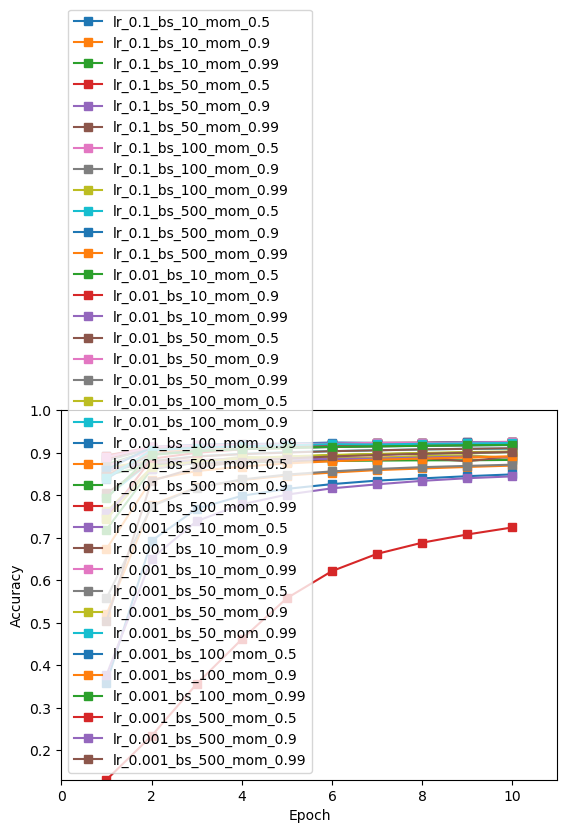

In [24]:
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [10, 50, 100, 500]
momentums = [0.5, 0.9, 0.99]

cfg_base = {
    'data_root': r'C:/Users/31393/Desktop/09d4e2b1-cb77-43d1-a527-b3a5b5f664f9/hw1/data',
    'max_epoch': 10,
    'display_freq': 50,
}

results = {}

for lr in learning_rates:
    for bs in batch_sizes:
        for mom in momentums:
            cfg = cfg_base.copy()
            cfg['learning_rate'] = lr
            cfg['batch_size'] = bs
            cfg['momentum'] = mom

            print("\nTraining with learning rate: {}, batch size: {}, momentum: {}".format(lr, bs, mom))
            
            runner = Solver(cfg)
            loss, acc = runner.train()
            
            key = "lr_{}_bs_{}_mom_{}".format(lr, bs, mom)
            results[key] = (loss, acc)

plot_loss_and_acc(results)

#### 动量^batchsize

In [29]:
import matplotlib.pyplot as plt

def plot_loss_and_acc(results, momentum):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle(f'Training Results for Momentum {momentum}')
    
    for key, (loss, acc) in results.items():
        if key.endswith(f"_mom_{momentum}"):
            epochs = list(range(1, len(loss) + 1))
            ax1.plot(epochs, loss, label=key)
            ax2.plot(epochs, acc, label=key)
    
    ax1.set_title('Loss over epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.set_title('Accuracy over epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

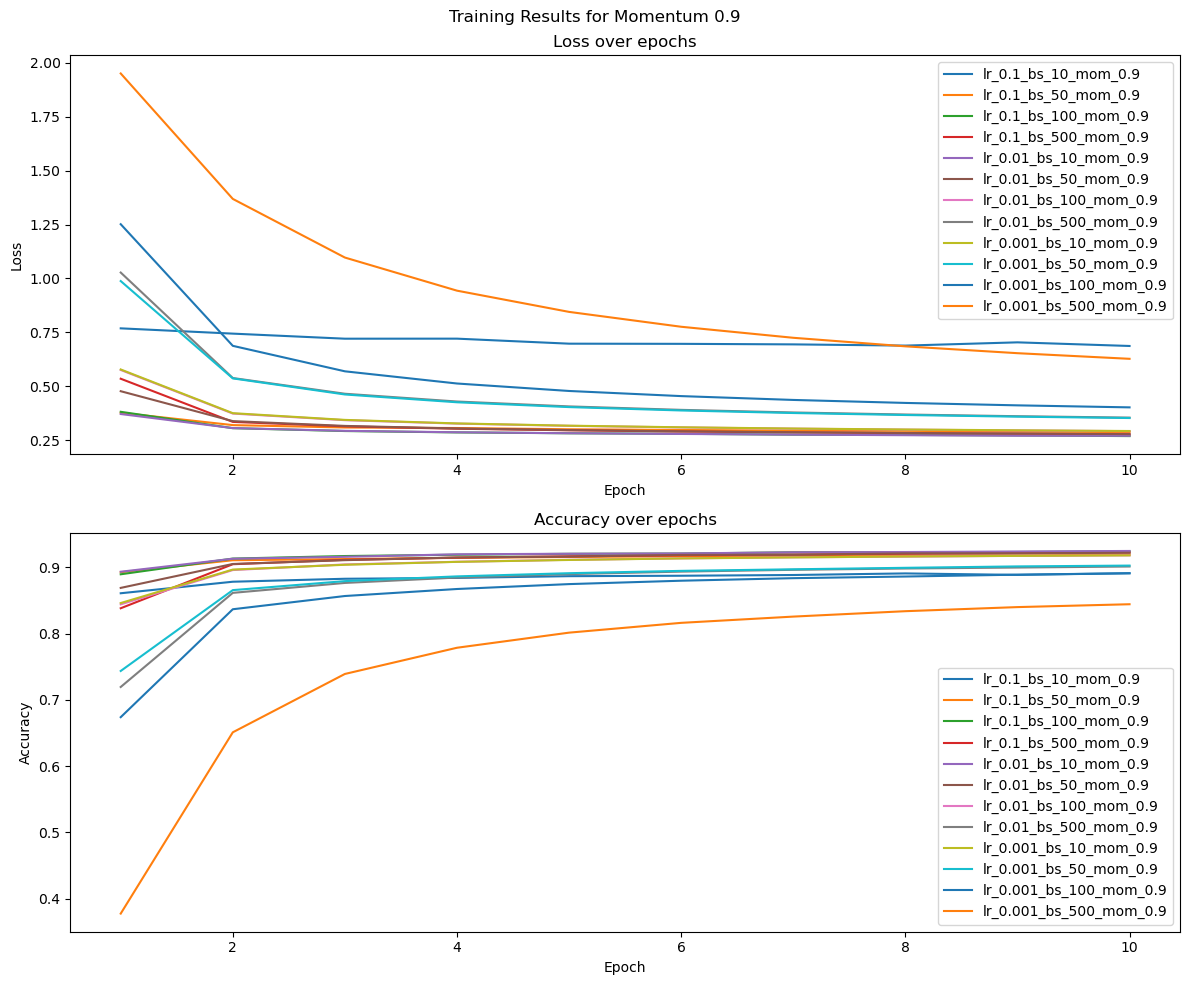

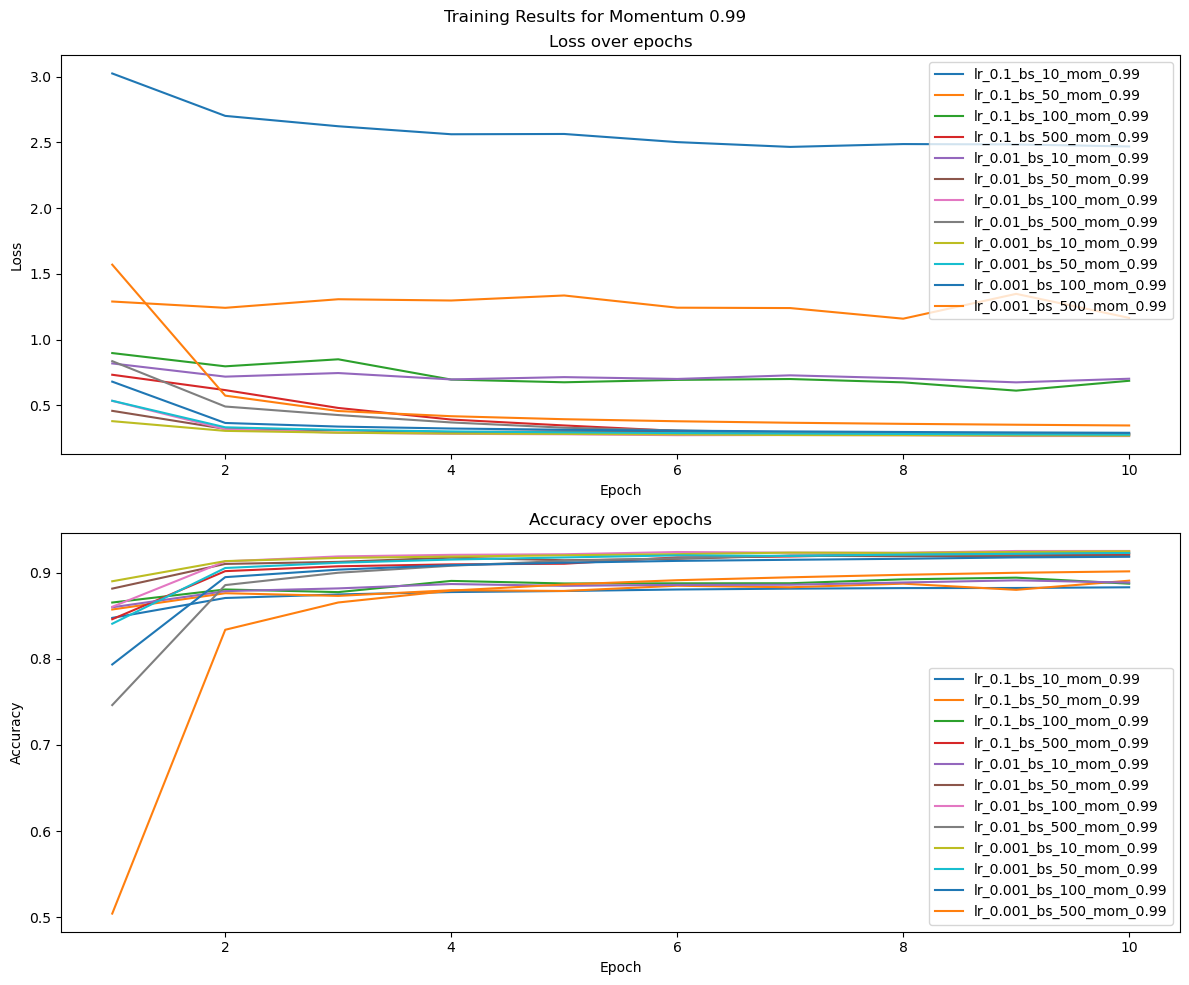

In [30]:
for mom in momentums:
    plot_loss_and_acc(results, mom)

#### 学习率(lr)

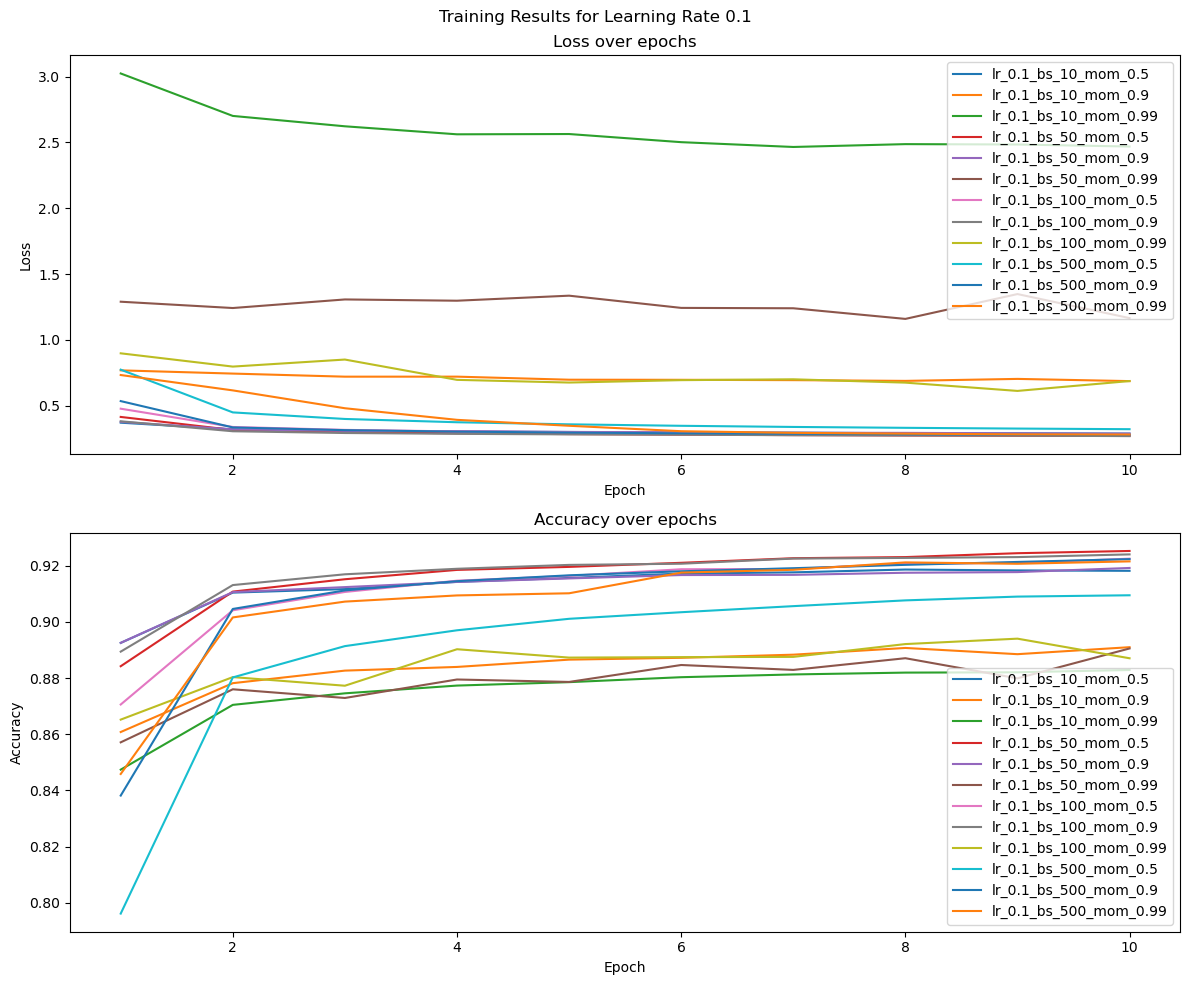

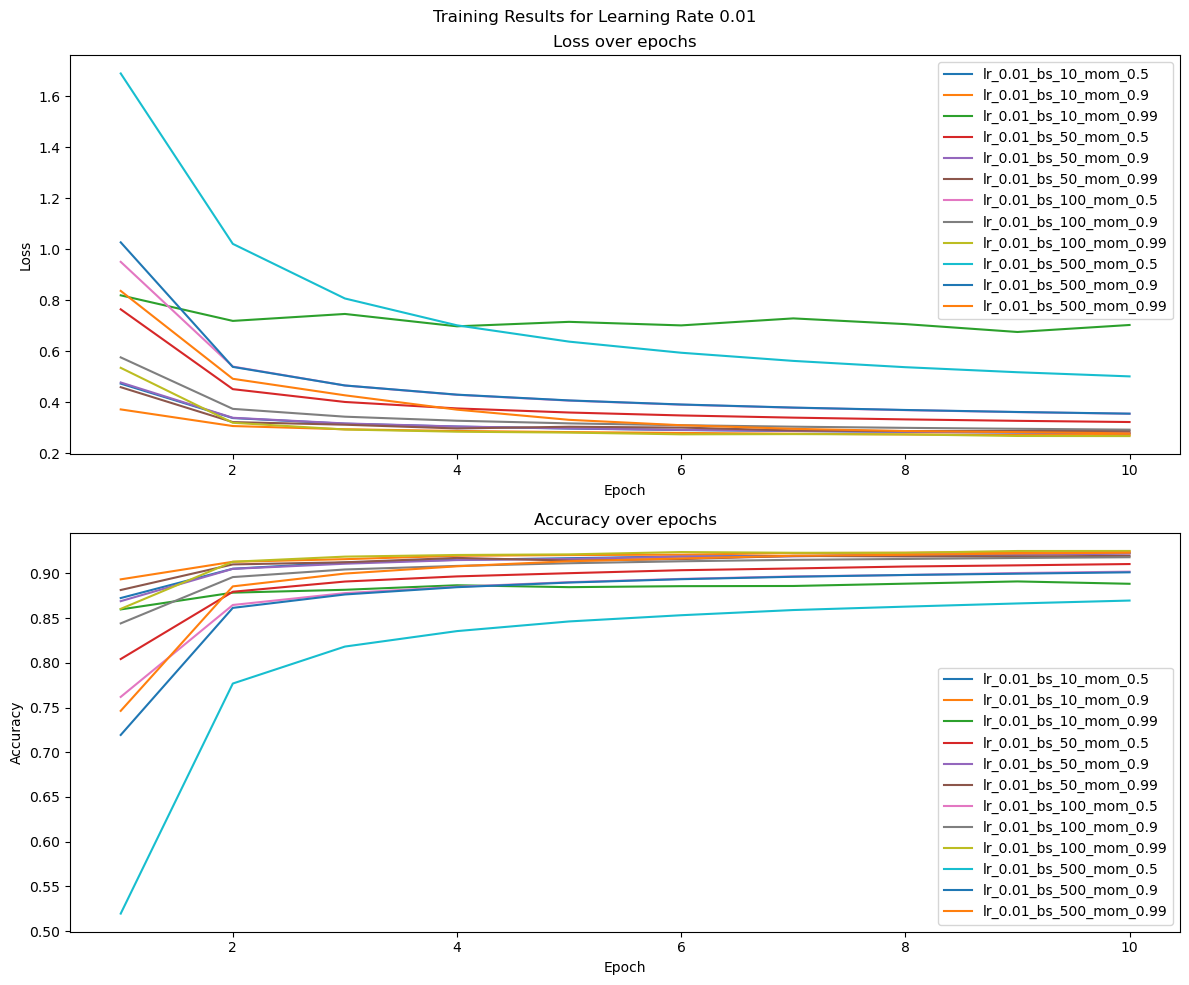

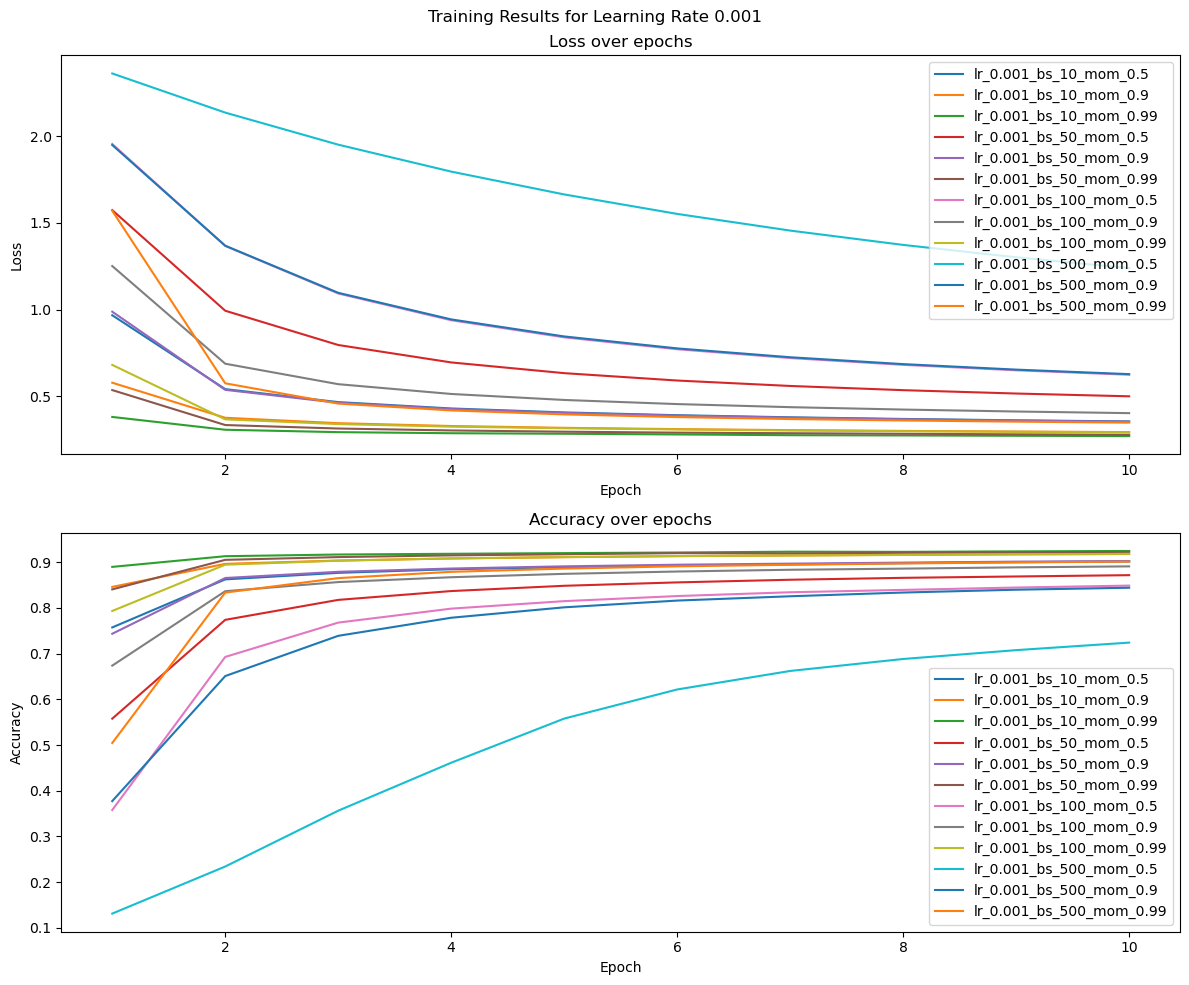

In [31]:
def plot_loss_and_acc(results, learning_rate):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle(f'Training Results for Learning Rate {learning_rate}')
    
    for key, (loss, acc) in results.items():
        if key.startswith(f"lr_{learning_rate}"):
            # 假设loss和acc是数组，分别记录每个epoch的loss和acc
            epochs = list(range(1, len(loss) + 1))
            ax1.plot(epochs, loss, label=key)
            ax2.plot(epochs, acc, label=key)
    
    ax1.set_title('Loss over epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.set_title('Accuracy over epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()


for lr in learning_rates:
    plot_loss_and_acc(results, lr)